In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import stats
import os
from dotenv import load_dotenv
import difflib
from urllib3.util import Retry
from requests.adapters import HTTPAdapter

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased")

In [2]:
#PREFERED SOLUTION but needs a better vocab 
import phunspell
import spacy
from spacy.tokens import Doc, Token,Span
from spacy.language import Language
import requests
from spacy.pipeline import Sentencizer
pspell = phunspell.Phunspell('pl_PL')
nlp = spacy.load("pl_core_news_sm")
import pl_core_news_sm
nlp = pl_core_news_sm.load()
nlp_clean=spacy.load("pl_core_news_md")
nlp.vocab.strings.add("GAMER")
trained_ner_model = spacy.load("gg_ner")
trained_ner = trained_ner_model.get_pipe("new_ruler")
ner=nlp.get_pipe("ner")
Token.set_extension("is_gamer_entity", default=False, force=True)
load_dotenv()
# @Language.component("set_gamer_entities")
def set_gamer_entities(doc, trained_ner_model):
    first_doc=doc
    doc = trained_ner(doc)

    for token in doc:
        for token_ready in first_doc:
            token_ready._.is_gamer_entity = False
            if token.ent_type_ == "GAMER" and token.text== token_ready.text:
                token_ready._.is_gamer_entity = True

   
        nlp.get_pipe("ner").add_label("GAMER")
    return first_doc
def find_most_similar_word_in_sentence(word, sentence):
    words = sentence.split()
    closest_matches = difflib.get_close_matches(word, words, n=1)
    return closest_matches[0] if closest_matches else None
@Language.factory("gg_ner", default_config={"trained_ner_model": trained_ner_model},)
def custom_ner_factory(nlp, name, trained_ner_model):
    def custom_ner(doc):
        return set_gamer_entities(doc, trained_ner_model)

    return custom_ner
# def custom_ner_component(doc):
#     trained_ner_model = spacy.load("gg_ner")
#     trained_doc = trained_ner_model(doc.text)
#     merged_doc = merge_entities(trained_doc, doc)
#     return merged_doc
# def custom_ner_factory(trained_ner_model, labels):
#     def custom_ner(doc):
#         return custom_ner_component(doc, trained_ner_model, labels)
#     return custom_ner


def check_word_context(word, context):
    word_doc = nlp_clean(word)
    context_doc = nlp_clean(context)

    if not word_doc or not word_doc[0].has_vector:
        print("The word does not have a vector representation.")
        return 0.0  # Return a default value when the word doesn't have a vector representation

    similarity_scores = [word_doc[0].similarity(token) for token in context_doc if token.has_vector]
    avg_similarity = sum(similarity_scores) / len(similarity_scores)

    return avg_similarity
def find_most_similar_token(word, tokens):
    token_texts = [token.text for token in tokens]
    closest_matches = difflib.get_close_matches(word, token_texts, n=1)
    return closest_matches[0] if closest_matches else None
def chat_gpt_query(prompt, api_key):
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {api_key}'
    }

    data = {
        'model': "text-davinci-003",
        "prompt":prompt,
        'max_tokens': 150,
        'n': 1,
        'stop': None,
        'temperature': 0.8
    }
    retry_strategy = Retry(
        total=3,  # Number of retries
        backoff_factor=1,
        status_forcelist=[429, 500, 502, 503, 504],
        method_whitelist=["HEAD", "GET", "OPTIONS", "POST"]
    )

    adapter = HTTPAdapter(max_retries=retry_strategy)
    http = requests.Session()
    http.mount("https://", adapter)
    http.mount("http://", adapter)

    response = http.post('https://api.openai.com/v1/completions', json=data, headers=headers, timeout=200)
    # response = requests.post('https://api.openai.com/v1/completions', headers=headers, json=data, timeout=200)

    if response.status_code == 200:
        return response.json()['choices'][0]['text'].strip()
    else:
        raise Exception(f"Error: {response.status_code}, {response.text}")

@Language.component('pl_double_check')
def pl_double_check(doc):
    break_hit=False
    print("im here")
    ents = []
    api_key=os.getenv('API_KEY')

    ents = []

    # Add the custom NER model's entities to the main model's entities
    trained_doc = trained_ner_model(doc)
    # for ent in doc.ents:
        # if ent.label_ == "GAMER":
        #     ents.append(Span(doc, ent.start, ent.end, label="GAMER"))

    for ent in doc.ents:
        if ent.label_ != "":
            ents.append(ent)

    # doc.ents = ents
    ner = nlp.get_pipe("ner")
    # set_gamer_entities(doc)
    ner(doc)
    translation_table = str.maketrans("ABCDEFGHIJKLMNOPQRSTUVWXYZ", "abcdefghijklmnopqrstuvwxyz")

   
    l=[]
    skip_iterations=0
    counter = 0
    i = 0
    for old_token in doc :
        # old_token = doc[i]
        print("start of it ")
        old_token_text =old_token.text.translate(translation_table)
        # and old_token.ent_type_==None
        if counter < skip_iterations:
            counter += 1
            continue

        if(counter>=skip_iterations and old_token_text!='' and old_token_text!='.'and old_token_text!=',' and old_token_text!= '?' and old_token_text!='"' and not old_token._.is_gamer_entity):
            skip_iterations=0
            if  old_token._.has("corrected"):
                # print(f"{old_token_text}_corrected1")
                if(old_token_text!=''):
                    l.append(old_token_text)
                # print("got to the end 1")
            elif(pspell.lookup(old_token_text)):
                # print(f"{old_token_text}_corrected2")
               

                if(old_token.pos_=='NOUN' and (old_token_text[-2:]=='ac' or old_token_text[-2:]=='ec') ):
                    verbified=nlp_clean(old_token_text[0:-1]+'m')[0]
                    print(f"{verbified}_{verbified.pos_}_verbified")
                    if verbified.pos_=='VERB':
                        l.append(old_token_text[0:-1]+'ć')
                    else:
                        if(old_token_text!=''):
                            l.append(old_token_text)
                else:
                    if(old_token_text!=''):
                        l.append(old_token_text)
                # print('made it to the end2')

            else:
                print(f"{old_token.text}_corrected3")
                new_token=Span(doc, old_token.i, old_token.i+1)
                # break_hit=True
                # break

                corrected=""
                # #
                for index,suggestion in enumerate(pspell.suggest(old_token_text)):

                    if index==0:
                        # if check_word_context(suggestion, doc.text) > 0.5:
                            corrected=suggestion

                            print(f"{old_token_text}_suggested")
                        # else :
                        #     l.append(old_token_text)

                # response_text=''
                index=old_token.i
                sentence=old_token.sent
                # new_tokens = [corrected if token.text == old_token_text else token.text for token in doc]
                # new_text = " ".join(new_tokens)

                response_text = chat_gpt_query(f"Napraw nastepujące zdanie, tak aby pisownia i gramatyka była poprawna, dokonując jak najmniej zmian.Pozostaw bez zmian jeśli zdanie jest poprawne i sensowne- zwróć wtedy odpowiedź 'Bez zmian':{old_token_text}", api_key)

                print(f" Response: {response_text}")
                if(response_text=='Bez zmian'):
                    if(corrected!=''):
                        l.append(corrected)
                else:
                    most_similar_word=" "
                # doc2=nlp_clean(response_text)
                # rest_of_the_sentence=''
                    most_similar_word = find_most_similar_word_in_sentence(old_token_text, response_text)
                    if(most_similar_word==None):
                        most_similar_word=corrected
                    if(most_similar_word!=''):
                        l.append(most_similar_word)
                # print(f"most similiar word {most_similar_word}")
                # print("made it to the end 3")
                # for token in doc2:
                #     if( token.i == sentence.end):
                #         break;
                #     else:
                #         if()
                # skip_iterations=len(old_token.sent)-

                # if(len(doc)==17):
                #     print(f"Problem doc !:{old_token_text}")
                # if(len(doc)>old_token.i+1 and old_token.i!=0 and len(doc)!=1):
                #     print('got here 1')
                #     response_text = chat_gpt_query(f"Napraw nastepujące zdanie, tak aby pisownia i gramatyka była poprawna, dokonując jak najmniej zmian:{doc[old_token.i - 1].text +old_token_text+doc[old_token.i +1].text }", api_key)
                #
                # elif(len(doc)==old_token.i+1):
                #     print('got here 2')
                #     response_text = chat_gpt_query(f"Napraw nastepujące zdanie, tak aby pisownia i gramatyka była poprawna, dokonując jak najmniej zmian:{doc[old_token.i - 1].text + old_token_text}", api_key)
                #
                # elif(len(doc)==1):
                #     index=0
                #     print('got here 3')
                #     response_text = chat_gpt_query(f"Napraw nastepujące zdanie, tak aby pisownia i gramatyka była poprawna, dokonując jak najmniej zmian:{ old_token }", api_key)
                #
                # elif(old_token.i==0 and len(doc)!=1):
                #     print('got here 4')
                #     index=0
                #     response_text = chat_gpt_query(f"Napraw nastepujące zdanie, tak aby pisownia i gramatyka była poprawna, dokonując jak najmniej zmian:{old_token_text+doc[old_token.i +1].text }", api_key)



                # if(len(doc2)==1):
                #     old_token_text=doc2[0].text
                #
                # elif(len(doc2)>1):
                #     old_token_text=doc2[index-1].text


                # print(f"{old_token_text}_pass_this")
                # # if(len(doc2)>1):
                # l.append(doc2[1].text)
                #     print("made it 1")
                # elif(len(doc2)<=1):
                #     print("made it 2")
                #     l.append(doc2[0].text)
        else:

            if(old_token_text=='.' or old_token._.is_gamer_entity or old_token_text==',' and old_token_text== '?'and old_token_text=='"'):
                    print("alt option")
                    l.append(old_token_text)
        # i+=1

            
    print("near the end")
    spaces=[]
    for word in l:
        print(word)
        spaces.append(True)
    print("pre doc")
    doc2 = Doc(nlp.vocab, words=l, spaces=spaces)
    # if(break_hit):
    #     spaces.clear()
    #     response_text = chat_gpt_query(f"Napraw nastepujące zdanie, tak aby pisownia i gramatyka była poprawna, próbując dokonać jak najmniej zmian: '{doc.text}'", api_key)
    #     words=response_text.split()
    #     for word in words:
    #         spaces.append(True)
    #     doc = Doc(nlp.vocab, words=words, spaces=spaces)
    # print(f"{doc.text}_doc")
    print("end")
    return (doc2)
def SpellContextCheck(df):
   
    for item in [f'nlp_{i}' for i in range(2, 6)]:
       
         text_data = df[item].apply(lambda x:nlp(x))
         df[item]=text_data
     
         print(f"{text_data}_recieved")
    return df

custom_sentencizer = Sentencizer(punct_chars=["."])
nlp.add_pipe("pl_double_check", after='ner')
nlp.add_pipe("sentencizer", before="pl_double_check")
nlp.remove_pipe("parser")
nlp.add_pipe("gg_ner", before="pl_double_check")

# nlp("domowników")
DATASET_CHECK='NLP_CONNECTED.xlsx'
df = pd.read_excel(io=DATASET_CHECK)

df= SpellContextCheck(df)
# Read(df)
df.to_excel('NLP_CONNECTED.xlsx', index=False)



im here
start of it 
start of it 
wyluzowac_corrected3
wyluzowac_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: i nie martwic sie za bardzo.

Wyluźnić się i nie martwić się za bardzo.
start of it 
alt option
start of it 
start of it 
uspokoic_corrected3
uspokoic_suggested
 Response: sie

Uspokoić się.
start of it 
alt option
start of it 
start of it 
gram_VERB_verbified
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
się
wyluzować
.
się
Uspokoić
.
lubię
grać
.
satysfakcja
.
przyjemność
.
ochota
.
rozprężenie
.
relaks
.
ukojenie
.
zabawa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
zabicie
nudy
.
rozrywka
.
oderwanie
.
rozproszenie
.
pre doc
end
im 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na przyszłości pozwala stać się lepszym.Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
fokus owanie
się
.
reakcja
.
nauka
.
stabilizacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Rozwijająco_corrected3
rozwijająco_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: się mały interes
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaksująco
.
rozwijając
.
umila
kolejki
.
umila
dojazdy
.
zabija
czas
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
dostarcza
rozrywki
.
odpręża
.
wyciszenie
.
rywalizacja
.
słaba
bateria
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
probl_corrected3
probl_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ém nie zostal jeszcze rozwiazan

Problem nie został jeszcze rozwiązany.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksuje
.
pozwala
zabić
czas
.
jest
przyjemne
.
oderwanie
od
Problem
.
kradnie
czas
.
uzależnia
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
Odwrwanie_corrected3
odwrwanie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie od telewizji i siedzenia całymi dniami przed komputerem jest dla mnie ważneBez zmian.
start of it 
start of it 
zycia_corrected3
zycia_suggested
 Response: bez przyjaciol i rodziny byłoby pozbawionym sensu

Życie bez przyjaciół i rodziny byłoby pozbawione sensu.
start of it 
alt option
start of it 
Wypelnienie_corrected3
wypelnienie_suggested
 Response: ankiety byloby bardzo podziekowane

Wypełnienie ankiety byłoby bardzo podziękowane.
start of it 
start of it 
alt option
start of it 
Zabivie_corrected3
zabivie_suggested
 Response: dzieci w wozku szkolnym

Zabiły dzieci w wózku szkolnym.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
relaksuje
mnie
.
oderwanie
id
Życie
.
Wypełnienie
czasu
.
zabicie
nudy
.
szkodzi
na
wzrok
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
star

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: on na nasz styl życia

Wpływa on na nasz styl życia. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
Wpływa
.
relaks
.
lepsze
samopoczucie
.
rozrywka
.
i
dobre
gry
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaksujące
.
hobby
.
rywalizacja
.
inny
świat
.
Ćwiczenie
umysłu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
wuobraźnię_corrected3
wuobraźnię_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest potrzebna do tworzeniaBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Koji_corrected3
koji_suggested
 Response: jest bardzo chytra

Koji jest bardzo chytry.
start of it 
alt option
near the end
uspokaja
.
wyrabia
wyobraźnię
.
uczy
.
kreuje
.
Koji
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Uzalezbienie_corrected3
uzalezbienie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: od technologii rosnie

Uzależnienie od technologii rośnie. Bez zmian
start of it 
alt option
near the end
brak
czasu
.
relaks
.
odstresowanie
.
finanse
.
Uzależnienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksująco
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Wciaga_corrected3
wciaga_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łam sie w lekture

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksuje
.
wciąga
.
uzależnia
.
ok
.
fan
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Nfs_corrected3
nfs_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: a jest to protokół komunikacji w sieciBez zmian.
start of it 
alt option
start of it 
Fifa_corrected3
fifa_suggested
 Response: jest najpopularniejszą częścią gry wideo.Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Gów_corrected3
gów_suggested
 Response: wny priorytetem jest bezpieczeństwoGłównym priorytetem jest bezpieczeństwo.Bez zmian.
start of it 
alt option
near the end
cod
.
NFS
.
FIFA
.
star
wars
.
ów
.
pre doc
end
im here
start of it 
Nude_corrected3
nude_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łkowania zawsze było mi trudne

Nudowania zawsze było mi trudne.
start of it 
start of it 
cdzień_corrected3
cdzień_suggested
 Response: dobryBez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
wytchnenie_corrected3
wytchnenie_suggested
 Response: , bo wszystko sie udalo

Wytchnienie, bo wszystko się udało.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
trudne
na
dzień
.
wolny
czas
.
daje
odskocznie
.
nowinki
.
sprawność
.
nic
nie
zmienia
.
fajnie
jest
.
umila
czas
.
daje
Wytchnienie,
.
pomaga
się
skupić
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: rushs

Adrenalina przypływu.
start of it 
alt option
near the end
rzeczywistość
.
rywalizacja
.
zabija
czas
.
relaksuje
.
podnosi
Adrenalina
.
pre doc
end
im here
start of it 
Rozne_corrected3
rozne_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: rodzaje sportu sa dla mnie interesujace.Bez zmian.
start of it 
alt option
start of it 
Fiekawe_corrected3
fiekawe_suggested
 Response: jest poznawanie nowych rzeczy
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rodzaje
.
ciekawe
.
fajne
.
dobre
.
super
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
nwego_corrected3
nwego_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie boje

Nie boję się niczego.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
coś
niczego.
.
wyłączenie
się
.
nauka
.
przyjemność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rewalizacja_corrected3
rewalizacja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: twojego otoczenia jest twoją odpowiedzialnością

Realizacja twojego otoczenia jest twoją odpowiedzialnością. Bez zmian.
start of it 
alt option
near the end
czas
.
rozrywka
.
czas
.
edukacja
.
wyzwanie
.
Realizacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rozluzniająco_corrected3
rozluzniająco_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
wyciszająco
.
uspokajająco
.
rozluźniająco
.
zapomnieć
o
.
dla
zabawy
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
czasu
.
znudzenie
.
zmęczenie
.
dobra
zabawa
.
towarzystwo
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
niewiele
zmienia
.
czasem
irytuje
.
zabiera
czas
.
odłącza
.
chyba
już
nic
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: a najpopularniejsza gra sportowa na swiecieBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
swiat_corrected3
swiat_suggested
 Response: nie byłby taki sam gdyby nie Ty

Świat nie byłby taki sam gdyby nie Ty.
start of it 
alt option
near the end
FIFA
.
super
.
zajawka
.
hobby
.
mój
Świat
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabiera
czas
.
czasami
uzależnia
.
odpręża
.
również
denerwuje
.
relaksuje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
cierpliwo

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nigdy za wiele

Bez zmian.
start of it 
alt option
near the end
odpręża
.
uczy
koncentracji
.
Ćwiczy
refleks
.
zabiera
czas
.
uczy
cierpliwości
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
pozbycie
się
nudy
.
strata
czasu
.
emocje
.
rywalizacja
.
ciekawość
.
koncentracja
.
Ćwiczy
refleks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
analizowanie
.
koncentracja
.
obowiązki
.
odpoczynek
.
relaks
.
radość
.
smutek
.
pre doc
end
im here
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sa moje zainteresowania
Bez zmian.
start of it 
alt option
start of it 
Fiekawe_corrected3
fiekawe_suggested
 Response: Fajne
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
różne
.
ciekawe
.
fajne
.
dobre
.
super
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozrywka
.
rozwijają
mnie
.
mało
czasu
.
mówię
stop
.
nie
wpływa
.
relaks
.
zajmuje
wolny
czas
.
wyniki
.
nie
wiem
co
więcej
.
nic
więcej
.


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wlasciwosci akustycznych pomieszczenia

Wyciszenie właściwości akustycznych pomieszczenia.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
umyslu_corrected3
umyslu_suggested
 Response: bez którego nie bylibyśmy w stanie istnieć

Umysłu bez którego nie bylibyśmy w stanie istnieć.
start of it 
alt option
near the end
relaks
.
wypoczynek
.
Wyciszenie
.
beztroska
.
oczyszczenie
Umysłu
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
gry
nie
mają
żadnego
wpływu
na
życie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odcięcie
od
świata
.
rywalizacja
.
emocje
.
przynależność
.
pre doc
end
im here
start of it 
start of it 
alt option
start o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: się bawilem na dyskoteceBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
wspaniale
.
świetnie
.
ok
.
dalej
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
radość
.
emocje
.
spokój
.
relaks
.
odpoczynek
.
pre doc
end
im here
start of it 
Pozw_corrected3
pozw_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ól mi poznać swoje marzenia

Pozwól mi poznać Twoje marzenia.
start of it 
alt option
start of it 
odstresowa_corrected3
odstresowa_suggested
 Response: ć sie

Odstresować się.
start of it 
alt option
start of it 
Pozw_corrected3
pozw_suggested
 Response: ol mi zwiedzić twój dom

Pozwól mi zwiedzić Twój dom.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Pozw_corrected3
pozw_suggested
 Response: ala siebie wyrażac

Pozwala sobie wyrażać.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
poznać
.
Odstresować
.
Pozwól
.
uspokoić
.
zabiera
czas
.
wydaje
pieniądze
.
pow
.
być
innym
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: w pokoju jest ogromny

Balagan w pokoju jest ogromny. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
przeszkadza
mi
.
czasami
gram
.
brak
dużo
snu
.
nie
dojadam
.
brak
czasu
.
Balagan
.
nie
.
wiem
.
co
.
dalej
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabiera
dużo
czasu
.
staje
się
nerwowa
.
denerwuje
.
refleks
.
logiczne
myślenie
.
adrenalina
.
stres
.
emocje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łem bardzo dużo energiiBez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Zasmieca_corrected3
zasmieca_suggested
 Response: ł jest teren

Zasmiecony jest teren.
start of it 
start of it 
alt option
near the end
uzależnia
.
zjada
czas
.
jest
bez
sensu
.
zszywa
stres
.
nic
nie
wnosi
.
niekiedy
jest
ok
.
zabija
czas
.
rozwija
palce
.
czerpie
energie
.
Zasmiecony
mózg
.
pre doc
end
im here
start of it 
Rozrykwa_corrected3
rozrykwa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest fajna

Rozrywka jest fajna. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Rozrywka
.
oderwanie
.
skupienie
się
.
poznanie
osób
.
odpoczynek
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
ucieczka
.
rozwój
wyobraźni
.
próba
cierpliwości
.
trening
planowania
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
różnie
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: godzin pracy pozwoli pracownikom odpowiednio zadbać o swoje zdrowie.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
rozluźnienie
.
zabawa
.
spokój
.
mój
czas
.
pre doc
end
im here
start of it 
Rozywka_corrected3
rozywka_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: do gry w piłkę to świetne sposób na spędzenie wolnegodniBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rozluznienie_corrected3
rozluznienie_suggested
 Response: szkolnych obowiazkow

Rozluźnienie szkolnych obowiązków.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Oderawnie_corrected3
oderawnie_suggested
 Response: chodzi o kino

Ich ostatnia wizyta w kinie była bardzo udana.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
pozytyw
.
Rozluźnienie
.
radość
.
oderwanie
.
urozmaicenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
funn\'u_corrected3
funn\'u_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Funny'u, ze mną zawsze jest zabawnie.
Bez zmian.
start of it 
alt option
near the end
odpręża
.
uspokaja
.
działa
pobudzająco
.
wzmaga
rywalizację
.
dla
Funny'u,
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
nie
zbyt
często
.
zabawa
.
odpoczynek
.
coś
nowego
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
determinacja
.
odprężenie
.
hobby
.
odpoczynek
.
spokój
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ze mną sie pomylilBez zmian
start of it 
start of it 
alt option
start of it 
RoŹleniwia_corrected3
roŹleniwia_suggested
 Response: łam sięBez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
negatywny
wpływ
.
złodziej
czasu
.
rozleniwia
mnie
.
rozkojarza
.
otumania
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odskocznia
.
odreagowanie
.
nuda
.
relaks
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
strata
czasu
.
ból
głowy
.
zbędne
.
niekonieczne
.
męczące
.
pre doc
end
im here
start of it 
start of it 
alt option
start

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie

Odstersowywuje się. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabiera
czas
.
Odstersowywuje
.
kolejna
rzecz
.
inne
rzeczy
.
zapominanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wyzwanie
.
rozrywka
.
rywalizacja
.
odskocznia
.
odstresowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
pozytywnie
.
ciekawie
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt opti

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to jedna z największych firm technologicznych na świecieBez zmian.
start of it 
alt option
start of it 
Fifa_corrected3
fifa_suggested
 Response: to jedna z najbardziej popularnych gier na świecie
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Microsoft
.
FIFA
.
gram
.
często
.
dobrze
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksuje
mnie
.
zapomnienie
.
relaks
.
rywalizacji
.
marnotrawienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
umyslu_corrected3
umyslu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ludzkiego

Umysłu ludzkiego.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
Ćwiczenie
Umysłu
.
odskocznia
.
zabawa
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksująco
.
odprężająco
.
wciągająco
.
inna
rzeczywistość
.
wciągająco
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
znajomosci_corrected3
znajomosci_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z komputerami są bardzo ważne dla studentów
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
relaksuje
.
bawi
.
uczy
.
nowe
znajomości
.
czas
tylko
dla
mnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
ekscytacja
.
dobra
zabawa
.
sposób
na
nudę
.
logiczne
myślenie
.
refleks
.
pre doc
end
im here
start of it 
Rozluznia_corrected3
rozluznia_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ja sie mięsnie
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozluźnia
.
odstresowuje
.
zżera
czas
.
relaksuje
.
pozwala
odpocząć
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pobudza
wyobraźnie
.
relaksuje
.
zabija
czas
.
cieszy
wzrok
.
wyzwala
emocje
.
bawi
.
uczy
.
wychowuje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
a

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ąc od sytuacji
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
zmusły_corrected3
zmusły_suggested
 Response: mnie do poświęcenia więcej czasu na naukę

Zmusiły mnie do poświęcenia więcej czasu na naukę.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
gry
uzależnienia
.
zabierają
czasy
.
są
wciągające
.
pobudzają
Zmusiły
.
dają
satysfakcję
.
pre doc
end
im here
start of it 
Odpreza_corrected3
odpreza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łem sięBez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odpręża
.
koncentruję
.
zarabiam
.
odpoczywam
.
nowe
doświadczenia
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Uspokojnie_corrected3
uspokojnie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jszy

Uspokój się.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
rozwój
.
ciekawość
.
zrelaksowanie
.
spokojnie
.
walka
z
nudą
.
nie
mam
pomysłu
.
nie
mam
pomysłu
.
nie
mam
pomysłu
.
nie
mam
pomysłu
.
nie
mam
pomysłu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Adenalina_corrected3
adenalina_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: , to substancja wydzielana w naszym organizmie w czasie stresu.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odcięcie
.
zapomnienie
.
emocje
.
koncentracja
.
adrenalina
.
zawzięcie
.
walka
.
energia
.
radość
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabija
czas
.
nie
ma
wpływu
.
rozładowuje
tel
.
jest
bez
znaczenia
.
nic
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pozytywnie
.
negatywnie
.
pozyt

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie na czesci

Rozerwać się na części.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
szzybko_corrected3
szzybko_suggested
 Response: zrozumiałem że wiedza jest potrzebna do zdobycia sukcesu.Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
można
się
Rozerwać
.
mogę
się
wykazać
.
wymaga
myślenia
.
wciąga
.
uzależnia
.
czas
szybko
płynie
.
gry
są
ciekawe
.
realistyczne
.
są
różne
gry
.
lubię
w
nie
grać
.
pre doc
end
im here
start of it 
Odstresowywuje_corrected3
odstresowywuje_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie chodząc po lesieBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odstresowuje
.
pada
bateria
.
nie
przeszkadza
.
poprawia
mi
humor
.
poprawia
pamięć
.
pre doc
end
im here
start of it 
Odstresowujaco_corrected3
odstresowujaco_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Odstresowująco.
start of it 
alt option
start of it 
Rozbawiajaco_corrected3
rozbawiajaco_suggested
 Response: Rozbawiąco.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
Odstresowująco.
.
Rozbawiąco.
.
pozwala
wyluzować
.
relaksująco
.
odprężająco
.
zabiera
czas
.
zabiera
energię
.
uspokaja
głowę
.
pozwala
zapomnieć
.
zabiją
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
adrenalina
.
radość
.
smutek
.
poznawanie
.
Żal
.
pre doc
end
im here
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie uczyć

Rozwijaj się ucząc. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
brak
poczucia
czasu
.
spostrzegawczość
.
zręczność
.
Rozwijaj
.
wpływa
na
emocje
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
spedzony_corrected3
spedzony_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: w te wakacje wiele czasu na wsi

Spędziłem w te wakacje wiele czasu na wsi.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
sposób
na
nudę
.
relaks
.
odpoczynek
.
mile
spędzony
czas
.
uzależnia
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
inspiracja
.
radość
.
humor
.
zabijanie
nudy
.
lepszy
dzień
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
odprężenie
.
uczenie
się
.
utrata
czasu
.
zaniedbywanie
.
obniżenie
relacji
.
gorsza
jakość
snu
.
pre doc
end
im here
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: m sie do pisania

Zabieram się do pisania.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
Zabieram
czas
.
zabija
nudę
.
pozwala
na
reset
.
pochłania
czas
.
bolą
oczy
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabiera
czas
.
relaksuje
.
rozrywka
.
nuda
.
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
umyslu_corrected3
umyslu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest wiele możliwości
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
zabicie
czasu
.
refleks
.
trening
umysłu
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
styl
.
brak
nudy
.
marka
.
renoma
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odskocznia
.
odprężenie
.
rywalizacja
.
radość
.
ekscytacja
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie w pieknych kwiatów

Marzą się w pięknych kwiatach.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zaakakuje_corrected3
zaakakuje_suggested
 Response: sie w moich myslach 

Zakochałem się w moich myślach.
start of it 
alt option
near the end
odskocznia
.
marnuje
czas
.
wkurza
.
bawi
.
zaskakuje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozluźnienie
.
wypełnienie
.
nuda
.
rozrywka
.
czas
.
wieczór
.
emituje
.
emocje
.
rozrywka
.
wieczór
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Wkreca_corrected3
wkreca_suggested

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łem sie w te historię.

Wkręcałem się w tę historię.
start of it 
alt option
start of it 
start of it 
adrenaline_corrected3
adrenaline_suggested
 Response: rush is an intense feeling of excitement.Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
uspokaja
.
wkręca
.
podnosi
adrenalin
.
wyższy
poziom
.
przyzwyczaja
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabija
czas
.
rozwija
zmysł
.
uczy
cierpliwości
.
w
wolnych
chwilach
.
strategiczny
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ła mnie powoli, ale skutecznie w swoje szare oblicze

Wciągała mnie powoli, ale skutecznie w swoje szare oblicze.
start of it 
alt option
near the end
odprężenie
.
dobra
zabawa
.
kontakt
z
innymi
.
zabiera
mi
czas
.
wciąga
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
mało
czasu
.
stres
.
ekscytacja
.
pęd
życia
.
brak
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
miło
.
przyjemnie
.
miłość
.
pozytywne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: i idzie do pracy

Chandra idzie do pracy.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabiera
mi
czas
.
Ćwiczę
pamięć
.
lek
na
Chandra
.
pomaga
w
nudzie
.
Ćwiczy
koncentracje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
neutralnie
.
uspokajająco
.
wyciszenie
.
relaks
.
skupienie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
nie
problem
.
jest
ok
.
jest
dobrze
.
nie
jest
to
problem
.
pre doc
end
im here
start of it 
start of it

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to ważny element życiaBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
talent
.
spokój
.
granie
.
gry
.
pre doc
end
im here
start of it 
start of it 
odstresowywują_corrected3
odstresowywują_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: cymi się hobbyBez zmian
start of it 
alt option
start of it 
start of it 
codzien_corrected3
codzien_suggested
 Response: rano wstaje wczesnie.

Codziennie rano wstaję wcześnie.
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
gry
odstresowują
.
na
Codziennie
w
pracy
.
relaks
po
pracy
.
kontakt
ze
światem
.
komunikatory
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywkowe
.
uspokajające
.
tonujące
.
wciągające
.
relaksujące
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: i radość dojmowała uczestników

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
radość
.
ekscytacja
.
uśmiech
.
strata
czasu
.
uzależnienie
.
pre doc
end
im here
start of it 
start of it 
eleven_corrected3
eleven_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: o clock

Eleven o'clock. Bez zmian.
start of it 
alt option
start of it 
Coin_corrected3
coin_suggested
 Response: the phrase "all good things must come to an end"
Bez zmian.
start of it 
masters_corrected3
masters_suggested
 Response: degree in law jest moim celem.

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Little_corrected3
little_suggested
 Response: Johnnie was always so enthusiastic about his schoolwork

Little Johnny was always so enthusiastic about his schoolwork.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
top
Eleven
.
coon
Masters
.
pasjans
.
Little
city
.
warcaby
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
relaks
.
odpoczynek
.
nauka
.
zainteresowania
.
pre doc
end
im here
start of it 
start of it

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nam jest mało

Bez zmian.
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alchajmera_corrected3
alchajmera_suggested
 Response: to choroba neurodegeneracyjna

Alzheimera to choroba neurodegeneracyjna. Bez zmian.
start of it 
alt option
near the end
zapełnia
czas
.
brak
chęć
jedzenia
.
czasu
na
pracę
.
rozwija
umysł
.
opóźnia
Alzheimera
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Odmóżdzają_corrected3
odmóżdzają_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: c z zaczątkiem lataBez zmian
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksuje
mnie
.
to
forma
rozrywki
.
przestać
myśleć
.
odmóżdżają
.
odpoczynek
.
pre doc
end
im here
start of it 
start of it 
start of it 
odmozdza_corrected3
odmozdza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łabym się do domuBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
wciaga_corrected3
wciaga_suggested
 Response: łem sie w te ksiazki

Wciągałem się w te książki.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
granie
mnie
odmładza
.
relaksuje
.
nie
wciąga
.
luzuje
.
zabija
czas
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
strata
czasu
.
rozrywka
.
umiejętności
.
ciekawość
.
relaks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozwija
.
leczy
.
pomaga
.
spełnia
.
nie
wiem
.
pre doc
end

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: informacji jest procesem istotnym dla naszego mózgu.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Pamiec_corrected3
pamiec_suggested
 Response: jest dla mnie bardzo ważnaPamięć jest dla mnie bardzo ważna.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
refleks
.
zapamiętywanie
.
relaks
.
mnie
.
bicie
rekordów
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
rozwój
.
brak
nudy
.
odprężenie
.
zaciekawienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
st

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: marzen o wygranej w konkursie

Spelnienia marzenia o wygranej w konkursie.
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
inny
świat
.
zapomnienie
.
rozrywka
.
odprężenie
.
motywacja
.
rozwój
.
przygoda
.
poczucie
Spelnienia
.
przerwa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
emocje
.
zabicie
czasu
.
rywalizacja
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
super
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
chwila
.
odpoczynek
.
zabawa
.
moment
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: je sie nie potrzebne slowa

Ostatnio musiałem naprawić samochód.

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabawa
.
radość
.
spędzenie
casy
.
rozrywka
.
refleks
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
daje
mi
radość
.
zadowolenie
.
chwile
wytchnienia
.
spokój
.
wyciszenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
myslenie_corrected3
myslenie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: out of the box jest cenione w wiekszosci firm

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
sie_corrected3
sie_suggested
 Response: zgłaszają na studia

Siebie zgłaszają na studia.
start of it 
alt option
near the end
zabawa
.
logiczny
myślenie
.
rozmowa
.
rozrywka
.
odprężenie
się
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
bez
wpływu
.
nic
poza
tym
.
grają
dzieci
.
mam
konsolę
.
ok
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabiera
czas
.
można
odpo

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ość pracowników wzrosła o 20%Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabiera
czas
.
zmniejsza
produktywna
.
odpręża
.
wyzwanie
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
strata
czasu
.
rozrywka
.
przyjemność
.
chwila
zapomnienia
.
rywalizacja
.
kreatywność
.
dążenie
do
celu
.
twórczość
.
opłaty
.
zużycie
sprzętu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: szukalismy w internecie

Długo szukaliśmy w Internecie.
start of it 
alt option
start of it 
start of it 
alt option
near the end
pozytywnie
.
negatywnie
.
odprężające
.
za
Długo
.
hobbystycznie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
rywalizacja
.
spokój
.
cisza
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
radość
.
odstresowanie
.
satysfakcja
.
odpoczynek
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the en

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: swoje kontoSprawdzam swoje konto
start of it 
start of it 
alt option
near the end
relaks
.
przerwa
.
nie
wpływa
.
lubię
.
konto
czas
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
bycie
na
bieżąco
.
rozrywka
.
czas
wolny
.
ciekawość
.
spędzanie
czasu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabija
nudę
.
po

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pasów bezpieczeństwa podróżujących jest obowiązkowe
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zwapnienie
.
oderwanie
.
spełnienie
.
teraźniejszość
.
zdrowie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
Ię_corrected3
ię_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: od nich coś wyciągnąć

Spróbuję coś wyciągnąć od nich.
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
kudzi_corrected3
kudzi_suggested
 Response: się interesował wystawami sztukiBez zmian.
start of it 
alt option
start of it 
start of it 
sie_corrected3
sie_suggested
 Response: uspokoilem

Bez zmian.
start of it 
alt option
start of it 
start of it 
sybiej_corrected3
sybiej_suggested
 Response: to nie pojde

"Nie pójdę tam sam."
start of it 
start of it 
alt option
near the end
relaksuje
się
.
iem
o
to
z
żoną
.
poznaje
nowych
Kudzi
.
uczę
się
.
czas
rybiej
leci
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt opt

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ém jest to że nikt nie lubi rozwiązywać konfliktyProblem jest taki, że nikt nie lubi rozwiązywać konflikty.
start of it 
alt option
near the end
dobrze
spędzam
czas
.
odpoczywam
.
relaksuję
się
.
odprężam
się
.
zapominam
o
probe
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
refleks
.
pamięć
.
relaks
.
spostrzegawczość
.
odprężenie
.
rozrywka
.
spryt
.
zwinność
.
otwarty
umysł
.
radość
.
pre doc
end
im here
start of it 
Wot_corrected3
wot_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to była moja pierwsza podróż samolotem

To była moja pierwsza podróż samolotem. Bez zmian.
start of it 
alt option
start of it 
Nfs_corrected3
nfs_suggested
 Response: jest ulubioną grą wielu graczyBez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
WOT
.
NFS
.
spoko
.
fajnie
.
cool
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
odpoczynek
.
relaks
.
zabawa
.
odstresowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaksuje
.
umila
czekanie
.
to
wszystko
.
to
wszys

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ny, i enjoy spending time with my family

Funny, I enjoy spending time with my family. Bez zmian.
start of it 
alt option
near the end
odskocznia
.
odmóżdżenie
.
zabawa
.
zabicie
czasu
.
fon
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
uspokojenie
.
wciąga
.
uzależnienie
.
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
marnowanie
czasu
.
relaks
.
irytacja
.
myślenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: po ciezkiej nocce

Odpoczętek po ciężkiej nocy.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksuje
.
odskocznia
.
Odpoczętek
.
czas
wolny
.
zabawa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
odprężenie
.
rozrywka
.
nudy
.
zabijanie
czasu
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Bra_corrected3
bra_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: kowało mi kogoś, kto by mnie wysłuchałBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
ucz
y
refleksu
.
rozwija
umysł
.
zabiera
cenny
czas
.
brak
.
bar
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odpręża
.
relaksuje
.
wypoczywam
.
rozwija
.
zajmuje
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
spokój
.
zabicie
czasu
.
rozładowanie
emocji
.
wyobraźnia
.
skupienie
uwagi
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt optio

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ynienia są niezbędne dla dobra narodu.

Porozumienia są niezbędne dla dobra narodu.
start of it 
start of it 
alt option
near the end
relaks
.
zabawa
.
historia
.
przygoda
.
pożeracz
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
wyciszenie
.
rozrywka
.
usypianie
.
odprężenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
zabicie
nudy
.
coś
ciekawego
.
kreatywność
.
zabicie
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
a

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pozwala nam zrozumiec swiatBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nuda
.
ciekawość
.
myślenie
.
zabawa
.
strata
czasu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nowi
ludzie
.
nowe
spojrzenie
.
lepszy
refleks
.
podzielność
uwagi
.
brak
telewizji
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
pasja
.
zabijanie
czasu
.
wspomnienia
.
rozwój
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: bie, otaczającej mnie rzeczywistości i ludziBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
ze
znajomymi
.
odstresowanie
się
.
wolny
czas
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
mniej
czasu
.
odprężony
.
myślący
.
zrelaksowany
.
na
czasie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksuje
.
odpręża
.
rywalizacja
.
osiągnięcia
.
zabawa
.
rozrywka
.
wyzwanie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: czulem po dobrze wykonanej pracy

Satyfakcję czułem po dobrze wykonanej pracy.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozbawia
mnie
.
denerwuje
mnie
.
sprawia
przyjemność
.
daje
mi
Satyfakcję
.
zabiera
dużo
czasu
.
pogarsza
wzrok
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odskocznia
.
pochłaniają
.
strata
czasu
.
relaks
.
logiczne
myślenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ja sie

Rozluźniają się.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
zabija
nudę
.
uspokaja
.
Ćwiczy
umysł
.
Rozluźniają
.
odkrywam
nowe
rzeczy
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
dziecmi_corrected3
dziecmi_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Dzieciami
start of it 
alt option
near the end
czas
z
dziećmi
.
relaks
.
satysfakcja
.
niewyspanie
.
przyjaciele
.
zjadacz
czasu
.
ból
oczu
.
wieczór
.
Śmiech
.
wspólnie
z
Dzieciami
.
pre doc
end
im here
start of it 
start of it 
wplywa_corrected3
wplywa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć na

Bez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
wpływa
.
relaksuje
.
bawi
.
zabiera
czas
.
denerwuje
.
pre doc
end
im here
start of it 
Odstresowuja_corrected3
odstresowuja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć się 
Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
wciagajace_corrected3
wciagajace_suggested
 Response: Wciągające
start of it 
alt option
start of it 
Bawia_corrected3
bawia_suggested
 Response: łam sie świetnie
Bez zmian.
start of it 
alt option
start of it 
Denerwuja_corrected3
denerwuja_suggested
 Response: sie

Denerwują się.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
uwage_corrected3
uwage_suggested
 Response: , jak szybko mija czas

Uwaga, jak szybko mija czas.
start of it 
alt option
start of it 
start of it 
alt option
near the end
odstresowują
.
zabierają
czas
.
wyłączają
umysł
.
są
Wciągające
.
wabia
.
Denerwują
.
nic
.
pochłaniają
uwagę
.
ekscytują
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: on na nasze zycie

Wpływa on na nasze życie.
start of it 
jakos_corrected3
jakos_suggested
 Response: musze poradzić sobie z tym problemem.

Jakoś muszę poradzić sobie z tym problemem.
start of it 
alt option
near the end
odpoczynek
.
zabicie
czasu
.
spokój
.
czemu
nie
.
nie
wymyślę
nic
.
gram
bo
gram
.
gram
przy
okazji
.
nie
Wpływa
Jakoś
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
bieda
.
bogactwo
.
wyrozumiałość
.
inteligencja
.
miłość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
uspokajająco
.
odrywa
od
realu
.
rozwój
wyobraźni
.
poprawa
angielskiego
.
pochłaniacz

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wczoraj dzień był bardzo ciekawy.

Spędzony wczoraj dzień był bardzo ciekawy.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Lubie_corrected3
lubie_suggested
 Response: spac to żadna wina

Lubię spać, to żadna wina.
start of it 
alt option
near the end
chwila
relaksu
.
przyjemność
.
mile
Spędzony
czas
.
spokój
.
Lubię
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
skupienie
.
rozrywka
.
odcięcie
.
rozwój
.
integracja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
uspokaja
.
daje
rozrywkę
.
zabija
nudę
.
relaksuje
.
rozwija
.


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ę ogrodu opowiedziała babciaBez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
nauka
histor
.
trenowanie
refleksu
.
kojarzenia
faktów
.
wspólny
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpoczywam
.
relaksuję
się
.
bawię
się
.
zabijam
czas
.
odreagowuję
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
elegancko
.
super
.
przyjemnie
.
wystrzałowo
.
koncertowo
.
milo
.
pre doc
end
im here
start of it 
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ono na nasze samopoczucie.

Wpływa ono na nasze samopoczucie.
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabija
czas
.
zabiera
czas
.
Ćwiczy
pamięć
.
Ćwiczy
refleks
.
koncentrację
.
rozwija
.
zabiera
dużo
czasu
.
wplątywać
na
relacje
.
Źle
na
obowiązki
.
relaksuje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
luz
.
frajda
.
czas
.
syn
.
rodzina
.
pre doc
end
im here
start of it 
Króta_corrected3
króta_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mądrość jest lepsza od długiej głupoty

Krótka mądrość jest lepsza od długiej głupoty.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Krótka
rozrywka
.
spędzenie
czasu
.
zabicie
nudy
.
zabawa
.
nowości
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Restar_corrected3
restar_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: aunt zaskoczył nas swoją wyjątkową atmosferąBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
wypoczynek
.
raster
.
zabicie
nudy
.
zabawa
.
chwila
wolnego
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Odpreza_corrected3
odpreza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łam sięBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Odciaga_corrected3
odciaga_suggested
 Response: ć wodę z rzeki

Odcinać wodę z rzeki.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
dzialania_corrected3
dzialania_suggested
 Response: takie mają na celu poprawienie jakości naszego życia

Działania takie mają na celu poprawienie jakości naszego życia.

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
zaciekawia
.
odpręża
.
uspokaja
.
ekscytuje
.
bawi
.
odciąga
.
interesuje
.
podrywa
do
Działania
.
wprowadza
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
pamiec_corrected3
pamiec_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to najwazniejszy zasob naszego umyslu

Pamięć to najważniejszy zasób naszego umysłu.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
radość
.
rozwija
pamięć
.
Ćwiczy
mózg
.
przyjemność
.
pożeracz
czasu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Smiesznie_corrected3
smiesznie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wygladam w tej sukience

Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
czas
upływa
.
zainteresowanie
.
milo
.
śmiesznie
.
na
luzie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
radość
.
skupienie
.
zadowolenie
z
wyniku
.
pazerność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawsze
.
zabawa
.
rozwijające
.
kreatywne
.
relaks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
nea

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: przyjelismy ich propozycjeBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Swietłanie
.
dobrze
.
ok
.
super
.
ok
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
relaksuje
.
nie
wpływa
inaczej
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
denerwujen_corrected3
denerwujen_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ie mnie

Denerwujesz mnie.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
myslenia_corrected3
myslenia_suggested
 Response: pozwoli ci myśleć lepiej 

Myślenie pozwoli Ci myśleć lepiej.
start of it 
alt option
start of it 
Odstresowac_corrected3
odstresowac_suggested
 Response: sie

Odstresować się.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
czasami
motywuje
.
czasami
Denerwujesz
.
radość
.
wściekłość
.
lubię
grać
w
sieci
.
strategi
Myślenie
.
Odstresować
.
wyścigi
.
gry
logiczne
.
symulatory
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z mi jutro o tym

Opowiesz mi jutro o tym?
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
ciekawość
.
rozrywka
.
emocje
.
historia
.
Opowiesz
.
nowość
.
ekscytacja
.
rywalizacja
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wypełnia
czas
.
odwraca
uwagę
.
koncentruje
.
cieszy
.
relaksuje
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zapijają
czas
.
kradną
czas
.
stres
.
rywalizacja
.
wygrane
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: otwieram okno 
Bez zmian.
start of it 
alt option
start of it 
Odprezajaco_corrected3
odprezajaco_suggested
 Response: Bez zmian.
start of it 
alt option
start of it 
start of it 
zabawe_corrected3
zabawe_suggested
 Response: mam nadzieje ze wy wszyscy spędzicie miło
Bez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wciagajaco_corrected3
wciagajaco_suggested
 Response: sie czytalo

Bez zmian.
start of it 
alt option
near the end
relaksująco
.
odpraszając
.
daje
zabawę
.
zapomina
.
wciągająco
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
n

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: poprawy jestem

Chcę poprawić.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zbijanie
czasu
.
relaks
.
rywalizacja
.
hec
wygrywania
.
satysfakcja
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
wplywa_corrected3
wplywa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: on na nasze emocje

Wpływa on na nasze emocje.
start of it 
alt option
near the end
w
ogóle
nie
Wpływa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
niszczy
.
buduje
.
zmienia
.
uczy
.
wskazuje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odprężenie
.
nauka
języków
.
ciekawe
historie
.
skupienie
.
hobby
.
zainteresowanie
.
dopamina
.
wspólny
temat
.
wolny
czas
.
odpoczynek
.
pre doc
end
im here
start

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: posługiwania sie językiem obcym są bardzo cenne.

Umiejętności posługiwania się językiem obcym są bardzo cenne. Bez zmian.
start of it 
alt option
near the end
relaks
.
skupienie
.
rozrywka
.
towarzystwo
.
nowe
Umiejętności
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ma
mały
wpływ
.
oderwanie
od
rz
.
marnotrawstwo
czasu
.
sprawia
przyjemność
.
to
marnowanie
czasu
.
złodziej
czasu
.
zdrowie
.
rywalizacja
.
doznania
.
wyczekiwanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest niezastapionym darem.

Bez zmian.
start of it 
alt option
near the end
ekscytacja
.
oderwanie
.
odpoczynek
.
strata
czasu
.
wyobraźnia
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabiera
mi
czas
.
innym
świecie
.
nieobecna
.
spostrzegawcza
.
wirtualny
świat
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
wpływa
.
nie
zaburza
pracy
.
zapomina
.
odpręża
.
relaksuje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to leczenie stosowane przy zaburzeniach depresyjnychBez zmian.
start of it 
alt option
near the end
radość
.
szczęście
.
euforia
.
miłość
.
anty depresja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Rozkrywka_corrected3
rozkrywka_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: skarbów odkryła ciekawe informacje

Rozkrywka skarbów odkryła ciekawe informacje. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabawa
.
wolny
czas
.
Rozkrywka
.
rywalizacja
.
myślenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pamięć
.
dyscyplina
.
myślenie
.
plan
.
sytuacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
radość
.
odpoczynek
.
zabawa
.
hobby
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: danych pozwala na identyfikacje tendencjiBez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
koncentracja
.
relaksacja
.
analityka
.
tworzenie
idei
.
zręczność
.
wyobraźnia
.
braki
w
relacjach
.
zatracenie
.
kreacja
realiów
.
brak
ludzi
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odskocznia
.
czas
wolny
.
zabawa
.
rozrywka
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: chiliśmy sie smogiem.Udusiliśmy się smogiem.
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
zapomnienie
.
otucha
.
zabicie
ody
.
rozrywka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
radość
.
ucieczka
.
emocje
.
cel
.
zabicie
nudy
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Logczne_corrected3
logczne_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: i matematyczne uzasadnienie ma problem.
Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zapewnia
rozrywkę
.
odstresowuje
.
zabiera
czas
.
logiczne
myślenie
.
dostarcza
wiedzy
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
lepiej
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabijacz
czasu
.
wspomaga
wyobraźnie
.
zatracenie
.
brak
problem
.
daje
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozwija
.
myśli
.
koncentruje
.
uczy
.
zabawia
.
pre do

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: śpieszyłam

Siebie śpieszyłam.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
wpływu
.
nie
zmienia
się
.
zabijam
wolny
czas
.
relaksuje
się
.
odpoczywam
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
granie
uspokaja
mnie
.
mogę
odpocząć
.
wyciszam
się
.
wyłączam
się
.
odpoczywam
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaksuje
.
pochłania
czas
.
odcina
od
bl

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: związana z aktywnością fizyczną

Rozrywka związana z aktywnością fizyczną.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabiera
czas
.
daje
Rozrywka
.
fajnie
.
elegancko
.
git
.
pre doc
end
im here
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: spotkaliśmy na place zabaw
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odstresowuje
się
.
rywalizacja
.
gra
z
kolegami
.
zabicie
czasu
.
lubię
to
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
przygoda
.
nerwy
.
Śmiechy
.
zabawa
.
rywalizacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odstresowanie
.
frajda
.
relaks
.
nowość
.
zarobienie
kasy
.
pre doc
end
im here
start of 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mi siły

Zabierają mi siły.
start of it 
start of it 
alt option
start of it 
Odprezaja_corrected3
odprezaja_suggested
 Response: ć prezenci ja zaprosilam

Odprawiłam prezentację, na którą zaprosiłam gości.
start of it 
alt option
start of it 
Ostresowuja_corrected3
ostresowuja_suggested
 Response: sie przede wszytkm

Ostresują się przede wszystkim.
start of it 
alt option
start of it 
Zapewniaja_corrected3
zapewniaja_suggested
 Response: ć

Zapewniać.
start of it 
rozrywke_corrected3
rozrywke_suggested
 Response: i zabawe oferuje mu park rozrywkiBez zmian.
start of it 
alt option
start of it 
Daja_corrected3
daja_suggested
 Response: nam one mozliwosc sprawdzienia naszej wiedzy

Dają nam one możliwość sprawdzenia naszej wiedzy.
Bez zmian.
start of it 
start of it 
alt option
near the end
Zabierają
czas
.
odpraszając
.
Ostresują
.
Zapewniać.
rozrywkiBez
.
jada
satysfakcje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest wskazanaBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
uspokaja
mnie
.
Ćwiczy
nasz
mózg
.
planowanie
.
uczy
refleksu
.
oszczędność
.
nowe
umiejętności
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odprężenie
.
ciekawe
zajęcie
.
logiczne
myślenie
.
zręczność
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
kims_corrected3
kims_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: musimy być

Kimś musimy być.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
miły
czas
.
nie
mam
zmartwień
.
rozładowuje
emocje
.
uciekam
od
świata
.
pobudza
wyobraźnie
.
ciekawe
emocje
.
coś
innego
.
bycie
kimś
innym
.
tworzenie
świata
.
marzenia
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
myślenie
.
spryt
.
cierpliwości
.
wytrwałość
.
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpoczynek
.
relaks
.
rywalizacje
.
radość
.
zabicie
nudy
.


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: o jego urodzinachBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zbijane
czasu
.
zapomnienie
.
relaks
.
myślenie
.
odprężenie
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
daje
dużo
radości
.
zabija
czas
.
odpręża
.
uczy
.
hobby
.
pre doc
end
im here
start of it 
Fifa_corrected3
fifa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zrobila wiele, aby powstrzymac zakusy korupcyjne

FIFA zrobiła wiele, aby powstrzymać zakusy korupcyjne.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
FIFA
.
pasjans
.
karty
.
logiczne
.
strzelanki
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Umilacz_corrected3
umilacz_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: czasu jest z nami zawsze.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabija
czas
.
relaks
.
umilasz
.
stres
.
pochłaniacz
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
suksecy_corrected3
suksecy_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jakie odniosła firma są naprawdę imponujące.

Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
rozrywka
.
zabicie
czasu
.
odprężenie
.
pomaga
mi
na
nudę
.
imitacja
życia
.
sukcesy
rozwój
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
swiaty_corrected3
swiaty_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jutra beda lepsze

Światy jutra będą lepsze.
start of it 
alt option
near the end
odstresowanie
.
strata
czasu
.
zabawa
.
dobra
zabawa
.
obcowanie
z
kultura
.
alternatywne
Światy
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksować
.
zabija
nudę
.
zapewnia
czas
wolny
.
o
świecie
.
edukuje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
rozwój
.
zabija
czas
.
ambicja
.
wyzwanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
st

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jezyka obcego sa bardzo pomocna

Znajomości języka obcego są bardzo pomocne.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
zyciem_corrected3
zyciem_suggested
 Response: jest czyste szaleństwo

Życiem jest czyste szaleństwo.
start of it 
alt option
start of it 
start of it 
skilla_corrected3
skilla_suggested
 Response: informatyczna jest bardzo pomocna w pracy.Bez zmian.
start of it 
alt option
start of it 
start of it 
leveli_corrected3
leveli_suggested
 Response: trudność zadania był bardzo wysokiLeveli trudności zadania była bardzo wysoka.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spędzanie
czasu
.
pożeranie
czasu
.
ból
głowy
.
Znajomości
.
kreatywność
.
Żyć
innym
Życiem
.
polepszanie
skulla
.
osiąganie
leżeli
.
granie
przeciwko
.
współzawodnictwo
.
pre doc
end
im here
start of it 
God_corrected3
god_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zina siedemnasta
start of it 
start of it 
start of it 
alt option
start of it 
Fifa_corrected3
fifa_suggested
 Response: jest najpopularniejszą grą piłkarską na świecie.Bez zmian.
start of it 
alt option
start of it 
F1_corrected3
f1_suggested
 Response: Bez zmian
start of it 
alt option
start of it 
Battlefield_corrected3
battlefield_suggested
 Response: 4 jest grą wojennąBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
dog
of
war
.
FIFA
.
f
.
battle field
.
cod
of
war
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
Radośćgdywygrywam_corrected3
radośćgdywygrywam_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Radość gdy wygrywam. Bez zmian.
start of it 
alt option
start of it 
Smutekgdyprzegrywam_corrected3
smutekgdyprzegrywam_suggested
 Response: Gdy przegrywam, smutek.
start of it 
alt option
start of it 
start of it 
nowychludzi_corrected3
nowychludzi_suggested
 Response: ,którychspotkałem.

Nowych ludzi, których spotkałem. 
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
rozwój
myślenia
.
trening
intelektu
.
zabicie
czasu
.
wygrywam.
.
przegrywam,
.
poznanie
nowych ludzi
.
niecierpliwość
.
podziw
.
relaks
i
zabawa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odreagowanie
.
odskocznia
.
relaks
.
zabawa
.
rywalizacja
.
pre doc
end
im here
start of it 
start of it 
alt opt

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nie da sie zmienic
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozrywka
.
oderwanie
od
świata
.
nuda
.
zabawa
z
dzieckiem
.
nauka
dziecka
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabija
wolny
czas
.
spostrzegawczość
.
poprawia
refleks
.
rozwija
pamięć
.
uspokaja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: w wieku od 12 do 15 lat

Dzieci w wieku od 12 do 15 lat. Bez zmian.
start of it 
alt option
start of it 
Przyjaciułmi_corrected3
przyjaciułmi_suggested
 Response: musimy dzielić się radością.

Przyjaciółmi musimy dzielić się radością. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
forma
relaksu
.
grać
moimi
Dzieci
.
Przyjaciółmi
.
kocham
gry
.
forma
nagrody
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
zabawic_corrected3
zabawic_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie w kolko i krzyzyk

Zabaw się w kółko i krzyżyk.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
zajmuje
czas
.
odskocznią
.
odstresowuje
.
można
się
Zabaw
.
coś
się
dzieje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zarobek
.
odprężenie
.
odpoczynek
.
nauka
.
wyluzowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
wyciszenie
.
brak
natłoku
myśli
.
zabiera
czas
.
rozrywka
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łem sie na plażyBez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
tracę
czas
.
w
domu
jest
brudno
.
odpręża
.
daje
emocje
.
daje
rywalizacje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
ucieczka
od
zajęć
.
zabawa
.
brak
czasu
.
Ćwiczenie
refleksu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
ekscytacja
.
wspólny
temat
.
dzielenie
czasu
.
zabawa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
star

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nik

Czasozabijacznik.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Czasozabijacznik.
.
historie
.
budowa
.
współgranie
.
ok
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
rozrywka
.
czas
.
pieniądze
.
reklamy
.
papka
z
mózgu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
podwyższa
emocje
.
uszczęśliwia
.
umila
czas
.
odstresowuje
.
wciąga
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
Escytacja_corrected3
esc

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zmian zachęciła mnie do zrobienia czegoś więcejBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pożeracz
czasu
.
ekscytacja
.
radość
.
nerwy
.
nuda
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaksuje
.
rozwija
myślenie
.
zabiera
czas
.
stresuje
.
umila
nudę
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
J.angielski_corrected3
j.angielski_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest niezbedny w dzisiejszych czasachBez zmian.
start of it 
alt option
near the end
zajmuje
czas
.
bardzo
pochłania
.
czas
ze
znajomymi
.
odstresowuje
.
angielskie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Strresuje_corrected3
strresuje_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mnie ostatnio wiele rzeczy.Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
sie_corrected3
sie_suggested
 Response: spotkaliśmy po długiej nieobecności

Sie spotkaliśmy po długiej nieobecności.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
Ucze_corrected3
ucze_suggested
 Response: sie angielskiego

Uczę się angielskiego. Bez zmian.
start of it 
sie_corrected3
sie_suggested
 Response: śpię.

Śpię.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pożera
czas
.
pożera
pieniądze
.
stresuje
domowników
.
mnie
stresuje
.
niewysypianie
Sie
.
poznaje
nowe
rzeczy
.
uczę
się
.
zdobywam
poziomy
.
daje
zadowolenie
.
relaksuje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: bieganie jest świetneBez zmian.
start of it 
alt option
near the end
pozytywnie
.
dobrze
.
epicko
.
irytująco
.
odstresowując
.
pre doc
end
im here
start of it 
Uzalsznis_corrected3
uzalsznis_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zmy sie do nowych regul.

Uzależnimy się do nowych regul.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
uzależniwszy
.
czas
leci
.
uczy
.
informacje
.
są
okey
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
granie
relaksuje
.
granie
zabija
czas
.
lubię
grać
.
mocno
wciąga
.
czasem
nudzi
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odskocznia
.
ucieczka
.
zaniedbanie
.
zajęcie
myśli
.

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: rush is great feeling

Adrenaline rush is a great feeling.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
daje
radość
.
wywołuje
emocje
.
wyzwala
Adrenaline
.
zabiera
czas
.
za
drogo
jest
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
przyjemność
.
relaks
.
odpoczynek
.
radość
.
odstresowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
radość
.
relaks
.
ulga
.
hobby
.
cel
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: chleba jest tak samo dobrze znany jak krowaBez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zajmuje
czas
.
satysfakcja
.
nowe
wyzwania
.
w
przypadku
nudy
.
wrażenia
.
nowi
znajomi
.
wspólne
cele
.
zżerasz
czasu
.
stresujące
wyzwania
.
bycie
pierwszym
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
odprężenie
.
zabawa
.
adrenalina
.
pociąg
do
wygrania
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Świetnie
.
przyjemnie
.
adrenalina
.
Śmiech
.
nerwy
.
pre doc
end
im here
start of it 
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wycieczki to wazny element wspolnego zycia.

Wspólne wycieczki to ważny element wspólnego życia.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Siedznie_corrected3
siedznie_suggested
 Response: c przy komputerze i patrzec na ekranBez zmian.
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
wspolnego
granie
.
ciekawe
.
siedzie
po
nocach
.
wciąga
.
szybko
się
nudzę
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
rywalizacja
.
adrenalina
.
radość
.
zadowolenie
.
ciekawość
.
gra
na
lepsze
punkty
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt op

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: dla mnie jest pomalowanie pokoju

Bez zmian.
start of it 
alt option
near the end
relaksująco
.
kojąco
.
pochłania
czas
.
socjalnie
.
odstresowując
.
pre doc
end
im here
start of it 
Odpreza_corrected3
odpreza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ńskie wesela są zawsze bardzo barwne i żywiołoweBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wrazenia_corrected3
wrazenia_suggested
 Response: z podrozy byly niesamowite

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Eksytacja_corrected3
eksytacja_suggested
 Response: Ekscytacja. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zaangazowanie_corrected3
zaangazowanie_suggested
 Response: w dzialalnosc na rzecz ochrony srodowiska jest szczegolnie wazne

Zaangażowanie w działalność na rzecz ochrony środowiska jest szczególnie ważne.
start of it 
alt option
near the end
odpręża
.
relaks
.
wspólnota
.
fajne
.
mile
.
wrażenia
.
przyjemne
.
Ekscytacja.
.
nerwowość
.
Zaangażowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: le są tak pyszne.
Bez zmian.
start of it 
alt option
near the end
rozrywka
.
atrakcja
.
rywalizacja
.
sprawność
.
coś
na
nudę
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odskocznia
.
zabijacz
czasu
.
relaks
.
Ćwiczenie
mózgu
.
Łamigłówka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
nude_corrected3
nude_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ckiego wzrosu

Nudyckiego wzrosu.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Oddplywam_corrected3
oddplywam_suggested
 Response: do domu.

Odpływam do domu.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odstresowuje
.
zabija
nudę
.
relaksuje
.
Odpływam
.
spowalnia
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Nude_corrected3
nude_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ciągle kocham moje życie

Nadal kocham moje życie.
start of it 
alt option
start of it 
Myslenie_corrected3
myslenie_suggested
 Response: pozytywnie może zdzialac cuda
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odstresowuje
.
nudę
.
myślenie
.
bawi
.
przyjemność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
uspokajająco
.
relaksująco
.
pochłania
czasu
.
spędzanie
czasu
.
powód
kłótni
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
miło
spędzony
czas
.
rozluźnienie
.
st

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ksiazka

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Imponujqca_corrected3
imponujqca_suggested
 Response: jest twoja odwaga

Imponująca jest Twoja odwaga.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawa
.
konkretna
.
wciągając
.
czas
.
zabawa
.
zabawna
.
Imponująca
.
dobra
.
tematyka
.
ucieka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: c sie koniecznie po pracy

Relaksując się koniecznie po pracy. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
Relaksując
.
edukują
.
odprężają
.
zainteresowanie
.
pochłaniacze
czasu
.
jednoczą
ludzi
.
kreatywność
.
pozytywnie
.
forma
rozrywki
.
rozwijanie
pasji
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Odsresowuje_corrected3
odsresowuje_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie

Odsłania się.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
relaksująco
.
odstresowuje
mnie
.
wciągająco
.
czasami
zdrowotnie
.
zapominam
o
życiu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
mozna_corrected3
mozna_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wybrać sie do zoo

Można wybrać się do zoo. Bez zmian
start of it 
start of it 
alt option
near the end
marnuje
czas
.
wzmaga
agresję
.
denerwuje
.
chyba
tyle
.
aha
Można
zapomnieć
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
uspokaja
.
odpręża
.
wycisza
.
swoboda
.
odmóżdża
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rel

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: swoich brakow

Uzupełnić swoje braki.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rozluznienie_corrected3
rozluznienie_suggested
 Response: obostrzen zostalo ogloszone

Rozluźnienie obostrzeń zostało ogłoszone.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
napełniacz
czasu
.
relaks
.
Rozluźnienie
.
wolne
myśli
.
odpoczynek
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
zabawa
.
ekscytacja
.
zapełnianie
czasu
.
zabijanie
nudy
.
nauka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Odmózdza_corrected3
odmózdza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łam się.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
nude_corrected3
nude_suggested
 Response: le są moim ulubionym daniem

Nudle są moim ulubionym daniem.
start of it 
alt option
near the end
odpręża
.
uspokaja
.
odmóżdża
.
bawi
.
zabija
Nudle
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wyluzowanie
.
stresuje
.
denerwuje
.
granie
ze
znajomymi
.
uzależnienie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
myslenia_corrected3
myslenia_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: logicznego

Myślenia logicznego. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
zabija
nudę
.
zmusza
do
Myślenia
.
odpręża
.
edukuje
.
Łączy
z
innymi
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
dostarcza
rozrywki
.
bawi
.
uczy
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć internetowa jest dziś najważniejszym środkiem komunikacji
Bez zmian.
start of it 
alt option
near the end
relaksuje
.
zabiera
czas
.
jest
drogie
.
uzależnia
.
uczymy
się
.
pre doc
end
im here
start of it 
Szczęcie_corrected3
szczęcie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: niekompletne

Szczęście niekompletne.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Szczęście
.
smutek
.
radość
.
miłość
.
uwielbienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zręczność
.
zabicie
czasu
.
naukę
.
denerwowanie
grą
.
szkoła
.
zadania
domowe
.
obowiązki
domowe
.
drażnienie
.
problemy
z
wzrokiem
.
aktywność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
nu

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: le to jedna z moich ulubionych potraw

Nudele to jedna z moich ulubionych potraw.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
myslenie_corrected3
myslenie_suggested
 Response: przez porównanie jest przydatnym narzędziem w procesie uczenia sięBez zmian.
start of it 
alt option
start of it 
Lubie_corrected3
lubie_suggested
 Response: gotować

Lubię gotować.
start of it 
start of it 
alt option
near the end
uspokaja
.
zabija
Nudele
.
wypoczywam
.
pobudzam
myślenie
.
Lubię
to
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
uspokaja
.
odpręża
.
zajmuje
myśli
.
sprawia
radość
.
zajmuje
czas
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt op

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zy z naturą muszą zachowac harmonię

Enerdzy z naturą muszą zachować harmonię.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabawa
.
czas
.
Enerdzy
.
energia
.
czas
wolny
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odreagowanie
.
odstresowanie
.
pasja
.
zabicie
czasu
.
stres
.
nerwy
.
emocje
.
interakcja
.
presja
.
zaufanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
a

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: śnie doszedłem do wnioskuże zmiana jest potrzebna
Bez zmian.
start of it 
alt option
near the end
nowy
świat
.
mogę
odpocząć
.
czytam
.
zabiera
czas
.
rozprasza
mnie
.
czasami
denerwuje
.
uczę
się
.
gram
.
odpoczywam
.
jestem
szczęśliwa
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
odstresowuje
mnie
.
jest
formą
rozrywki
.
zajmuje
mój
czas
.
inspiruje
mnie
.
jest
tematem
rozmów
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: me zdania, powinno być problem

Problem zdania powinno być poprawione.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
umila
mi
czas
.
zabiją
nudę
.
nie
myślę
o
problem
.
ekscytuje
mnie
.
odpręża
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
gram
z
nudów
.
nie
ma
wpływu
.
zapychacz
czasu
.
przyzwyczajenie
.
odstresowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
zjadacz
czasu
.
odpoczynek
.
reset
.
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
star

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Odstresowuje.
start of it 
sie_corrected3
sie_suggested
 Response: jutro spotkamy

Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
jestem
kreatywny
.
gram
z
kolegami
.
poznaje
inne
taktyki
.
poznaję
historię
.
marnuję
czas
.
Odstresowuje.
się
.
działam
twórczo
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
relaksuje
.
odpręża
.
zabiera
czas
.
nie
wiem
.
nie
jestem
pewna
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
zdrowa
rywalizacja
.
za

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jezdzic konno

Lubię jeździć konno.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Fun_corrected3
fun_suggested
 Response: ny aren't they

Funny, aren't they?
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Lubię
to
.
ucieczka
.
fon
.
zabawa
.
szczęście
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odprężenie
.
relaks
.
poznawanie
kultury
.
zdenerwowanie
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
zabicie
czasu
.
nowe
znajomości
.
now

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wiedziely jak czuje sie bezradny

Zażyłeśbyś wiedział, jak czuje się bezradny.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
dobrze
.
pozytywnie
.
miło
.
rewelacyjnie
.
fantastycznie
.
zamaszyste
.
mam
na
wszystko
czas
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabiera
czas
.
rozwija
myślenie
.
pobudza
emocje
.
brak
czasu
.
interakcja
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt opti

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
koordynację
.
relaks
.
wada
wzroku
.
pomaga
nie
myśleć
.
zmniejsza
stres
.
bóle
.
ostrzegawczość
.
polepsza
humor
.
skolioza
.
Łączy
ludzi
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
nuda
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Emocjonujaco_corrected3
emocjonujaco_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Emocjonująco. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Ekstrmalnie_corrected3
ekstrmalnie_suggested
 Response: to trudne

To jest ekstremalnie trudne.

Bez zmian.
start of it 
alt option
near the end
dziwnie
.
Emocjonująco.
.
satysfakcja
.
emocje
.
ekstremalnie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odstresowanie
się
.
przyjemność
.
odizolowanie
.
realizacja
.
Świetna
zabawa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
frajda
.
zabawa
.
emocje
.
satysfakcja
.
chęć
wygranej
.
pre doc
end
im here
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: siedział zdyszany nad tym zadaniemBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
wzrokk_corrected3
wzrokk_suggested
 Response: glonow jest bardziej wyostrzony niz u ludzi.

Wzrok glonów jest bardziej wyostrzony niż u ludzi.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaksująco
.
zajmuje
czas
.
irytuje
.
przynosi
szczęście
.
przynosi
zabawę
.
znajomość
online
.
nie
wysypiam
się
.
gorszy
Wzrok
.
lepszy
refleks
.
bardziej
kreatywna
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łam sobie z zakupem

Konkludowałam sobie z zakupem.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
skcji_corrected3
skcji_suggested
 Response: odpowiedzialnej za bezpieczenstwo ruchu drogowego

Skuteczność odpowiedzialności za bezpieczeństwo ruchu drogowego. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
konsola
.
przygodowe
.
strategiczne
.
przygodowe
.
gry
akcji
.
planszowe
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
p

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: i barki bo to one nosza ciężarGłowy i barki, bo to one noszą ciężar.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
uzależnień
.
wady
wzroku
.
senność
.
ból
głowy
.
agresja
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
Simsy_corrected3
simsy_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to moje ulubione gry

Sims to moje ulubione gry.
start of it 
start of it 
start of it 
alt option
start of it 
Lubie_corrected3
lubie_suggested
 Response: spac w cieniu drzew

Lubię spać w cieniu drzew.
start of it 
ets2_corrected3
ets2_suggested
 Response: mogloby byc lepsze

ETS2 mogłoby być lepsze.
start of it 
alt option
near the end
poznaję
ludzi
.
gram
w
fajne
gry
.
mam
co
robić
.
Sims
są
idealne
.
Lubię
etos
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nauka
.
relaks
.
kreatywność
.
swoboda
.
fantastycznie
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
szybka
utrata
czasu
.
wciąga
.
konc

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ma zły reputacje

FIFA ma złą reputację.
start of it 
start of it 
alt option
start of it 
Fifa13_corrected3
fifa13_suggested
 Response: to jedna z najlepszych gier w histori.

FIFA 13 to jedna z najlepszych gier w historii.
start of it 
alt option
start of it 
Fifa14_corrected3
fifa14_suggested
 Response: jest grą na konsoleBez zmian.
start of it 
alt option
start of it 
Fifa15_corrected3
fifa15_suggested
 Response: jest najlepsza gra

FIFA 15 jest najlepszą grą.
start of it 
alt option
start of it 
Fifa16_corrected3
fifa16_suggested
 Response: jest super grąBez zmian.
start of it 
alt option
start of it 
Fifa17_corrected3
fifa17_suggested
 Response: jest najbardziej realistyczną grą na rynku
Bez zmian.
start of it 
alt option
start of it 
Fifa18_corrected3
fifa18_suggested
 Response: to jest ciekawy i wciągający graBez zmian.
start of it 
alt option
start of it 
Fifa19_corrected3
fifa19_suggested
 Response: Grając w FIFA 19 miałem niesamowitą frajdę.Bez zmian.
start of it 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: birds jest bardzo popularna grą
Bez zmian.
start of it 
birds_corrected3
birds_suggested
 Response: sang sweetly in the morning.Bez zmian.
start of it 
alt option
start of it 
Simsy_corrected3
simsy_suggested
 Response: sa dosc zabawne gry

Simsy są dostępne zabawne gry.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
duty_corrected3
duty_suggested
 Response: free shopping jest obecnie dostępny na lotniskachBez zmian.
start of it 
alt option
start of it 
Gta_corrected3
gta_suggested
 Response: 5 to zachwycająca graBez zmian.
start of it 
alt option
near the end
angory
Bird
.
Simsy
.
lol
.
call
of
suty
.
GTA
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Psychike_corrected3
psychike_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: dziecka nie należy zaprzeczaćBez zmian.
start of it 
alt option
start of it 
Uwage_corrected3
uwage_suggested
 Response: zeby nie przesadzic

Uważaj, żeby nie przesadzić.
start of it 
alt option
near the end
kreatywność
.
czas
.
uwaga
.
psychikę
.
uwagę
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Odpręza_corrected3
odpręza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć się
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
eskapizm
.
relaksuje
.
odpręża
.
bawi
.
uczy
.
coś
.
więcej
.
trudno
.
mi
.
powiedzieć
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odstresowuje
mnie
.
daje
mi
szczęście
.
pobudza
.
uspokaja
.
daje
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
Rozwòj_corrected3
rozw

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: technologiczny dziś jest bardzo szybki

Rozwój technologiczny dziś jest bardzo szybki.
start of it 
umieje_corrected3
umieje_suggested
 Response: ć język angielskiBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odstresowuje
.
doświadczenia
.
rozwija
myślenie
.
oczy
bolą
czasami
.
Rozwój
umiej
.
nowe
horyzonty
.
zapamiętywanie
.
rozwija
kontakty
.
uczy
współpracy
.
zwycięstwo
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ambicja
.
zdeterminowanie
.
większa
kontrola
.
szczęście
.
relaks
.
odpoczynek
.
pre doc
end
im here
start of it 
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mnie cieple pościeli.Bez zmian.
start of it 
alt option
near the end
rozluźnia
.
zabiją
czas
.
zajmuje
myśli
.
poprawia
nastrój
.
rozleniwia
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabiera
dużo
czasu
.
brak
problemów
.
poprawia
humor
.
poznawanie
ludzi
.
trenowanie
.
pre doc
end
im here
start of it 
Fifa_corrected3
fifa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wybrala qatar na gospodarza mistrzostw swiata 2022

FIFA wybrała Qatar na gospodarza Mistrzostw Świata 2022.
start of it 
start of it 
alt option
start of it 
Robloks_corrected3
robloks_suggested
 Response: dla dzieci są świetną zabawą.Bez zmian.
start of it 
alt option
start of it 
Rocket_corrected3
rocket_suggested
 Response: ::

Nie sądziłam,że dożyję tego.

Bez zmian.
start of it 
league_corrected3
league_suggested
 Response: Przyjdź do nas na mecz ligowy.

Bez zmian.
start of it 
alt option
start of it 
Gta_corrected3
gta_suggested
 Response: 5 jest jedna z najbardziej popularnych gierBez zmian.
start of it 
start of it 
alt option
start of it 
Cs_corrected3
cs_suggested
 Response: zczuć

Poczuć. Bez zmian.
start of it 
start of it 
alt option
near the end
FIFA
22
.
wibroblok
.
rocker
langue
.
GTA
5
.
CS
go
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
star

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: r!

Super!
start of it 
alt option
near the end
zabiera
dużo
czasu
.
pomaga
logicznie
.
dużo
uczy
.
jest
super
.
jest
supergrup
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
wyzwanie
.
Ćwiczenie
refleksu
.
kreatywność
.
zabija
czas
.
rozrywka
z
rodziną
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Lubie_corrected3
lubie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: czytać ksiazkikocham czytać książki.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
uspokajają
.
relaksują
.
lubię
.
dobrze
.
ciekawe
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
zabawiony
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
logiczne
myślenie
.
edukacja
.
spostrzegawczość
.
spryt
.
wiedza
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaksująco
.
odskocznia
.
rozładowanie
emocji
.
zabicie
czasu
.
marnowanie
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: muzyka.Bez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zajmuje
czas
.
wciągające
.
kosztowne
.
interesujące
.
dla
rodziny
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
gry
logiczne
.
odprężenie
.
zachęta
.
ambicje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozrywka
.
poznawanie
języka
.
ludzie
.
konwersacje
.
Świat
wirtualny
.
pre doc
end
im here
start of it 
start of it 
start of it 
wplywu_corrected3
wplywu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: globalnego ocieplenia

Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
ma
wpływu
.
marnowanie
czasu
.
nowe
informacje
.
nowa
wiedza
.
odstresowanie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
poznawanie
ludzi
.
rozwijanie
umysłu
.
ciekawostki
.
wirtualny
świat
.
miło
spędzać
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
emocje
.
rozrywka
.
rywalizacja
.
umiejętności
.
cel
.
pr

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: odmówiłem

Dezyczjnie odmówiłem.
start of it 
alt option
start of it 
start of it 
alt option
near the end
wyśmienicie
.
dobrze
.
szybkość
myślenia
.
podejmowanie
decyzji
.
pozytywnie
.
praca
partnerska
.
zespołowo
.
dobra
zabawa
.
Dezyczjnie
.
wspaniale
.
pre doc
end
im here
start of it 
Smarfony_corrected3
smarfony_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sa bardzo wygodne.

Smartfony są bardzo wygodne. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Smartfony
.
komputery
r
.
tablety
.
nic
.
pre doc
end
im here
start of it 
Odpręza_corrected3
odpręza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć umysł to ważne

Odprężyć umysł to ważne.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpręża
.
rywalizacja
.
strata
czasu
.
nowi
ludzie
.
zabawne
.
ciekawe
.
wesołe
.
nudne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
myślenie
.
strategia
.
planowanie
.
pochłaniacz
czasu
.
nadpobudliwość
.
wkurzenie
.
frustracja
.
satysfakcja
.
przyje

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: acja przynosi wiele korzyściBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
jezyka_corrected3
jezyka_suggested
 Response: polskiego nie uczyłem się wiele

Jezyka polskiego nie uczyłem się wiele.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
alaks
.
kontakt
z
innymi
.
nauka
nowego
Jezyka
.
możliwość
zarobku
.
nauka
nowego
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odprężenie
.
umysłowo
.
charyzmatycznie
.
uspokajająco
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt op

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ła mi się ta sytuacja

Znudziła mi się ta sytuacja.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zdunów
.
nerwowe
.
super
.
git
.
fajne
.
uwielbiam
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Gimnąstyka_corrected3
gimnąstyka_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest bardzo przyjemnym zajęciem
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
rozrywka
.
strata
czasu
.
zabawa
.
gimnastyka
.
relaks
.
odmóżdżenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
uspokaja
.
relaksuje
.
odpręża
.
inspiruje
.
interesujący
.
pre doc
end
im here
start of it 
start of it 
obojene_corrected3
obojene_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: są nasze życieBez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
jest
oboje ne
.
relaks
.
rozrywka
.
zwalczanie
nudy
.
odstresowanie
się
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozwijają
umysł
.
zakłócają
nudę
.
zabierają
czas
.
psują
wzrok
.
pobudzają
wyobraźnie
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ktos zdaje sobie sprawy z tego jak wazna jest wiedza o historiiBez zmian.
start of it 
start of it 
alt option
start of it 
Konentracja_corrected3
konentracja_suggested
 Response: kwasów żołądkowych w żołądku jest niezbędna do wchłaniania składników odżywczychBez zmian.
start of it 
alt option
start of it 
Zlość_corrected3
zlość_suggested
 Response: , która często występuje w relacji rodzice - dziecko jest naturalnym zjawiskiem
Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Frajde_corrected3
frajde_suggested
 Response: z ogladania jest ogromna
Bez zmian.
start of it 
alt option
near the end
mało
snu
.
koncentracja
.
złość
bliskich
.
brak
czasu
.
frajdę
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
ucieczka
trening
rozrywka
pasja
aktywność
pre doc
end
im here
start of it 
start of it 
alt option
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Jestem zadowolony, że mam możliwość naprawy tego zdania).
Bez zmian.
start of it 
rpg_corrected3
rpg_suggested
 Response: to jedne z najpopularniejszych gierBez zmian.
start of it 
)_corrected3
)_suggested
 Response: Ich obecność w tym miejscu była niezwykła

Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
relaksacyjny
rozwija
zainteresowania
a
RPG
a
.
negatywnie
to
może
problem
w
nawiązaniu
relacji
interpersonalnych
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
ekscytacja
dobra
zabawa
nowe
doznania
ciekawość
nuda
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
relaks
poszerzenie
horyzontów
rozwój
umiejętności
myślenia


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Proszę o jak najszybsze odpowiedzi)

Pomogłbyś mi wypełnić ankietę?
Bez zmian.
start of it 
start of it 
start of it 
)_corrected3
)_suggested
 Response: Ten film musimy obejrzeć jutro.
Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
urozmaica
ekscytuje
umila
wieczór
czasami
denerwuje
a
gry
online
a
pozwala
poznawać
nowe
historie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
moge_corrected3
moge_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Ci pomoc

Mogę Ci pomóc.
start of it 
start of it 
start of it 
start of it 
start of it 
domownikow_corrected3
domownikow_suggested
 Response: ie są odpowiedzialni za sprzątanie 

Domownicy są odpowiedzialni za sprzątanie. Bez zmian.
near the end
mniej
czasu
poświęcam
na
prace
w
domu
a
z
zalet
to
mogę
mieć
godziny
spokoju
od
Domownicy
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
poprawia
nastrój
zabija
nudę
zamyka
mnie
na
otoczenie
pre doc
end
im here
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nie jestem w stanie tego zrobic

Nie jestem w stanie tego zrobić.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
sie_corrected3
sie_suggested
 Response: jestem niesamowity

Jestem niesamowity.
near the end
uczę
stanie
nowych
rzeczy
doskonale
języki
obce
relaksuje
się
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
gry
rozwijają
moje
 
zainteresowania
i
poszerzają
 
wiedzę
 
z
różnych
 
aspektów
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
eskapizm
samorozwój
relaks
zużywanie
wolnego
czasu
pre doc
end
im here
start of it 
Zdenerwowananie_corrected3
zdenerwowananie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mogę znieść

Zdenerwowana nie mogę znieść.
start of it 
start of it 
szczescie_corrected3
szczescie_suggested
 Response: jest stanem umyslu

Szczęście jest stanem umysłu.
start of it 
start of it 
start of it 
start of it 
start of it 
piekne_corrected3
piekne_suggested
 Response: sa te widoki

Bez zmian.
start of it 
start of it 
/_corrected3
/_suggested
 Response: Bez zmian
start of it 
near the end
Zdenerwowana
Szczęście
stracenie
czasu
piękne
wspomnienia
a
emocje
pre doc
end
im here
start of it 
start of it 
start of it 
near the end
nauczyłem
się
angielskiego
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
zabiera
uczy
uwierzytelnia
pomaga
cieszy
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: liśmy iż przyjdzieBez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
nienawidze_corrected3
nienawidze_suggested
 Response: swojej pracy

Nienawidzę swojej pracy.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
myślę
bardziej
racjonalnie
powoli
podejmuje
decyzje
Nienawidzę
presji
czasu
lubię
wyzwania
porażka
mnie
hartuje
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
myslenie_corrected3
myslenie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ze wszystko wiem jest błędneMyslenie, że wszystko wiem, jest błędne.
start of it 
start of it 
near the end
radość
zabawa
ciekawość
logiczne
błędneMyslenie,
kreatywność
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
Szczczęśliwszy_corrected3
szczczęśliwszy_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Szczęśliwszy
near the end
dzięki
grom
jestem
Szczęśliwszy
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
opowiadac_corrected3
opowiadac_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ie sobie o swoich przeżyciach

Opowiadacie sobie o swoich przeżyciach.
near the end
odskocznia
czas
dla
znajomych
zepsucie
humoru
poprawa
humoru
mam
o
czym
Opowiadacie
pre doc
end
im here
start of it 
start of it 
prokrastynację_corrected3
prokrastynację_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: można uniknac poprzez wyznaczenie jednoznacznych celówBez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
potęguje
predestynację
jednak
daje
satysfakcję
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
odcięcie
od
codziennego
pośpiechu
stresu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
relaks
zabawa
hobby
słabe
skupienie
okulary
korekcyjne
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
kreatywność
nowe
znajomości
logiczne
myślenie
podsumowanie
słusznych
decyzji
ciekawostki
którymi
mogę
zachwyca

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: po pracującym dniu
Bez zmian.
start of it 
start of it 
start of it 
near the end
granie
w
gry
relaksuje
i
daje
odpocząć
umysłowi
od
problemów
pre doc
end
im here
start of it 
start of it 
start of it 
zrzera_corrected3
zrzera_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łem sie ze szczescia

Zerwałem się ze szczęścia.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
negatywnie
-
zżera
dużo
czasu
i
psuje
motywację
do
innych
rzeczy
.
pozytywne
-
ciekawie
spędzony
czas
możliwość
relaksu
spędzenia
czasu
ze
znajomymi
na
graniu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
granie
w
gry
relaksuje
mnie
i
pomaga
zapomnieć
o
problemach
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
rozluźn

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ives sie

Reflexives się. Bez zmian.
start of it 
start of it 
pamieć_corrected3
pamieć_suggested
 Response: maszyny jest ograniczona

Pamięć maszyny jest ograniczona. Bez zmian.
start of it 
near the end
Reflexives
Pamięć
pre doc
end
im here
start of it 
start of it 
start of it 
(_corrected3
(_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian)

Poznałem nowego znajomego wczoraj rano na ulicy.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
)_corrected3
)_suggested
 Response: Kiedy dotarliśmy na miejsce było już za późno.

Bez zmian.
start of it 
start of it 
start of it 
prokascynajcię_corrected3
prokascynajcię_suggested
 Response: Poproszę cię.
near the end
głównie
pozytywnie
a
kwestie
społeczności
zainteresowań
itd
a
negatywnie
zwiększa
najprowokacyjniej
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
relaks
zabawa
rozmowy
kreatywność
zręczność
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
sprawia
że
mam
co
ze
sobą
zrobić
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
wypoczynek
po

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ze spotkania znajomych byla ogromna

Radość z spotkania znajomych była ogromna.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
bezsilnosc_corrected3
bezsilnosc_suggested
 Response: człowieka wobec przemijaniu jest bolesnaBez zmian.
start of it 
near the end
radość
satysfakcja
gniew
bezsilność
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
granie
zarówno
odstresowuje
i
sprawia
mi
przyjemność
ale
zarazem
czuje
poczucie
winy
że
spędzam
tak
czas
i
nie
rzadko
wywołuję
frustrację
i
gniew
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the e

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: swoje życie
Bez zmian.
near the end
relaksująco
stresująco
budująco
frustrująco
urozmaicając
pre doc
end
im here
start of it 
Odstresowywuje_corrected3
odstresowywuje_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mnie bieganie
Bez zmian.
start of it 
start of it 
start of it 
marnotractwo_corrected3
marnotractwo_suggested
 Response: pieniedzy nigdy nie jest dobreBez zmian.
start of it 
start of it 
start of it 
near the end
odstresowuje
czasem
marnotrawstwo
czasu
pociesza
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
relaks
determinacja
nauka
postęp
radość
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
relaks
emocje
kompetycja
z
innymi
nauka
kreatywność
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
odstresowuje
radość
zabawa
rozrywka
złość
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
star

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest bardzo ważne
Bez zmian
start of it 
start of it 
start of it 
start of it 
near the end
koncentracja
ucieczka
od
problemów
poznawanie
ludzi
strategiczne
myślenie
rozwaga
i
zaangażowanie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
spokój
relaks
immersja
agresja
rozluźnienie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to zrobiliśmy.
Bez zmian.
start of it 
start of it 
start of it 
start of it 
near the end
gry
pozwalają
mi
się
odciąć
od
negatywnych
wydarzeń
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
relaks
odskocznia
pobudzenie
emocje
zabawa
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
granie
jest
rozrywką
podobną
do
czytania
książek
czy
oglądania
seriali
nie
ma
bezpośredniego
wpływu
na
życie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
wyładowanie
radość
spokój
emocje
satysfakcja
pre doc
end
im here
start of it 
start of it 
start of it 
zaangarzowanie_corrected3
zaangarzow

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: społeczne jest konieczne do ograniczenia skutków pandemiiBez zmian
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
eskapizm
zaangażowanie
relacje
pasja
lenistwo
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
odstresowywujące_corrected3
odstresowywujące_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: go sie ludziBez zmian
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
ktora_corrected3
ktora_suggested
 Response: charakteryzuje wyrazny kontrast 

Która charakteryzuje wyraźny kontrast.

Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
jest
bardzo
przyjemne
odstresowujące
i
angażujące
.
gry
są
dla
mnie
formą
sztuki
sztuki
kontrast
wywołuje
u
mnie
nie
tylko
flow
ale
też
wielokrotnie
katharsis
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: -edukacyjnego programu

Bez zmian
start of it 
start of it 
start of it 
start of it 
zmuszająco_corrected3
zmuszająco_suggested
 Response: szybko pobiegłam ku wyjściu

Zmuszająco szybko pobiegłam ku wyjściu.
start of it 
start of it 
start of it 
start of it 
near the end
pozytywnie
rozwijając
kreatywnie
Zmuszająco
do
myślenia
relaksująco
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
Zlosc_corrected3
zlosc_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ilem sie

Złościłem się.
near the end
zabawa
relaks
znajomi
frustracja
złość
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
granie
jest
dla
mnie
rozrywką
pre doc
end
im here
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: spotykaliśmy codziennieBez zmian.
start of it 
zrelaksowac_corrected3
zrelaksowac_suggested
 Response: sie

Zrelaksować się.
start of it 
near the end
pomaga
się
Zrelaksować
wieczorem
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
szczescie_corrected3
szczescie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: przynosi ciuz

Szczęście przynosi czułość.
start of it 
start of it 
zbliza_corrected3
zbliza_suggested
 Response: sie koniec semestru

Zbliża się koniec semestru.
start of it 
start of it 
start of it 
start of it 
start of it 
zasob_corrected3
zasob_suggested
 Response: ów przyrody nie wyczerpie sie nigdy
Bez zmian.
start of it 
jezykowy_corrected3
jezykowy_suggested
 Response: ch

Językowych. Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
myslenia_corrected3
myslenia_suggested
 Response: pozwala nam zmieniać sposóbBez zmian.
start of it 
start of it 
start of it 
czesto_corrected3
czesto_suggested
 Response: przeprowadzam sie

Bez zmian.
start of it 
near the end
zabiera
czas
przynosi
Szczęście
Zbliża
ze
znajomymi
poszerza
zasób
Językowych.
w
zakresie
angielskiego
uczy
logicznego
zmieniać
przynosi
często
irytacje
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z nas szczegolnie

Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
mialo_corrected3
mialo_suggested
 Response: byc wczoraj

Miało być wczoraj. Bez zmian.
start of it 
start of it 
start of it 
wplyw_corrected3
wplyw_suggested
 Response: gospodarki na środowisko naturalne jest bardzo duży.Bez zmian.
start of it 
start of it 
moj_corrected3
moj_suggested
 Response: pies jest bardzo wierny swojemu panu

Mój pies jest bardzo wierny swojemu panu.
start of it 
rozwoj_corrected3
rozwoj_suggested
 Response: u technologicznego jest najwazniejszy

Rozwój technologiczny jest najważniejszy.
start of it 
start of it 
start of it 
zycie_corrected3
zycie_suggested
 Response: to wybory

Życie to wybory.
start of it 
start of it 
start of it 
start of it 
start of it 
przynioslo_corrected3
przynioslo_suggested
 Response: mi to wiele szczescia

Przyniosło mi to wiele szczęścia.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
pieniedza_

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Zapomniałam rozpocząć lekcję od modlitwy)

Zapomniałam rozpocząć lekcję od modlitwy.
start of it 
start of it 
start of it 
start of it 
soulsy_corrected3
soulsy_suggested
 Response: muzyki to moja ulubiona odmiana muzyki
Bez zmian.
start of it 
)_corrected3
)_suggested
 Response: Uważam, że powinienes pomyśleć o przyjęciu tej pracy.

Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
pozytywnie
pozwala
się
rozluźnić
a
no
chyba
że
Souls
a
uspokoić
i
zatopić
się
w
inny
świat
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
motywująco
relaksująco
odprężająco
kojąco
odkrywczo
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
czasochłonne
uszczęśliwiające
dające
upust
emocjom
pre doc
end
im he

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: kołowgów

Kołowgów.
start of it 
start of it 
start of it 
chumor_corrected3
chumor_suggested
 Response: mi nie dopisuje

Humor mi nie dopisuje.
near the end
znalazłem
kołowgów
poprawia
mi
Humor
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
pozytywnie
ponieważ
gram
w
gry
według
moich
zainteresowań
i
uspokajam
się
podczas
nawet
chwilowej
rozgrywki
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
relaks
spotkania
ze
znajomymi
emocje
pre doc
end
im here
start of it 
start of it 
start of it 
uspokojajaco_corrected3
uspokojajaco_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: uspokajająco
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
rozluźniająco
uspokajająco
kojąco
uszczęśliwia
mnie
ułatwia
mi
ułożenie
myśli
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
(_corrected3
(_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian)

Od dzisiaj zaczynamy pracę nad nowym projektem.
start of it 
zalezy_corrected3
zalezy_suggested
 Response: na jakich kompetencjach

Zależy na jakich kompetencjach.
start of it 
start of it 
tytulu_corrected3
tytulu_suggested
 Response: je jej prace - 'Różne odcienie błękitu'

Tytułuje jej pracę - 'Różne odcienie błękitu'.
near the end
ambicja
relaks
pobudzenie
rozrywka
skupienie
a
Zależy
od
tytułu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
aktualnie
gram
raz
na
jakiś
czas
w
na
prawdę
wolnej
chwili
więc
z
zachowaniem
równowagi
ograniczam
grani
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
wymagajacym_corrected3
wymagajacym_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: od ciebie zaangazowania 

Wymagającym od Ciebie zaangażowania.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
duzo_corrected3
duzo_suggested
 Response: ludzi pracuje w domu
Bez zmian.
start of it 
start of it 
start of it 
start of it 
ciaglym_corrected3
ciaglym_suggested
 Response: doskonaleniem

Ciągłym doskonaleniem.
start of it 
start of it 
pomiedzy_corrected3
pomiedzy_suggested
 Response: mną a moim bratem nie ma żadnego konfliktu

Pomiędzy mną a moim bratem nie ma żadnego konfliktu.
start of it 
start of it 
czynnosciami_corrected3
czynnosciami_suggested
 Response: koniecznymi do realizacji tego planu jestCzynnościami koniecznymi do realizacji tego planu sąBez zmian.
near the end
pozytywnie
-
zajmuje
myśli
czymś
ciekawym
Wymagającym
.
negatywnie
-
zabiera
zbyt
dyzo
czasu
i
jest
ciągłym
rozpraszaczem
Pomiędzy
innymi
jestCzynnościami
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: owiec wyglada jakby byly smutne.

Stekania owiec wygląda jakby były smutne.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
marudzenie
.
nuda
.
niezadowolenie
.
Stekania
.
rozgoryczenie
.
zażalenie
.
smutek
.
chmurność
.
Żal
.
zawód
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
kied_corrected3
kied_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: y oglądałam film byłam zachwycona

Kiedy oglądałam film, byłam zachwycona.
start of it 
start of it 
start of it 
alt option
near the end
wcale
nie
wpływa
Kiedy
nie
gram
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pustka
.
bezsens
.
beznadzieja
.
nuda
.
samotność
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Myśłę_corrected3
myśłę_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: , że możemy to zrobićBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
wpływu
.
czasem
.
myślę
.
Że
trzeba
.
zagrać
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
czas
.
odpoczynek
.
brak
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
mały
wpływ
.
relaks
.
pomysły
.
melodie
.
przygody
bohaterów
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
a

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: spowodowane jest tym, że nie otrzymaliśmy wystarczającej pomocyBez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nerwy
.
frustracja
.
wkurwienie
.
mega
.
dół
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
myślę
o
tym
.
mam
czas
dla
innych
.
Śpię
.
spaceruję
.
oglądam
seriale
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
słysze_corrected3
słysze_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łam ze twoja siostra wybrała sie na wycieczkęBez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
glos_corrected3
glos_suggested
 Response: no szepnal

Głośno szepnął.
start of it 
alt option
start of it 
Raguje_corrected3
raguje_suggested
 Response: sie bardzo wielu rzeczami

Raguje się bardzo wielu rzeczami. Bez zmian.
start of it 
alt option
near the end
skupiam
się
.
patrzę
co
się
dzieje
.
nie
słyszę
innych
.
mam
podniesiony
głos
.
Raguje
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Chcęć_corrected3
chcęć_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: kupić nowy telefon
Bez zmian
start of it 
start of it 
alt option
near the end
oczekiwanie
.
emocje
o
powrocie
.
cel
po
pracy
.
oczekujące
hobby
.
chęć
powrotu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
bez
znaczenia
.
bez
znaczenia
.
bez
znaczenia
.
bez
znaczenia
.
bez
znaczenia
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zdenerwowanie
.
zestresowanie
.
następnym
poziomie
.
następny
etap
gry
.
ciągle
kłótnie
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
brak
.
pre doc
end
im here
start o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: rodzaje roslin sa obecnie dostepne na rynku

Różne rodzaje roślin są obecnie dostępne na rynku. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rozne_corrected3
rozne_suggested
 Response: rzeczy mamy we wspolnym domu

Mamy różne rzeczy we wspólnym domu.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rodzaje
.
ciekawe
.
fajne
.
różne
.
dobre
.
super
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
brak
zajęcia
.
brak
relaksu
.
przepracowanie
.
smutek
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Spokuj_corrected3
spokuj_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie, bo sie denerwujes.

Spokojnie się, bo się denerwujes.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
czas
.
relaks
.
spokój
.
wyciszenie
.
możliwość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozweselająco
.
dla
zabawy
.
jestem
nerwowy
.
chodzę
smutny
.
dla
myśli
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odpoczynek
.
relaks
.
spokój
.
czas
wolny
.
realizacja
planów
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: liśmy żebyśmy jechali na wakacje
Bez zmian.
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
myślę
o
tym
czasem
.
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
brak
wpływu
.
gram
jak
mam
czas
.
to
moja
decyzja
.
nie
czuje
przymusu
.
nie
myślę
o
graniu
.
gram
z
nudów
.
pre doc
end
im here
start of it 
start of it 
doczekac_corrected3
doczekac_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie swojego czasu

Doczekać się swojego czasu.
start of it 
alt option
start of it 
start of it 
niecirliwy_corrected3
niecirliwy_suggested
 Response: Niecierpliwy.
start of it 
alt option
start of it 
Lubie_corrected3
lubie_suggested
 Response: spac w swoim pokoju

Lubię spać w swoim pokoju.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
Doczekać
.
jestem
Niecierpliwy.
.
Lubię
to
.
jest
mi
smutno
.
jest
super
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wewnętrzny
spokój
.
czasami
nerwy
.
czasami
złość
.
brak
emocji
.
nirwana
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: się w wiele ciekawych inicjatywBez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
mały
wpływ
.
jestem
spokojna
.
mam
alternatywę
.
nie
angażuje
mnie
.
mam
wybór
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
Rozne_corrected3
rozne_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Różne formy wypoczynku pozwolą Ci zregenerować siły.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rozne_corrected3
rozne_suggested
 Response: go rodzaju znaki zapytania

Różnego rodzaju znaki zapytania?
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
różne
.
ciekawe
.
fajne
.
różne
.
dobre
.
super
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
wyciszenie
.
skupienie
.
relaks
.
odprężenie
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
na
moje
emocje
.
pre doc
end
im here
start of

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie uczę

Świetnie się uczę.
start of it 
alt option
start of it 
start of it 
alt option
near the end
fatalnie
.
niedobrze
.
Źle
.
słabo
.
fatalnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
smutek
.
rozbicie
.
nostalgia
.
depresja
.
złość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Normlność_corrected3
normlność_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest pojęciem bardzo subiektywnym.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Miarowność_corrected3
miarowność_suggested
 Response: jest podstawą porozumieniaBez zmian.
start of it 
alt option
near the end
spokój
.
normalność
.
koncentracja
.
rozwaga
.
miarowość
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
czas
wolny
.
inne
zajęcia
.
rozrywka
.
odpoczynek
.
spacer
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
brak
.
brak
wpływu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
a

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: od telefonu jest coraz bardziej powszechneBez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
uzależnienie
.
stres
.
podminowanie
.
ekscytacja
.
złość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
myślenie
.
rozmyślanie
.
bezsens
.
napięcie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpręża
.
odciąga
.
bawi
.
motywuje
.
pomaga
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Drazliwy_corrected3
drazliwy_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: , gdybym

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nerwowy
.
nadpobudliwy
.
drażliwy
.
stres
.
uzależnia
.
pre doc
end
im here
start of it 
Zwbudza_corrected3
zwbudza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to wiem wiele emocjii

Zwraca to we mnie wiele emocji.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
sie_corrected3
sie_suggested
 Response: rozpoczęcie prac.

Rozpoczęcie prac.
start of it 
alt option
start of it 
Emaocjuje_corrected3
emaocjuje_suggested
 Response: sie szybko

Emaocjuję się szybko.
start of it 
alt option
start of it 
Zasmieca_corrected3
zasmieca_suggested
 Response: ć nie powinnismy

Bez zmian.
start of it 
głowe_corrected3
głowe_suggested
 Response: nie boli

Bez zmian.
start of it 
alt option
near the end
wzbudza
emocje
.
denerwuje
.
napinam
się
.
Emaocjuję
.
zaśmieca
głowę
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
oderwanie
.
zajęcie
myśli
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
al

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Poprawnie mówiąc, należy zawsze szanować innych. 
Bez zmian.
start of it 
alt option
start of it 
start of it 
zastrzezen_corrected3
zastrzezen_suggested
 Response: iem jest, że jeżeli chcesz zmienić coś w kodzie musisz zgłosić to oddzielnie

Zastrzeżeniem jest, że jeśli chcesz coś zmienić w kodzie, musisz to zgłosić oddzielnie.
start of it 
alt option
start of it 
Zadnych_corrected3
zadnych_suggested
 Response: zmian bez

Bez zmian.
start of it 
start of it 
alt option
near the end
normalnie
.
pozytywnie
.
poodkurza
.
bez
Zastrzeżeniem
.
żadnych
problemów
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
lekki
stres
.
relaks
.
cisza
.
spokój
.
odreagowanie
.
pre doc
end
im here
start of it 
start of it 
zajecia_corrected3
zajecia_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: online sa wygodne i wygodne.

Zajęcia online są wygodne i komfortowe.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Robic_corrected3
robic_suggested
 Response: cos na sile

Robić coś na siłę.
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
sily_corrected3
sily_suggested
 Response: Nature są niezmierzone
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
mam
Zajęcia
.
brak
czasu
.
Robić
coś
innego
.
nie
mam
siły
.
inne
zajecie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Uspokojająco_corrected3
uspokojająco_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: działanie królowej jednoczyło równouprawnieniowość.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
pozytywnie
.
relaksująco
.
odprężająco
.
uspokajająco
.
radośnie
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nic
nie
zmienia
.
nie
ma
różnicy
.
zajmuje
się
innym
.
spaceruje
.
oglądam
filmy
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
myślę
o
graniu
.
nie
mogę
zasnąć
.
irytuje
mnie
.
krew
mnie
zalewa
.
męc

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zadanie nie jest za trudne dla mnie

Żadne zadanie nie jest za trudne dla mnie.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zadanie
.
skupienie
.
cisza
.
zadowolona
.
marnowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
adrenalina
.
poziom
.
znajomych
.
grupa
.
zadania
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zapomnienie
.
relaks
.
rywalizacji
.
radość
.
powaga
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na naszą samoocenę

Wpływa na naszą samoocenę.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
minimalnie
.
nie
myślę
o
grach
.
nie
Wpływa
.
czasem
czekam
.
serio
nie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
spokój
.
spokój
.
spokój
.
spokój
.
brak
wpływu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Rozluznia_corrected3
rozluznia_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ja sie mięsnie
Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
oczyszcza
.
rozluźnia
.
nastawia
pozytywnie
.
relaksuje
.
odmóżdża
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nudzę
się
.
smucę
się
.
rozmyślam
.
denerwuje
się
.
jestem
rozdrażniony
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Nieswojość_corrected3
nieswojość_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jestem czułaBez zmian.
start of it 
alt option
start of it 
Tesknota_corrected3
tesknota_suggested
 Response: za tobą jest nie do zniesienia.Bez zmian.
start of it 
alt option
near the end
nuda
.
niezadowolenie
.
czasem
ulga
.
nieswojo
.
tęsknota
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
wcale
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
niecierpliwość
.
tęsknota
.
nerwowość
.
krzyki
.
smutek
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: telewizor.

Wyłączam telewizor.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
pobudzająco
.
myślę
szybko
.
Wyłączam
się
.
staje
się
bohaterem
.
czuję
się
dobrze
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
skupienie
.
koncentracja
.
dążenie
do
celu
.
refleks
.
myślenie
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
nijak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
pustka
.
zdenerwowanie
.
wyobrażanie
.
strategia
.
pre doc
end
im here
start of it 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: naukę w mojej szkole

Ukończyć naukę w mojej szkole.
start of it 
alt option
near the end
jestem
spięty
.
wola
walki
.
chcę
być
najlepszy
.
lubię
to
.
rywalizacja
.
muszę
wygrać
.
muszę
ją
Ukończyć
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
ma
dla
mnie
znaczenia
że
nie
gram
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
glowe_corrected3
glowe_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: boluje

Głowa boli.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
uspokaja
.
odpręża
.
czyści
głowę
.
relaksuje
.
usuwa
złość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
bunt
.
Żal
.
rozpacz
.
nerwowość
.
zmarnowany
czas
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nerwowość
.
bezczynność
.
co
mogę
zrobić
.
zmęczenie
.
rozdrażnienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt opt

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pozytywnie jest niesamowicie ważne
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawość
.
niecierpliwość
.
nieuważność
.
pozytywne
myślenie
.
motywacja
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nic
się
nie
dzieje
.
nie
myślę
o
tym
.
mam
czas
dla
dziecka
.
mam
czas
dla
siebie
.
odpoczywam
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ulga
.
mniej
stresu
.
więcej
wolnego
.
zabawa
.
obowiązki
.
pre doc
end
im her

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łem sweterek na głowę

Wkładałem sweterek na głowę.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
uzależnia
.
wkręca
.
czas
.
ciekawość
.
cierpliwość
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
ma
wpływu
.
jak
nie
mam
.
czasu
to
.
nie
gram
w
gry
.
pre doc
end
im here
start of it 
start of it 
reklasu_corrected3
reklasu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: je sie w szkole na język polski

Rejestruje się w szkole na język polski.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
mało
relaksu
.
mało
odprężenia
.
brak
towarzystwa
.
mało
energii
.
złość
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
brakuje
mi
gry
.
czuję
się
tak
samo
.
nie
muszę
.
przyzwyczajenie
.
nic
.
pre doc
end
im here
start of it 
start of it 
wplywa_corrected3
wplywa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ł

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
wpływa
.
zero
.
wcale
.
spokojny
.
nic
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pustka
.
cisza
.
spokój
.
brak
emocji
.
pustka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
szkoła
.
praca
.
dom
.
pub
.
bar
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
brak
wpływu
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
star

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: w drobne aktywności codziennego życia

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
daje
spokój
.
ciekawość
.
zaangażowanie
.
rozrywka
.
relaks
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
czasu
.
nuda
.
stres
.
ok
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nerwowość
.
nuda
.
przyzwyczajenie
.
smutek
.
Żal
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: która jest starannie wydrukowanaBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
spokój
.
równowaga
.
smutek
.
czas
na
książkę
.
dużo
czasu
wolnego
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
wyciszenie
.
rozrywka
.
zabicie
czasu
.
lubię
grać
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
w
żaden
sposób
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na nas nasz wychowanie.

Wpływa na nas nasze wychowanie.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
wplywa_corrected3
wplywa_suggested
 Response: w wielki stopien na nasze zachowania.

Wpływa w dużym stopniu na nasze zachowania.
start of it 
alt option
start of it 
start of it 
wplywa_corrected3
wplywa_suggested
 Response: to na nasze samopoczucie

Wpływa to na nasze samopoczucie.

Bez zmian.
start of it 
alt option
near the end
nie
Wpływa
.
bez
problemu
.
bez
problemu
.
nie
Wpływa
.
nie
Wpływa
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
wplywa_corrected3
wplywa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ł na

Bez zmian
start of it 
alt option
near the end
nie
wpływa
.
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
troska
.
chęć
.
zwolnienie
.
brak
odprężenia
.
spętanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wplywa_corrected3
wplywa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na to co czujemy

Wpływa na to, co czujemy. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
granie
.
nie
.
Wpływa
.
na
.
moje
.
emocje
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
super
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nic
się
nie
dzieje
.
luz
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
wyciszenie
.
relaks
.
odpoczynek
.
zabawa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Szczescie_corrected3
szczescie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: czasem jest na doslownie krok

Szczęście czasem jest na dosłownie krok.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Swobode_corrected3
swobode_suggested
 Response: wyrazu

Bez zmian.
start of it 
alt option
near the end
radość
.
zadowolenie
.
Szczęście
.
zaufanie
.
swobodę
.
pre doc
end
im here
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: spotykaliśmy na mieście raz w tygodniu.Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksuje
się
.
nie
wiem
.
logika
.
rozrywka
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
bez
wpływu
.
nieważne
.
brak
czasu
.
dzieci
.
ok
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
bez
znaczenia
.
sprzątam
.
spaceruję
.
czytam
.
gotuję
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
za
bardzo
to
.


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: czy wybierzesz to czy tamto, wynik bedzie taki sam.

Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
neutralnie
.
pozytywnie
.
obojętnie
.
bez
emocji
.
niekonieczne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
rywalizacja
.
cisza
.
luz
.
spokój
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
wpływu
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
obojętność
.
brak
problemu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest jedną z najwyższych wartości
Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
ma
problemu
.
brak
czasu
.
inna
rozrywka
.
wolność
wyboru
.
emocje
.
emocje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
.
wpływa
.
na
.
moje
.
myśli
.
oraz
.
emocje
.
bo
.
gram
.
aby
zabić
nudę
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawy
.
u

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie

Zrelaksować się.
start of it 
alt option
near the end
myślę
o
graniu
żeby
się
Zrelaksować
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Poprostu_corrected3
poprostu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wyjechaliśmy bez pytaniabez zmian
start of it 
alt option
near the end
jak
.
nie
.
gram
.
to
.
nie
myślę
.
o
.
grach
.
w
.
ogóle
.
porostu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
leveli_corrected3
leveli_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na jakich uczysz sie jezykow

Leveli na jakich uczysz się języków?
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
czegoś
brakuje
.
tęsknota
.
chęć
grania
.
chęć
wbijania
Leveli
.
myślenie
o
graniu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
adrenalina
.
zapomnienie
.
realizacja
.
chęć
.
nie
wiedza
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nic
nie
czuję
jeśli
się
nie
nudzę
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Ekscytacja
start of it 
alt option
start of it 
Napiecie_corrected3
napiecie_suggested
 Response: sie pozwala utrzymac

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawość
.
Ekscytacja
.
napięcie
.
radość
.
Śmiech
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
brak
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
czasu
.
prądu
.
oszczędność
.
zdrowsze
oczy
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: liśmy, że to się uda
Myśleliśmy, że to się uda.
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
myślę
o
tym
.
to
nie
nałóg
.
nie
ma
nic
do
roboty
.
jak
mam
czas
.
nie
zamiast
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozdrażnienie
.
nerwowość
.
smutek
.
chęć
gry
.
bezradność
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jestem od czytania ksiazek

Jestem uzależniona od czytania książek.
start of it 
alt option
near the end
w
ogóle
.
nie
.
wpływa
.
nie
jestem
.
uzależniona
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
obojętność
.
radość
.
stabilność
.
wolność
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Twittera_corrected3
twittera_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Twittera bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Urbeks_corrected3
urbeks_suggested
 Response: y są popularne
Bez zmian.
start of it 
alt option
near the end
nic
się
nie
zmienia
.
przeglądanie
.
Twittera
.
oglądanie
meczów
.
ur beks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksuje
.
odpręża
.
brak
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
jest
opcją
.
daje
możliwość
.
zachęca
.
rozkojarza
.
zmienia
napięcie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: swoje zadanie

Robić swoje zadania.
start of it 
alt option
start of it 
start of it 
kreatywnosci_corrected3
kreatywnosci_suggested
 Response: nie da sie kupic

Kreatywności nie da się kupić.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
czas
się
dłuży
.
jest
nudno
.
nie
ma
co
Robić
.
brak
Kreatywności
.
za
dużo
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
złość
.
irytację
.
tęsknotę
.
Żal
.
smutek
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
tesknoty_corrected3
tesknoty_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: , które niczym cień przypominają mi o TobieBez zmian.
start of it 
alt option
near the end
bez
zmian
.
spokój
.
nic
innego
.
normalny
stan
.
brak
tęsknoty
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zaklopotanie_corrected3
zaklopotanie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wystepujace w twoim umysle

Zakłopotanie występujące w Twoim umyśle. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
smutek
.
Żal
.
Zakłopotanie
.
nudy
.
lenistwo
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nic
.
nie
wpływa
.
wyobraźnia
.
nic
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
start of it 
porblemu_corrected3
porblemu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest wiele rozwiązań

Problemu jest wiele rozwiązań.
start of it 
alt option
start of it 
start of it 
gramregularnie_corrected3
gramregularnie_suggested
 Response: ale czasem niestety zapominam

Gram regularnie, ale czasem niestety zapominam.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
mam
Problemu
.
nie
regularnie,
.
gram
jak
mi
się
chce
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
czegos_corrected3
czegos_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zcześć
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zamyślenie
.
frustracja
.
brak
czegoś
.
złość
.
smutek
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
wpływa
.
wyobraźnia
.
ciekawi
.
ciekawość
.
kreatywność
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Niercierpliwość_corrected3
niercierpliwość_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ponaglała go do natychmiastowego działaniaBez zmian.
start of it 
alt option
start of it 
Rozmyslam_corrected3
rozmyslam_suggested
 Response: czy powinienem

Rozmyślam, czy powinienem.
start of it 
alt option
near the end
inne
zajęcia
.
spokój
.
ciekawość
.
niecierpliwość
.
Rozmyślam,
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
nic
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
myślę
o
grze
.
zastanawiam
.
zrelaksowany
.
odprężony
.
cieszący
się
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to już niemam zadnych pytań

Właściwie to już nie mam żadnych pytań.
start of it 
start of it 
wplywu_corrected3
wplywu_suggested
 Response: kultury na nasze zycie

Wpływu kultury na nasze życie.
start of it 
alt option
start of it 
start of it 
start of it 
gram_VERB_verbified
start of it 
alt option
start of it 
Teskno_corrected3
teskno_suggested
 Response: mi bardzo za moją mamą

Tęsknię bardzo za moją mamą.
start of it 
start of it 
start of it 
alt option
start of it 
Mysli_corrected3
mysli_suggested
 Response: wym udalo sie upolowac trzy lisyBez zmian.
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
gre_corrected3
gre_suggested
 Response: kokatolickiej cerkwi

Grekokatolickiej Cerkwi.
start of it 
alt option
near the end
Właściwie
bez
Wpływu
.
chce
się
grać
.
tęskno
do
gry
.
myśli
się
o
grze
.
czeka
się
na
grę
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pozalekcyjne sa bardzo przydatneBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
zajec_corrected3
zajec_suggested
 Response: ia z historii są interesujace

Zajęcia z historii są interesujące.
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
brak
zajęcia
.
szukanie
nowych
gier
.
innych
zajedz
.
planowanie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
bez
zmian
.
nie
ma
wpływu
.
spokojnie
czekam
.
spokój
.
telewizja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Odpreza_corrected3
odpreza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łem go za jego zachowanie.

Odprałem go za jego zachowanie.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
denerwuje
.
emocjonuje
.
odpręża
.
bawi
.
nudzi
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
gram_VERB_verbified
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
potrafię
nie
grać
.
dłuższy
czas
.
gry
nie
.
wciągają
mnie
.
aż
tak
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
nauki
.
więcej
czasu
.
motywacja
.
satysfakcja
.
smutek
.
pre doc
end


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: że jestem gotowy

Myślę, że jestem gotowy.
start of it 
alt option
start of it 
Robie_corrected3
robie_suggested
 Response: to co kocham

Robię to, co kocham.
start of it 
cos_corrected3
cos_suggested
 Response: mi sie stało.

Coś mi się stało.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
rze_corrected3
rze_suggested
 Response: żączka urodziła się w lipcuBez zmian.
start of it 
alt option
near the end
nijak
nie
wpływa
.
zupełnie
nie
.
nie
myślę
.
Robię
coś
innego
.
zapominam
o
że
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
słabość
.
koncentracja
.
gotowość
.
szybkość
.
słabość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie stało

Coś się stało?
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zapomnienie
.
brak
czasu
.
inne
zajecie
.
robienie
coś
innego
.
zakupy
.
lekarz
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
zaciekawienie
.
relaks
.
mu
.
myślenie
.
logika
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Zajmujeinnezajęcie_corrected3


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Brakmiejscaucieczki_corrected3
brakmiejscaucieczki_suggested
 Response: Brak miejsc na ucieczkę. Bez zmian.
start of it 
alt option
near the end
mam
więcej
czasu
.
jestem
kreatywny
.
.
nuda
.
nieumiejscawianie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
muszę
grać
.
spokojny
.
relaks
.
nic
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zły
.
wkurzony
.
rozproszony
.
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z nas nie zna odpowiedzi

Żaden z nas nie zna odpowiedzi.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
w
Żaden
sposób
.
jest
ok
.
spokój
.
luz
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nijak
.
obojętnie
.
bez
różnicy
.
nie
wiem
.
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
tęsknota
.
poddenerwowanie
.
myślenie
.
rozdrażnienie
.
planowanie
.
pre doc
end
im here
start of it 
start of it 
alt op

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: okolicy w pochmurny dzień jest ciekawym doświadczeniem

Obserwanie okolicy w pochmurny dzień jest ciekawym doświadczeniem. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
uspokaja
.
relaks
.
poszukiwanie
.
senność
.
lenistwo
.
Obserwanie
.
spanie
.
praca
.
rower
.
bieg
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Łąnie_corrected3
Łąnie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: są piękne w tej porze roku.Bez zmian.
start of it 
myslami_corrected3
myslami_suggested
 Response: zebym mogl dac ci to czego potrzebujes

Myślę, żebym mógł dać ci to, czego potrzebujesz.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
myslami_corrected3
myslami_suggested
 Response: jestem w domu

Myslami jestem w domu.
start of it 
alt option
near the end
irytacja
.
rozdrażnienie
.
Łynie
myślami
.
złość
.
błądzenie
Myslami
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
uśmiech
.
radość
.
luz
.
relaks
.
upływa
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
normalnie
.
spokojnie
.

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to uczucie, które bardzo ciężko opisać.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Drazliwość_corrected3
drazliwość_suggested
 Response: wokół tego tematu jest zrozumiała.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
tęsknota
.
uzależnienie
.
brak
miejsca
.
drażliwość
.
nerwowość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozdrażnienie
.
brak
chęci
.
złość
.
emocje
.
smutek
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
al

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ta jest skuteczną metodą dla wszystkich sytuacji.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Noe_corrected3
noe_suggested
 Response: zadnego z nas nie stac na nowy samochod

Żaden z nas nie stać na nowy samochód.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
planowanie
.
strategia
.
oczekiwanie
.
nagroda
.
radość
.
emocje
.
nie
wiem
.
nie
wie
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
spokój
.
cisza
.
relaks
.
brak
str

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na nasze zdrowie

Wpływa na nasze zdrowie. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
Wpływa
.
jest
bez
znaczenia
.
to
rozrywka
.
spokojna
.
zadowolona
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Niezawiście_corrected3
niezawiście_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: między kolegami uczącymi się w tej samej klasieNiezawiść między kolegami uczącymi się w tej samej klasie.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
neutralnie
.
niezawiśnięcie
.
beznamiętnie
.
obojętnie
.
zdystansowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Interesujaco_corrected3
interesujaco_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Interesująco. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
tęsknię
.
ciekawie
.
Interesująco.
.
niecierpliwie
.
szybko
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Milik_corrected3
milik_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ie okazuję dużo szacunkuBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nijak
.
nie
wiem
.
pies
.
zmęczenie
.
stres
.
odpoczynek
.
milki
.
dopisanie
.
ewidentnie
.
tak
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
kiedy
nie
gram
nie
wpływa
to
mnie
negatywnie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
wpływa
.
jest
mi
obojętne
.
brak
emocji
.
nie
myślę
.
luz
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
brak
wpływu
.
pre doc
end
im here
start of it 
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na nasze samopoczucie

Wpływa na nasze samopoczucie.
start of it 
alt option
start of it 
start of it 
wplywa_corrected3
wplywa_suggested
 Response: to na moją pracęBez zmian
start of it 
alt option
start of it 
start of it 
wplywa_corrected3
wplywa_suggested
 Response: to na to jak szybko twoje plany zostana wykonane

Wpływa to na to, jak szybko Twoje plany zostaną wykonane. Bez zmian.
start of it 
alt option
start of it 
start of it 
wplywa_corrected3
wplywa_suggested
 Response: ły na jego zdanie.
Bez zmian.
start of it 
alt option
start of it 
start of it 
wplywa_corrected3
wplywa_suggested
 Response: to na wybrane procesy gospodarcze

Wpływa to na wybrane procesy gospodarcze. Bez zmian.
start of it 
alt option
near the end
nie
Wpływa
.
nie
wpływa
.
nie
Wpływa
.
nie
wpływa
.
nie
Wpływa
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
wpływa
.
brak
.
pre doc
end
im here
start of it 
start of it 
a

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: j który odczuwałem sprawił że zacząłem się zastanawiaćBez zmian
start of it 
alt option
near the end
złość
.
radość
.
energia
.
napięcie
.
niepokój
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zamyślenie
.
brak
emocji
.
brak
rozrywki
.
nuda
.
brak
punktów
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
nie
wpływa
.
nie
myślę
o
tym
.
nuda
.
ciekawość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: liśmy, że to będzie łatwe

Myśleliśmy, że to będzie łatwe.
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
myślę
o
problemach
.
nieszczęśliwa
.
niezadowolona
.
dużo
zmartwień
.
dużo
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
uspokaja
.
spokój
ducha
.
nudzi
.
jasność
umysłu
.
nie
rozwija
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zniecierpliwiony
.
zdenerwowany
.
zestresowany
.
znudzony
.
rozdrażnie

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: przyznać, że nauka języka angielskiego nie jest łatwa

Muszę przyznać, że nauka języka angielskiego nie jest łatwa.
start of it 
start of it 
alt option
start of it 
Niewiem_corrected3
niewiem_suggested
 Response: czy zdążymy na pociąg

Nie wiem, czy zdążymy na pociąg.
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
nie
ma
wpływu
.
brak
wpływu
.
nie
Muszę
grać
.
wiem,
co
napisać
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
pozytywnie
.
bez
zmian
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
czas
dla
bliskich
.
spokojna
.
tu
i
teraz
.
w
kontakcie
z
natura
.
zadowolona
.
pre doc
end
im here
start of it 
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mi brakowało

Czegoś mi brakowało.
start of it 
alt option
start of it 
start of it 
start of it 
trrac_corrected3
trrac_suggested
 Response: ę wiarę w ludzi

Tracę wiarę w ludzi.
start of it 
alt option
near the end
Źle
się
czuje
.
zdenerwowany
.
brakuje
mi
Czegoś
.
czuję
że
Tracę
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
.
jakichkolwiek
.
emocji
.
nie
.
wpływa
.
na
.
mnie
.
niemożliwość
.
grania
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Obowiazki_corrected3
obowiazki_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: własciciela restauracji obejmuje m.in. dbałosc o to aby goście byli zadowoleni.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
skupienie
.
codzienność
.
obowiązki
.
praca
.
oglądanie
sportu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
Wykonujeinnezadania_corrected3
wykonujeinnezadania_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Wykonuje inne zadania.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
bywam
zdenerwowana
.
wolniej
upływa
czas
.
niezadrukowywania
.
mam
czas
dla
dzieci
.
nie
psuje
oczu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nic
.
jest
ok
.
jest
normalnie
.
bez
problemu
.
tak
sobie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zniecierpliwienie
.
chęć
zagrania
.
zadowolenie
.
oczekiwanie
.
planowanie
.
pre doc
end
im here
start of it 
start of it 
alt 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: , która byla dla mnie niezapomniana

Przygoda, która była dla mnie niezapomniana.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
luz
.
radość
.
relaks
.
szczęście
.
odprężenie
.
Przygoda,
.
miły
czas
.
nie
wiem
.
nic
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
luz
.
czarujmy
.
współpracy
.
dobrze
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
stres
.
nerwowość
.
niedbałość
.
zaniedbanie
.
ucieczka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt optio

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie!

Spokojnie się!
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
czas
wolny
.
brak
emocji
.
przygnębienie
.
smutek
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
Żadne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
koncentracja
.
refleks
.
szybkość
.
planowanie
.
kreatywność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
nie
my

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest mocniejszy niz cialo

Umysł jest mocniejszy niż ciało.
start of it 
alt option
start of it 
start of it 
alt option
near the end
radość
.
relaks
.
spokój
.
czysty
Umysł
.
umiarkowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nuda
.
niepokój
.
stres
.
myślenie
o
grze
.
brak
koncentracji
.
pre doc
end
im here
start of it 
start of it 
wplywu_corrected3
wplywu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: technologicznych

Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Wiecej_corrected3
wiecej_suggested
 Response: jak rok temu.Wiecej niż rok temu.
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
dopisac_corrected3
dopisac_suggested
 Response: Nie chcę tego zrobić, bo jest za trudne.

Bez zmian.
start of it 
alt option
near the end
brak
wpływu
.
poczucie
straty
.
poczucie
pustki
.
więcej
czasu
na
inne
.
nie
wiem
co
dopisać
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rodzielić_corrected3
rodzielić_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: byka od rogów

Rozdzielić byka od rogów.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
.
wpływa
.
na
.
moje
emocje
.
kiedy
nie
gram
.
bo
.
umiem
.
Rozdzielić
.
czas
wolny
.
od
grania
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
zniecierpliwienie
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
spokój
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest nieprzyjemne

Rozdrażnienie jest nieprzyjemne. Bez zmian.
start of it 
alt option
near the end
pustka
.
nuda
.
niemoc
.
Rozdrażnienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Rozdraznienie_corrected3
rozdraznienie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie kumuluje

Rozdrażnienie się kumuluje. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nerwy
.
Rozdrażnienie
.
nudzi
mi
się
.
smucę
się
.
jestem
zdenerwowana
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wrocic_corrected3
wrocic_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: po przerwie

Wrócić po przerwie. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Nastepny_corrected3
nastepny_suggested
 Response: m razem bedzie lepiej

Następnym razem będzie lepiej.
start of it 
level_corrected3
level_suggested
 Response: of education in our country should be improved

Level of education in our country should be improved.
start of it 
alt option
near the end
wcale
.
brak
.
uwroci
.
grac
dalej
.
Następnym
Level
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
ma
wpływu
.
nie
wpływa
.
spokojnie
.
nic
się
nie
dzieje
.
luz
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nam pomyslowe gry

Zagramy nam pomysłowe gry.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
normalnie
.
chce
Zagramy
.
myślę
o
grze
.
spokój
.
miło
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
radość
.
odpoczynek
.
szczęście
.
wyluzowanie
.
spokój
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
obojętność
.
zmęczenie
.
brak
wpływu
.
inne
rozrywki
.
towarzyskość
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
st

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Wyłożyłuwuję.
start of it 
alt option
start of it 
start of it 
alt option
near the end
pociesza
.
uspokaja
.
satysfakcjonuje
.
wylosowuje
.
raduje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
zajęty
.
produktywny
.
myślący
.
szczęśliwy
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
co
się
dzieję
że
istnieję
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
wpływu
.
spokój
.
czas
na
coś
innego
.
obowiązki
.
rodzina
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: że on jest geniuszem
Bez zmian.
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
w
sumie
to
nijak
.
jestem
opanowana
.
nie
myślę
o
grach
.
spokój
.
oczy
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zamyślenie
.
planowanie
.
pomysłowość
.
niecierpliwość
.
oczekiwanie
.
pre doc
end
im here
start of it 
Uspokojna_corrected3
uspokojna_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mnie

Uspokoiła mnie.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Szczęściwa_corrected3
szczęściwa_suggested
 Response: jestem że tu jestes

Szczęśliwa jestem, że tu jesteś.
start of it 
alt option
start of it 
start of it 
alt option
near the end
Uspokoiła
.
podekscytowana
.
rozbawiona
.
Szczęśliwa
.
spełniona
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
więcej
czasu
.
luz
.
spokój
.
cisza
.
oszczędność
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
brak
grania
na
nic
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wobec wszystkiego co się dzieje jest gorsza od zła.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
skupienia
.
zdenerwowanie
.
bezsensowność
.
obojętność
.
stres
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Zniecierpliwiene_corrected3
zniecierpliwiene_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Zniecierpliwienie
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nerwy
.
Zniecierpliwienie
.
sen
.
wkurw
.
ulga
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
lekko
stresuje
.
pobudza
rywalizację
.
nie
ma
wpływu
.
nie
wpływa
.
ekscytuje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zadowolenie
.
szczęście
.
satysfakcja
.
czas
wolny
.
lepsze
relacje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to złe nawyk.

Prokrastynacja to zły nawyk.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
prekognicja
.
adaptacja
.
regres
.
Prokrastynacja
.
autorefleksja
.
operacjonalizacja
.
internalizacja
.
dezorientacja
.
abstynencja
.
dysfunkcja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ok
.
dobrze
.
spoko
.
bez
problemu
.
neutralne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
irytacja
.
złość
.
brak
pew

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ani wybrali drogę przez góry
Bez zmian
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
radość
.
szczęście
.
empatia
.
przez
nią
.
ok
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
uspokaja
.
relaksuje
.
odświeża
.
czasem
stresuje
.
rozwesela
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
mysli_corrected3
mysli_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wiec nie nadazyl nad cel

Mysliwiec nie nadawał nad cel.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabiera
myśli
.
wkurzenie
.
smutek
.
nuda
.
złość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Uzaleznienie_corrected3
uzaleznienie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: od internetu jest coraz bardziej powszechne.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pustka
.
uzależnienie
.
zdenerwowanie
.
irytacja
.
stres
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
złość
.
nuda
.
czas
.
chęć
.
moc
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
oczekiwanie
.
podekscytowanie
.
planowanie
.
bierność
.
aktywn

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to na jego samoocenę

Wpływa to na jego samoocenę. Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rożmyślanie_corrected3
rożmyślanie_suggested
 Response: o mniejszych rzeczach czasami mnie uspokaja.Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
Wpływa
.
smutek
.
rozmyślanie
.
brak
odpoczynku
.
brak
relaksu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
wpływa
.
nudzi
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
brak
.
pre doc
end
im here
start of it 
Rywalizacjia_corrected3
rywalizacjia_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest ważnym elementem sportu
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rywalizacja
.
radość
.
smutek
.
rozczarowanie
.
wygrana
.
ciekawość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
obojętność
.
spokój
.
mała
tęsknota
.
codzienność
.
opanowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
neutralnie
.
stresująco
czasem
.
pozytywnie
.
uporczywie
czasem
.
irytująco
czasem
.
pre doc
end
im here

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ąc ABC gazety
Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Oglupienie_corrected3
oglupienie_suggested
 Response: społeczenstwa jest wielka obawa wspołczesnych elit politycznych.Bez zmian.
start of it 
alt option
start of it 
Glupota_corrected3
glupota_suggested
 Response: jest wyrazem braku wiedzy

Glupota jest wyrazem braku wiedzy. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Oslupienie_corrected3
oslupienie_suggested
 Response: dzieci

Bez zmian.
start of it 
alt option
near the end
zabija
czas
.
lenistwo
.
ogłupienie
.
Glupota
.
nie
moc
.
tragedia
.
rozchwianie
.
emocje
.
nadpobudliwość
.
osłupienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: on

Bez zmian
start of it 
alt option
start of it 
start of it 
wplywa_corrected3
wplywa_suggested
 Response: na to jak odbierzemy innych ludzi

Wpływa na to, jak odbierzemy innych ludzi. Bez zmian.
start of it 
alt option
start of it 
start of it 
wplywa_corrected3
wplywa_suggested
 Response: to na jego samopoczucie

Wpływa to na jego samopoczucie.

Bez zmian.
start of it 
alt option
start of it 
start of it 
wplywa_corrected3
wplywa_suggested
 Response: ła na moje decyzje.

Wpływała na moje decyzje.
start of it 
alt option
start of it 
start of it 
wplywa_corrected3
wplywa_suggested
 Response: ć na nasze zycie

Wpływać na nasze życie.
start of it 
alt option
near the end
nie
wpływa
.
nie
Wpływa
.
nie
Wpływa
.
nie
wpływa
.
nie
Wpływać
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nauczyc angielskieg

Się nauczyć angielskiego.
start of it 
alt option
start of it 
Czegos_corrected3
czegos_suggested
 Response: mi tu brakuje

Czegoś mi tu brakuje.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
zyc_corrected3
zyc_suggested
 Response: ie jest za krotkie by sie nudzic

Życie jest za krótkie, by się nudzić.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
stresuje
.
nudzi
mi
się
.
Czegoś
brak
.
ale
da
się
żyć
.
bez
grania
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rozluznienie_corrected3
rozluznienie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ograniczen w przemieszczaniu sie

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
radość
.
ekscytacja
.
rozluźnienie
.
skupienie
.
fajnie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
Sprawczość_corrected3
sprawczość_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: moja jest dowodem na to że jestem uczciwyBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Milość_corrected3
milość_suggested
 Response: jest najważniejszy w życiuMilość jest najważniejsza w życiu.Bez zmian.
start of it 
alt option
near the end
sprawność
.
przyjemność
.
chęć
do
gry
.
realizm
.
miłość
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
brak
rozrywki
.
brak
relaksu
.
brak
oderwania
się
.
rozkojarzenie
.
brak
koncentracji
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
wpływa
.
nie
.
zer

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: że jest dobrzeBez zmian.
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
jestem
spokojna
.
nie
tęsknię
.
myślę
o
innych
.
zajmuje
się
sobą
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
wplywu_corrected3
wplywu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na twoje zycie.

Wpływu na Twoje życie.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
myśle_corrected3
myśle_suggested
 Response: liśmy żeby na wakacje pojechac nad morze 

Myśleliśmy, żeby na wakacje pojechać nad morze.
start of it 
start of it 
start of it 
alt option
near the end
nijak
.
nie
wpływa
.
brak
Wpływu
.
nie
.
nie
myślę
o
tym
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zyciowa_corrected3
zyciowa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: prawda mowi ze 'co bylo to juz nie powroci'

Życiowa prawda mówi, że "co było, to już nie powróci".
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawe
.
szybka
.
zabawna
.
czas
.
szybkość
.
wyszukanie
.
imponująca
.
zaradna
.
Życiowa
.
uczy
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Przemyslenia_corrected3
przemyslenia_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nad tym jakie korzyści mialabym z tego
Bez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
oczekiwanie
.
odpoczywam
.
przemyślenia
.
wspomnienia
.
trochę
nudy
.
chęć
rewanżu
.
kolorowe
sny
.
wrażenia
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
wplywa_corrected3
wplywa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na nas zycie

Wpływa na nasze życie.
start of it 
start of it 
start of it 
alt option
near the end
nijak
.
nie
Wpływa
na
mnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
niepokój
.
nuda
.
czy
mi
się
uda
.
brak
koncentracji
.
czas
nie
ucieka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
zero
zmian
.
różne
emocje
.
różne
myśli
.
jest
ok
.
dobrze
jest
.
brak
nega

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie

Wyluzowuję się.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
Wyluzowuję
.
jest
wtedy
spoko
.
nie
myślę
o
grach
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpręża
.
odmóżdża
.
uspokaja
.
wycisza
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pozytywnie
.
czytam
książki
.
bez
wyrzutów
.
odpoczywam
.
sport
.
pre doc
end
im here
start of it 
start of it 
start of it 
wplywu_corrected3
wplywu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nauki na kulturę

Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
dzjeckiem_corrected3
dzjeckiem_suggested
 Response: jest życie

Dzieciństwo jest życiem.
start of it 
alt option
start of it 
Obowiazki_corrected3
obowiazki_suggested
 Response: wszystkich pracowników sa jasno okreslone

Obowiązki wszystkich pracowników są jasno określone.
start of it 
alt option
near the end
nie
ma
wpływu
.
nie
myślę
o
grach
.
sprawy
do
zrobienia
.
zabawa
z
dzieckiem
.
Obowiązki
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
złość
.
dekoncentracja
.
nerwowość
.
lęk
.
furia
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
al

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na naszych czlonkow rodziny

Wpływa na członków naszej rodziny. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
Wpływa
.
umiem
się
odciąć
.
to
nie
nałóg
.
nie
myślę
o
grach
.
reset
jest
ok
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
porządek
.
czas
.
spokój
.
luz

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: polega na szybkiej odpowiedzi

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
podniecenie
.
chęć
zagrania
.
niepewność
.
drażliwość
.
skupienie
.
niecierpliwość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
ok
.
neutralny
stan
.
obojętność
.
tak
samo
.
nie
ma
różnicy
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
wyciszenie
.
brak
nerwów
.
brak
nerwów
.
spokój
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: podejscie do zycia jest niezbedne.

Pozytywne podejście do życia jest niezbędne.
start of it 
alt option
near the end
pozytywnie
.
wspaniale
.
Źle
.
olśniewająco
.
Pozytywne
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
mam
myśli
.
nic
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
wolny
umysł
.
czas
.
energia
.
uwolnienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt op

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest na wysokim poziomieBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
nie
myślę
o
tym
.
nuda
.
sprawność
.
okej
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
Źle
.
gra
jest
.
super
.
można
się
.
lubię
grać
jak
.
gra
jest
inna
.
fajne
są
gry
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt op

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jemy do domu.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Ucze_corrected3
ucze_suggested
 Response: ń powinien byc przygotowany do odpowiedzi

Uczeń powinien być przygotowany do odpowiedzi.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Pie
.
jem
.
oglądam
tv
.
Uczeń
się
.
pracuje
.
pre doc
end
im here
start of it 
Fomo_corrected3
fomo_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: polega na wywieraniu presji, aby być na bieżąco z tym co się dziejeBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
fumo
.
tęsknota
.
brak
koncentracji
.
niepokój
.
zakłócenia
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
czasem
.
szkoda
.
Że
nie
mogę
.
zagrać
.
ale
jakoś
.
bardzo
mi
.
to
nie
przeszkadza
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
a

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: cie

Pouczę Cię.
start of it 
alt option
start of it 
start of it 
książke_corrected3
książke_suggested
 Response: zawsze czytam z zapartym tchemBez zmian.
start of it 
alt option
near the end
myślę
normalnie
.
jestem
spokojny
.
nie
muszę
grać
.
może
się
Pouczę
.
poczytam
książkę
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
wpływa
.
obojętnie
.
neutralnie
.
obojętnie
.
nijak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozwija
.
motywuje
.
usprawnia
.
wycisza
.
uspokaja
.
pre doc
end
im here
start of it 
Nudze_corrected3
nudze_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie

Nudzę się.
start of it 
start of it 
alt option
start of it 
Myśle_corrected3
myśle_suggested
 Response: liśmy, że wszystkie problemy zostaną rozwiązane

Myśleliśmy, że wszystkie problemy zostaną rozwiązane. Bez zmian.
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
Nudzę
się
.
myślę
o
tym
.
lepsze
od
szkoły
.
brak
ucieczki
.
mało
znajomych
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
znudzenie
.
zdenerwowanie
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: í przyjaciele wybiegł z pokojuBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozmowy
o
grze
.
większy
spokój
.
lepsza
cierpliwość
.
mniejsze
zdenerwowana
.
rozluźniony
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Lubie_corrected3
lubie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jezdzic na rowerze.

Lubię jeździć na rowerze.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
sympatycznie
.
jest
miło
.
przytulnie
.
radośnie
.
cudownie
.
kolorowo
.
Lubię
grać
.
pięknie
.
granie
na
łóżku
.
zabawne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
znudzenie
.
smutek
.
radość
.
nastrój
.
spokój
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
normalnie
.
brak
wpływu
.
bez
zmian
.
jest
dobrze
.
nie
wiem
.
pre doc
end
im here
start of it

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: woda z rzeki pozwalała nam się orzeźwić.

Rzeźka woda z rzeki pozwoliła nam się orzeźwić.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
smutno
.
nie
ma
co
robić
.
przygnębiona
.
dużo
czasu
.
nie
wpływa
.
nudno
.
jestem
Rzeźka
.
wysypiam
się
.
inne
zajęcie
.
nuda
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Zlość_corrected3
zlość_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ogarnia mnie gdy patrzę na niedbałość

Złość ogarnia mnie, gdy patrzę na niedbałość.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
irytacja
.
Złość
.
nuda
.
zazdrość
.
wstyd
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Źle
.
stresująco
.
dobrze
.
super
.
smutne
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
near the end
wcale
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zalozenia_corrected3
zalozenia_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: teorii ewolucji są niezmienneBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
skupienie
.
wyrozumiałość
.
wytrzymałość
.
cele
.
założenia
.
charakter
.
spędzanie
wolnego
.
czasu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
chęć
gry
.
strata
czasu
.
pustka
.
smutek
.
uczucie
pustki
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
i
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Zlość_corrected3
zlość_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na swiat która jest zupełnie zrozumiala

Złość na świat, która jest zupełnie zrozumiała.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
bunt
.
Złość
.
nerwy
.
panika
.
emocje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nijak
.
nic
a
nic
.
nie
muszę
.
to
nie
mus
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
lekka
złość
.
szczęście
.
relaks
.
swoboda
.
przyjaciele
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: bird jest bardzo popularna gra

Angry Birds jest bardzo popularną grą.
start of it 
birds_corrected3
birds_suggested
 Response: of prey mają skrzydła szczególnie długie i silneBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Robloks_corrected3
robloks_suggested
 Response: owalbym swoje urodziny

Przygotowałbym swoje urodziny.
start of it 
alt option
start of it 
Gta_corrected3
gta_suggested
 Response: 5 to znany i popularny tytul gry

GTA 5 to znany i popularny tytuł gry.
start of it 
start of it 
alt option
start of it 
Msp_corrected3
msp_suggested
 Response: iewam piosenki

Odpowiedź: Śpiewam piosenki.
start of it 
alt option
near the end
Angry
Bird
.
lol
.
wibroblok
.
GTA
v
.
MSP
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Źle
.
dobrze
.
super
.
kiepsko
.
super
.


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mnie widok zachodzącego słońca

Rozszerzęliwia mnie widok zachodzącego słońca.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
uspokaja
.
pobudza
.
Rozszerzęliwia
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
granie
.
nudno
.
nic
nie
robienie
.
nuda
.
przyjaciele
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
senność
.
nie
zdecydowanie
.
brak
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
st

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest bardzo ważnym elementem przy spotkaniach biznesowych

Rozmowa jest bardzo ważnym elementem przy spotkaniach biznesowych.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
oczarowanie
.
smutek
.
zdezorientowanie
.
zdenerwowanie
.
mało
rozmowna
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wpływa
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
zajęcia
.
nuda
.
brak
pomysłów
.
więcej
czasu
.
inicjatywa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
star

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pomiedzy

Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Szczescie_corrected3
szczescie_suggested
 Response: odnajdziesz w prostych radościachBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Wiecej_corrected3
wiecej_suggested
 Response: jak polowa z nas

Więcej niż połowa z nas
start of it 
start of it 
alt option
near the end
nie
czuje
różnicy
.
brak
rozrywki
.
szczęście
.
brak
stresu
.
Więcej
snu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
oszczędność
czasu
.
pieniądze
.
inne
hobby
.
więcej
snu
.
przyjaciele
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
niepotrafienie
.
czerpię
radość
.
uśmiecham
się
.
lepiej
myślę
.
nie
nudzę
się
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odmawiam
.
udzielenia
.
odpowiedzi
.
na
.
to
.
pytanie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
brak
rywalizacji
.
oczy
maj

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jesteśmy jeszcze dziećmiBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zrónoważeniowo_corrected3
zrónoważeniowo_suggested
 Response: wzorując się na działalności przedsiębiorstw zagranicznychBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
normalnie
.
przeciętnie
.
opanowanie
.
nastrojowo
.
zwyczajnie
.
Myślenice
.
opanowanie
.
taktycznie
.
niezrównoważenie
.
pozytywnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokojnie
.
nerwy
.
denerwować
.
siły
.
myśli
.
emocje
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt opti

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: dzieci

Bez zmian.
start of it 
alt option
start of it 
Niepokoj_corrected3
niepokoj_suggested
 Response: ace male dzieci

Niepokojące małe dzieci.
start of it 
alt option
start of it 
Uzaleznienie_corrected3
uzaleznienie_suggested
 Response: od komputera jest coraz powszechniejsze.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
nerwowość
.
rozdrażnienie
.
Niepokojące
.
uzależnienie
.
dyskomfort
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Odnia_corrected3
odnia_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wizyta u dentysty jest bardzo stresującaBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
czasami
.
dnia
.
zależy
.
spoko
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
zmęczenie
.
labilność
.
lepsze
skupienie
.
przygnębienie
.
pre doc
end
im here
start of it 
Nierelaksuje_corrected3
nierelaksuje_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ?

Czy on się nie relaksuje?
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksuje?
.
znudzenie
.
niepokój
.
brak
motywacji
.
tęsknota
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
grqc_corrected3
grqc_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Drugi raz już nie poradził sobie z tak wielką trudnością.
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
brak
odczuć
.
jest
mi
obojętne
.
nie
muszę
grac
.
nie
gram
codziennie
.
brak
odczuć
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
czasami
jest
nudno
bez
nich
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spięcie
.
znużenie
.
nuda
.
chęć
odpoczynku
.
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zdenerwowanie
.
podekscytowa

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na nasze zdrowie

Wpływa na nasze zdrowie. Bez zmian.
start of it 
alt option
near the end
nie
Wpływa
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
oczekiwanie
zwyczajność
relaks
ukojenie
nerwów
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
mam
z
tyłu
głowy
obietnicę
wieczornego
relaksu
.
pre doc
end
im here
start of it 
start of it 
(_corrected3
(_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian)

Kot jest bardzo aktywny i lubi bawić się w piłkę.
start of it 
start of it 
start of it 
start of it 
)_corrected3
)_suggested
 Response: Tak jak wspomniał wczesniej
Bez zmian
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nostalgia
a
do
starych
gier
a
chęć
do
spędzenia
miło
czasu
ponownie
ogólnie
nie
wpływa
na
mnie
tak
bardzo
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
robil_corrected3
robil_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ismy zakupy

Robiliśmy zakupy.
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
myślę
o
tym
co
będę
robił
w
grze
.
nie
mam
problemów
raczej
gdy
nie
gram
po
prostu
o
tym
nie
myślę
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
ciekawość
rozmowy
pasja
nowe
znajomości
ludzie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
spokojniejszy
weselszy
czasami
lekko
zdekoncentrowany
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: otworzyłyŚciany otworzyły się.Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
cos_corrected3
cos_suggested
 Response: złego zrobiłam i teraz boje sie oskarżen

Coś złego zrobiłam i teraz boję się oskarżenia.
start of it 
gralem_corrected3
gralem_suggested
 Response: w grę

Bez zmian.
start of it 
start of it 
start of it 
start of it 
moge_corrected3
moge_suggested
 Response: pomoc ci

Mogę Ci pomóc.
start of it 
sie_corrected3
sie_suggested
 Response: wybrawił odpowiedzenia na pytanie

Ona wybrała odpowiedź na pytanie. Bez zmian.
start of it 
start of it 
start of it 
start of it 
near the end
nudzę
się.Bez
ale
tez
i
melancholijnie
wspominam
jak
w
coś
grałem
a
również
nie
mogę
się
doczekać
jak
znowu
zagram
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: przeżywaniaBez zmian
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
czasami
mam
ochotę
pograć
więcej
mimo
ze
sytuacja
życiowa
na
to
nie
pozwala
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
inna
 
perspektywa
 
zmiana
 
podejścia
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
meh_corrected3
meh_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ody leczenia sa skomplikowane.

Metody leczenia są skomplikowane.
start of it 
😕_corrected3
😕_suggested
 Response: Bez zmian
near the end
zawsze
kiedy
nie
mogę
grać
myślę
ale
sobie
pogram
jak
wrócę
do
domu
po
czym
jak
przychodzi
co
do
czego
to
mech
a
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
gre_corrected3
gre_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: cy i rzymianie wynalezli kilka rodzajów pisania.

Grecy i Rzymianie wynaleźli kilka rodzajów pisania. Bez zmian.
start of it 
fabulsrną_corrected3
fabulsrną_suggested
 Response: bajką
Bez zmian.
start of it 
start of it 
start of it 
start of it 
bedzie_corrected3
bedzie_suggested
 Response: sie super bawil

Będzie się super bawić.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
gre_corrected3
gre_suggested
 Response: jfriwer to jeden z najbardziej znanych producentów lodówek
Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
adreanaline_corrected3
adreanaline_suggested
 Response: jest wydzielany w sytuacjach stresującychAdrenalina jest wydzielana w sytuacjach stresujących.
start of it 
start of it 
1vs1_corrected3
 Response: "Chciałabym poprosić cię o 1vs1".

Bez zmian.
start of it 
alt option
near the end
gdy
gram
w
grę
fabularną
jestem
ciekawy
co
Będzie
dalej
.
gdy
w
grę
online
to
czekam
ns
tą
adrenalina
pr

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Wpływa
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
ciezkim_corrected3
ciezkim_suggested
 Response: zadaniem jest zamknac oczy

Ciężkim zadaniem jest zamknąć oczy.
start of it 
start of it 
start of it 
start of it 
start of it 
konsolin_corrected3
konsolin_suggested
 Response: do gier ma wiele zastosowań

Konsola do gier ma wiele zastosowań. Bez zmian.
start of it 
start of it 
pograc_corrected3
pograc_suggested
 Response: w gre

Pograć w grę. 
Bez zmian.
near the end
nie
Wpływa
w
żaden
sposób
jedynie
czasem
po
ciężkim
dniu
fajnie
zasiąść
do
Konsola
i
Pograć
pre doc
end
im here
start of it 
start of it 
Myśle_corrected3
myśle_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: że
Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
czasem
myślę
o
podjętych
w
grze
wyborach
pre doc
end
im here
start of it 
start of it 
wplywaja_corrected3
wplywaja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: one na jego zyciowe decyzje
Bez zmian.
near the end
nie
wpływając
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
zasadniczo
nie
ma
żadnych
problemów
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
myślę
o
tym
wtedy
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
wyobrażenia
o
grze
chęć
grania
lekkie
rozdrażnienie
słabsze
skupienie
znudzenie
pre doc
end
im here
start of it 
start of it 
start of it 
near the end
znudzenie
rozmyślanie
pre doc
end
im here
start of it 
start of it 
near the end
nie
wpływa
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
gdy
nie
gram
oglądam
filmy
.
pre doc
end
im here
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie rowniez spotkac z dziewczyną na kawe

Mogę się również spotkać z dziewczyną na kawę.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
często
nie
mogę
się
doczekać
aż
wrócę
do
domu
z
pracy
i
sobie
w
coś
pogram
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
rzadko
myślę
o
graniu
kiedy
nie
gram
.
to
byłby
raczej
strzał
niż
rzetelna
odpowiedź
więc
sobie
daruje
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
:_corrected3
:_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Nie wierzę, że jej się udało
Bez zmian
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
minecraftcie_corrected3
minecraftcie_suggested
 Response: jest super gra.

Minecraft jest super gra.
start of it 
start of it 
start of it 
near the end
nie
wpływa
jakoś
mocno
ale
czasem
w
wolnej
chwili
rozmyślam
nad
czymś
typu
a
jaką
to
bazę
w
Minecraft
mógłbym
zbudować
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
near the end
znudzenie
otaczającą
szarą
rzeczywistością
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
czasem
rozmyślam
nad
przyszłymi
ruchami
w
rozgrywce
a
tak
to
obojętnie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
związene_corrected3
związene_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z tym

Związane z tym.
start of it 
start of it 
near the end
lepiej
analizuje
rzeczywistość
czasem
się
zamyśle
na
tematy
Związane
z
grami
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
relax_corrected3
relax_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ing music can help us to unwind and better deal with the strreses of life.Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
zależy
od
dnia
czasem
sprawia
przyjemność
i
Relax
a
czasem
się
gra
by
zabić
czas
niby
jest
fajnie
ale
nie
zupełnie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
granie
nie
wpływa
na
moje
emocje
kiedy
nie
gram
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
wpływa
w
większy
sposób
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
planowacto_corrected3
planowacto_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zrobić

Planować to zrobić.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
kiedy
nie
gram
czasem
zdarza
mi
się
Planować
co
będę
robił
w
grze
kiedy
będę
mógł
ale
gram
na
tyle
dużo
że
gdy
tego
nie
robię
nie
rozprasza
mnie
to
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
roztargnienie
marzenie
wyobrażanie
rozpoznawanie
zasłuchanie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
raczej
o
nim
nie
myślę
pre doc
end
im here
start of it 
start of it 
mysle_corrected3
mysle_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ze powinienes pojsc tam

Myślę, że powinieneś tam pójść.
start of it 
start of it 
bede_corrected3
bede_suggested
 Response: prosil abyście powiedzieli to na glos

Będę prosił, abyście powiedzieli to na głos.
start of it 
robil_corrected3
robil_suggested
 Response: ismy zadanie

Robiliśmy zadanie.
start of it 
start of it 
near the end
czasem
myślę
co
będę
robił
jak
zagram
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
league_corrected3
league_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Dzisiaj spotkałem się z moimi przyjaciółmi w lokalnej lige.

Bez zmian.
start of it 
start of it 
legends_corrected3
legends_suggested
 Response: tells, that there is a dragon living in the lake.

Legends tell that there is a dragon living in the lake.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
głównie
negatywnie
zwłaszcza
kiedy
miałem
okres
większego
uzależnienia
od
gry
langue
of
Legends
.
grałem
x
gier
dziennie
żeby
zdobyć
wyższą
rangę
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
kazdym_corrected3
kazdym_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: dniem staram sie czegos nowego sie nauczycBez zmian.
start of it 
start of it 
start of it 
start of it 
wplywa_corrected3
wplywa_suggested
 Response: na nasze samopoczucie

Wpływa na nasze samopoczucie. Bez zmian.
near the end
tylko
przed
graniem
-
ekscytacja
po
graniu
i
w
każdym
innym
czasie
nie
Wpływa
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
wypływa
na
moje
emocje
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
ma
jakiegoś
większego
wpływu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
czekac_corrected3
czekac_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na odpowiedz

Czekać na odpowiedź. Bez zmian
start of it 
alt option
near the end
uspokaja
pozwala
na
nie
Czekać
.
pre doc
end
im here
start of it 
start of it 
near the end
masło
maślane
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: gnie po kobiecej pomocy.

Sięgnie po kobiecej pomocy.
start of it 
start of it 
start of it 
start of it 
robie_corrected3
robie_suggested
 Response: to co do mnie nalezy.

Robię to, co do mnie należy.
start of it 
start of it 
start of it 
start of it 
near the end
gdy
nie
gram
skupiam
się
na
tym
co
Robię
-
-
-
-
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
near the end
są
one
bardziej
kreatywniejsze
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
monotonnia_corrected3
monotonnia_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: codziennego życia jest czymś co należy zmienic.
Bez zmian.
start of it 
start of it 
start of it 
start of it 
near the end
nuda
senność
monotonia
problemy
napięcie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
bierzacymi_corrected3
bierzacymi_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: biezace problemy

Bez zmian.
start of it 
near the end
po
prostu
o
tym
nie
myślę
zajmuje
się
biezace
rzeczami
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
raczej
nie
wpływa
mam
epizody
częstego
grania
albo
w
ogóle
nie
gram
pre doc
end
im here
start of it 
start of it 
start of it 
near the end
yyy
co
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
wpływa
w
żaden
sposób
myślę
o
tym
co
robię
aktualnie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
zmiana
planowanie
oczekiwanie
zwiększenie
wydajności
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: liśmy, że to będzie łatwe

Myśleliśmy, że to będzie łatwe.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
myśle_corrected3
myśle_suggested
 Response: liśmy że nie damy rade
Myśleliśmy, że nie damy rady.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
tesknoty_corrected3
tesknoty_suggested
 Response: za tym co było

Tęsknota za tym, co było.
start of it 
start of it 
start of it 
(_corrected3
(_suggested
 Response: Nie jestem w stanie powiedzieć czy politycy wykonali swoją pracę dobrze)

Bez zmian.
start of it 
zwiazanej_corrected3
zwiazanej_suggested
 Response: z pogoda

Związanej z pogodą. Bez zmian.
start of it 
start of it 
kiedys_corrected3
kiedys_suggested
 Response: wszystko wydawalo sie takie prosteBez zmian.
start of it 
start of it 
dluzej_corrected3
dluzej_suggested
 R

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ze moge to zrobic

Myślę, że mogę to zrobić.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
jade_corrected3
jade_suggested
 Response: do lasu, aby spotkać się z przyjaciółmi 
Bez zmian.
start of it 
near the end
nie
myślę
o
tym
po
co
mi
gry
w
momencie
gdy
np
jadę
samochodem
pre doc
end
im here
start of it 
start of it 
wplywa_corrected3
wplywa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to na naszą ekonomię

Wpływa to na naszą ekonomię.
start of it 
start of it 
start of it 
start of it 
start of it 
pomysle_corrected3
pomysle_suggested
 Response: jak skutecznie zarzadzac swoim czasem

Pomyśl jak skutecznie zarządzać swoim czasem.
start of it 
start of it 
start of it 
ochote_corrected3
ochote_suggested
 Response: poznawac nowych ludzi

Ochota poznawania nowych ludzi.
start of it 
start of it 
pograc_corrected3
pograc_suggested
 Response: w piłkę
Bez zmian.
near the end
nie
Wpływa
wcale
czasami
tylko
Pomyśl
ze
mam
Ochota
se
pograć
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
zwracam
na
to
uwagi
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
(_corrected3
(_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian)

Śniadanie składało się z kanapki z serem i pomidorem.
start of it 
start of it 
)_corrected3
)_suggested
 Response: Moje życie jest tak zabiegane.
Bez zmian.
start of it 
start of it 
near the end
ulga
zapomnienie
niewiedza
a
szczęście
a
beztroska
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nostalgia
łaknienie
ponurość
zamglenie
medytacja
pre doc
end
im here
start of it 
Mysle_corrected3
mysle_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: że jest dobrze

Myślę, że jest dobrze.
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
myślę
ze
tak
samo
kiedy
gram
pre doc
end
im here
start of it 
start of it 
start of it 
wyrabane_corrected3
wyrabane_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z gipsu rzeźbyBez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
mam
trochę
wyrąbane
w
to
choć
jeśli
czasami
jakąś
gra
mnie
przyciągnie
to
mogę
myśleć
w
szkole
co
będę
tam
robił
pre doc
end
im here
start of it 
Lubie_corrected3
lubie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: spac na plazy

Lubię spać na plaży.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
Lubię
skupienie
i
ekscytacje
podczas
rozgrywki
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nostalgia
strategia
zasady
żal
proces
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
często
analizuję
fabułę
co
ja
bym
zrobił
na
miejscu
bohatera
czy
podołał
bym
wyzwaniu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
podobnie
jak
w
poprzednim
pytaniu
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
(_corrected3
(_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Zostalem poinformowany, że nie otrzymam paszportu na czas)

Zostałem poinformowany, że nie otrzymam paszportu na czas. Bez zmian.
start of it 
start of it 
start of it 
)_corrected3
)_suggested
 Response: Poszedłem do sklepu po chleb.

Bez zmian.
near the end
chęć
powrotu
snucia
planów
a
dotyczących
gry
a
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
czasami
rozmawiam
ze
znajomymi
którzy
tez
są
graczami
na
temat
gier
głównie
lol
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
absolutnie
w
żaden
sposób
.
kiedy
nie
gram
skupiam
się
na
tym
co
robię
w
danej
chwili
pre doc
en

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nie jest najlepsza rada.

Niecierpliwość nie jest najlepszą radą.
near the end
historia
fabuła
wydatki
ulga
Niecierpliwość
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
zdarza
się
że
myślę
o
grach
poza
graniem
.
jak
gra
ma
lepszą
fabułę
to
przeżywam
przez
dłuższy
czas
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
rasizm
agresja
złość
gniew
smutek
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
wyobrażam
sobie
granie
ekscytacja
odpalam
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zapachowała świeżością

Tłóg zapachniał świeżością.
start of it 
start of it 
start of it 
myśle_corrected3
myśle_suggested
 Response: liśmy że gwiazdy spadną z niebaMyśleliśmy, że gwiazdy spadną z nieba. Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
jeżeli
to
Tłóg
przerwa
to
myślę
o
grze
dużo
jeżeli
do
2
dni
to
bez
wpływu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
zmęczonę_corrected3
zmęczonę_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: i spragnionę kierowałam się do domu

Zmęczona i spragniona, kierowałam się do domu.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
przeszkadza
mi
to
tylko
gdy
robię
się
Zmęczona
myślę
żeby
się
zdrzemnąć
a
potem
odstresować
i
pograć
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
zależnie
od
gry
i
jej
rodzaju
ale
wpływa
obszernie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
mam
jakiegoś
odczucia
braku
ani
nic
czuje
się
dobrze
.
pre doc
end
im here
start of it 
start of it 
theorycrafting_corrected3
theorycrafting_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: is a great way to improve your game

Theorycrafting is a great way to improve your game.
start of it 
start of it 
start of it 
start of it 
near the end
czasem
Theorycrafting
i
temat
do
rozmowy
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
😅_corrected3
😅_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
kiedy
nie
gram
to
raczej
nawet
zapominam
że
mam
konsole
a
więc
jak
gram
to
gram
a
jak
nie
to
nie
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
przyjmnosci_corrected3
przyjmnosci_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Przyjmności. Bez zmian.
start of it 
start of it 
radosci_corrected3
radosci_suggested
 Response: ą napędzały mnie słowa pochwały

Radością napędzały mnie słowa pochwały.
start of it 
start of it 
start of it 
start of it 
near the end
uczucia
nostalgii
Przyjmności.
Radością
i
 
dobre
wspomnienia
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
zastanawiam
się
jak
tam
moje
wyniki
pre doc
end
0      (marudzenie, ., nuda, ., niezadowolenie, ., St...
1              (wcale, nie, wpływa, Kiedy, nie, gram, .)
2      (pustka, ., bezsens, ., beznadzieja, ., nuda, ...
3      (brak, wpływu, ., czasem, ., myślę, ., Że, trz...
4                                       (nie, wpływa, .)
                             ...                        
612    (nie, mam, jakiegoś, odczucia, braku, ani, nic...
613      (czasem, Theorycrafting, i, temat, do, rozmowy)
614    (kiedy, nie, gram, to, raczej, nawet, zapomina...
615    (uczucia, no

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: swoich celów jest trudniejsze bez wytrwałości.Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zabivie_corrected3
zabivie_suggested
 Response: widzieć cię wczorajBez zmian.
start of it 
start of it 
alt option
near the end
relaks
.
rywalizacja
.
osiąganie
celów
.
przygoda
.
zabicie
nudy
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabija
czas
.
pozwala
pogadać
.
wirtualny
świat
.
można
się
wyżyć
.
zabija
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Relac_corrected3
relac_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: je między ludzmi w wielu przypadkach są skomplikowaneBez zmian.
start of it 
alt option
start of it 
Spedzonie_corrected3
spedzonie_suggested
 Response: weekendu na czytywanie ksiazek bylo bardzo relaksujace

Spędzenie weekendu na czytaniu książek było bardzo relaksujące.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
czas
.
ciekawość
.
relay
.
Spędzenie
czasu
.
milo
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odreagowania
.
wyżycia
się
.
aktywności
.
satysfakcji
.
poznania
nowego
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
zabicie
czasu
.
r

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nie wiem

Poprostu nie wiem.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Poprostu_corrected3
poprostu_suggested
 Response: bez zmian
start of it 
alt option
start of it 
Poprostu_corrected3
poprostu_suggested
 Response: powiedziałem do niego 'cześć'Bez zmian.
start of it 
alt option
start of it 
Poprostu_corrected3
poprostu_suggested
 Response: nie wiem co zrobic

Poprostu nie wiem, co zrobić.
start of it 
alt option
near the end
Poprostu
.
lubię
to
.
porostu
.
porostu
.
Poprostu
.
pre doc
end
im here
start of it 
Zadnych_corrected3
zadnych_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zmian nie będzie.Bez zmian.
start of it 
alt option
start of it 
Zadnych_corrected3
zadnych_suggested
 Response: nie bylo problemow.

Żadnych nie było problemów.
start of it 
alt option
start of it 
Zadnych_corrected3
zadnych_suggested
 Response: miłości nie tracils
Bez zmian.
start of it 
alt option
start of it 
Zadnych_corrected3
zadnych_suggested
 Response: problemow

Żadnych problemów.
start of it 
alt option
start of it 
Zadnych_corrected3
zadnych_suggested
 Response: swiatla nie ma.

Żadnego światła nie ma.
start of it 
alt option
near the end
żadnych
.
Żadnych
.
żadnych
.
Żadnych
.
żadnych
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksu
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ok
.
super
.
fajne
.
luks
.
ekstra
.
pre 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: go rodzaju obiadki

Różnego rodzaju obiadki.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wysfigowe_corrected3
wysfigowe_suggested
 Response: jeśli

Wyszfigowiejeśli
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
różne
.
przygodowe
.
Wyszfigowiejeśli
.
fantastyczne
.
emocjonalne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wybralem na spacer

Sie wybrałem na spacer.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpoczynek
.
relaks
.
wyłączenie
Sie
.
poznanie
.
itd
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
czas
.
nuda
.
relaks
.
wiadomość
.
ponury
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rozluzniająco_corrected3
rozluzniająco_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
uspokajająco
.
wyciszająco
.
rozluźniająco
.
dla
zabawy
.
dla
emocji
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabicie
nudy
.
kontakt
z
innymi
.
bycie
najlepszym
.
dowodzenie
innymi
.
bycie
szefem
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
Rekaks_corrected3
rekaks_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ztałtując naszą planetę przyczyniamy się do jej degradacjiBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
coś
innego
.
relaks
.
próba
zręczności
.
Ćwiczenie
refleksu
.
takie
tam
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
chwila
pozytywna
.
walory
wzrokowe
.
ciekawość
.
zręczność
.
lepsze
myślenie
.
pozytywnie
.
radość
.
wyciszenie
.
skupienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zmienia nawet najtrudniejsze zadanie w łatwe

Niecierpliwość zmienia nawet najtrudniejsze zadanie w łatwe.
start of it 
alt option
start of it 
start of it 
alt option
near the end
palenie
.
stres
.
choroba
.
Niecierpliwość
.
super
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
umysłowy
.
odpoczynek
ogólny
.
brak
zmartwień
.
błoga
cisza
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wspolzawodnictwo_corrected3
wspolzawodnictwo_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: między zespolami to najlepszy sposób na uzyskanie optymalnych wynikówBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
zabawa
.
współzawodnictwo
.
nauka
.
rozrywka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
emocje
.
ryzyko
.
ciekawość
.
sprawdzenie
się
.
rywalizacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
emocje
.
analiza
.
relaks
.
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
al

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: go rodzaju roślinki 

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wysfigowe_corrected3
wysfigowe_suggested
 Response: łem sobie nowy system
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
różne
.
przygodowe
.
wys figowe
.
fantastyczne
.
emocjonalne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rozwiąznywanie_corrected3
rozwiąznywanie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: problemów jest dla mnie źródłem satysfakcji.Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozrywka
.
zabawa
.
radość
.
nuda
.
czas
.
myślenie
.
rozwiązywanie
.
nic
więcej
.
nic
więcej
.
nic
więcej
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zywotność_corrected3
zywotność_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: składników akumulatora zależy od prawidłowej eksploatacji.Bez zmian.
start of it 
alt option
near the end
relaks
.
ciekawość
.
rozrywka
.
dynamika
.
żywotność
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
gry
nie
są
po
to
żeby
zaspokajać
moje
potrzeby
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
chęć
rywalizacji
.
potrzeba
spełnienia
.
wyciszenie
.
odcięcie
od
świata
.
chwila
dla
siebie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt opt

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z nas sie nie boi

Żadnego z nas się nie boi.
start of it 
alt option
start of it 
Pojecia_corrected3
pojecia_suggested
 Response: składa się z pojęćPojęcia składają się z pojęć. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Sie_corrected3
sie_suggested
 Response: od tego czasu nic nie zmieniło

Sie od tego czasu nic się nie zmieniło.
start of it 
alt option
near the end
nie
.
mam
.
Żadnego
.
pojęćPojęcia
.
z
.
tym
.
zagadnieniem
.
podoba
.
mi
.
się
.
pre doc
end
im here
start of it 
Rozladowanie_corrected3
rozladowanie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: baterii

Rozładowanie baterii.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Rozładowanie
emocji
.
ciekawość
.
ekscytacja
.
rozrywka
.
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpręża
.
relaksuje
.
zapomnienie
.
rywalizacja
.
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
zabawa
.
sport
.
wysiłek
.
zajęcie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: bezpiecznej diety i aktywnosci fizycznejBez zmian
start of it 
sie_corrected3
sie_suggested
 Response: wybraliśmy na wycieczkę
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Gdyz_corrected3
gdyz_suggested
 Response: Gdyż
start of it 
start of it 
moge_corrected3
moge_suggested
 Response: ci pomóc?

Czy mogę Ci pomóc?
start of it 
zasnac_corrected3
zasnac_suggested
 Response: rano wczesnie

Zasnąć rano wcześnie.
start of it 
alt option
start of it 
Wyluzowac_corrected3
wyluzowac_suggested
 Response: i odpoczac.

Wyluźnić się i odpocząć.
start of it 
alt option
near the end
zabicie
czasu
.
wyżycie
się
.
nuda
.
gdyż
nie
mogę
zaznacza
.
wyluzować
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozrywka
.
odpoczynek
.
interakcja
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest kluczywym elementem w przywództwieBez zmian.
start of it 
alt option
near the end
relaks
.
przyjemność
.
eksploracja
.
kreatywność
.
kontrola
.
sprawność
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
zajęcie
czasu
.
kreatywne
myślenie
.
rozwój
wyobraźni
.
uspokojenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pobudzenie
.
czas
.
relaks
.
spokój
.
dobrobyt
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest naszą siłą napędowąBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawość
.
rywalizacja
.
ekscytacja
.
osiągnięcia
.
zabawa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabawa
.
relaks
.
spokój
.
cisza
.
odpoczynek
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
satysfakcja
.
spełnienie
.
wygrana
.
komunikacja
z
innymi
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Nie mam potrzeby grywać.
start of it 
alt option
near the end
nie
zaspokaja
.
granie
jest
zbędne
.
i
męczące
.
nie
chcę
grać
.
niepogrzebaniem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dom
.
cisza
.
telewizor
.
towarzystwo
.
indywidualność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywki
.
skupienia
.
zabawy
.
oderwania
.
myślenia
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rywalizacja
.
podnoszenie
morale
.
osią

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: marzen to dla mnie najwieksza radosc.

Spełnienie marzeń to dla mnie największa radość.
start of it 
alt option
start of it 
start of it 
alt option
near the end
przyjemność
.
wyzwanie
.
rywalizację
.
Spełnienie
.
konkurencja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
zabawa
.
rozrywka
.
strategia
.
opanowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
zabicie
czasu
.
radość
.
entuzjazm
.
emocje
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
myslenia_corrected3
myslenia_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na temat tego co dzieje się wokół nasBez zmian.
start of it 
alt option
start of it 
Zadne_corrected3
zadne_suggested
 Response: go z nas nie obchodzi

Żadnego z nas nie obchodzi.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zajmowanie
czasu
.
brak
myślenia
.
Żadnego
.
poczucie
beznadziei
.
ciekawość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
gra
.
super
.
fajną
.
grupa
.
zadania
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rywalizacja
.
relaks
.
spotkanie
.
zabicie
czasu
.
oderwanie
.
pre doc
end
im here
start of it 
start of it 
start of

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: rzecz nie dzieje sie bez powodu

Żadna rzecz nie dzieje się bez powodu.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
wiem
.
Żadna
.
neutral
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
rywalizacja
.
zainteresowania
.
hobby
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
mój
czas
.
relaks
.
zabawa
.
poznawanie
.
nowi
znajomi
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wysiłek związany z przetwarzaniem informacji jest bardzo męczący.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozładowuje
stres
.
ambicji
.
rywalizacji
.
rozwój
umysłowy
.
relaksu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pożądanie
.
radość
.
emocje
.
gniew
.
nastrój
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozwój
osobisty
.
cierpliwość
.
chęć
zaistnienia
.
głód
wrażeń
.
chęć
rywalizacji
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ci spolecznosciowe sa wspomagaczem wymiany informacji.Bez zmian.
start of it 
alt option
start of it 
Doswiadczenie_corrected3
doswiadczenie_suggested
 Response: , które zdobyłam w ciągu ostatnich kilku lat, pozwoliło mi zbudować silną wiarę w siebie.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Myslenie_corrected3
myslenie_suggested
 Response: pozostawia wiele do życzeniaBez zmian.
start of it 
alt option
near the end
emocje
.
spokój
.
uczenie
się
.
doświadczenie
.
wiedzę
.
myślenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
ciekawość
.
zrelaksowanie
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wspolzawodnictwo_corrected3
wspolzawodnictwo_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest potrzebne

Współzawodnictwo jest potrzebne.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zajęcie
.
rywalizacja
.
Współzawodnictwo
.
adrenalina
.
pozytywne
napięcie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabija
nudę
.
rywalizacja
.
rekordy
.
nic
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabicie
czasu
.
zabicie
czasu
.
zabicie
czasu
.
zabicie
czasu
.
zabicie
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nie bały 
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
wyluzowanie
.
sprawdzenie
nie
.
bycie
kimś
ważnym
.
rozrywka
.
rywalizacja
.
fajny
czasu
.
sposób
na
nudę
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odprężenie
.
skupienie
.
odreagowanie
.
kontakt
z
ludźmi
.
trening
mózgu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt opti

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: na skakance są bardzo proste.

Bez zmian.
start of it 
pamieci_corrected3
pamieci_suggested
 Response: z ktorych korzystamy 

Pamięci, z których korzystamy. 
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawość
.
relaks
.
odstresowanie
.
ćwiczenie
Pamięci,
.
nagroda
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rywalizacja
.
relaks
.
odpoczynek
.
mile
spęczony
czas
.
chęć
odpoczynku
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawość
.
wolny
czas
.
luz
.
przyjemność
.
humor
.
pre doc
end
im here
start of it 
start of it 
alt option
start

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ta okazala sie byc skuteczna.

Strategia ta okazała się skuteczna.
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpoczynek
.
rywalizacja
.
kreatywność
.
Strategia
.
odprężenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odprężenia
.
relaksu
.
nie
wiem
.
co
jeszcze
.
napisać
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywki
.
kolekcjonerstwa
.
oderwania
się
.
inny
świat
.
odreagowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Cos_corrected3
cos_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ci sie stalo

Coś Ci się stało?
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
near the end
rozrywka
.
coś
dla
siebie
.
przyjemność
.
relaks
.
chi
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nudę
.
nic
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Żadnych
.
Żadnych
.
Żadnych
.
Żadnych
.
Żadnych
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
marka
.
pragnienie
.
miłość
.
pasja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to zły doradca
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
oderwanie
.
rozrywka
.
ciekawość
.
rywalizacja
.
zabawa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozróżnienie
.
rozrywka
.
oderwanie
od
pracy
.
miło
.
relaks
.
brak
stresu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Szczesliwy_corrected3
szczesliwy_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: czlowiek to taki kto ma wszystko

Szczęśliwy człowiek to taki, kto ma wszystko.
start of it 
alt option
near the end
cierpliwość
.
uspokaja
.
czas
oczekiwania
.
ambitny
.
Szczęśliwy
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rywalizacji
.
zadowolenia
.
ekscytacji
.
emocji
.
współzawodnictwa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Odpreżenie_corrected3
odpreżenie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zapalniczkiBez zmian.
start of it 
alt option
start of it 
Towrzystwo_corrected3
towrzystwo_suggested
 Response: postępoweBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
wygoda
.
relaks
.
odprężenie
.
towarzystwo
.
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywkę
.
odprężenie
.
odstresowanie
.
oderwanie
.
fajne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Kontak_corrected3
kontak_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: t w sprawie oferty proszę kierować pod adres mailowy

Kontakt w sprawie oferty proszę kierować pod adres e-mailowy.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
Kontakt
.
odprężenie
.
spokoju
.
zadowolony
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
bliskość
.
emocje
.
więzi
.
wspólnota
.
Łączność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
przyjemnie
.
spędzanie
.
czasu
.
w
.
gronie
.
najbliższych
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
al

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: c potrzeby 
Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
protetycznie_corrected3
protetycznie_suggested
 Response: zmontowaliśmy łóżko

Protetycznie zmontowaliśmy łóżko. Bez zmian.
start of it 
alt option
near the end
nie
zaspokajają
moich
aktywności
bo
gram
Protetycznie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
nie
wiem
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
znudzenie
.
brak
zajęcia
.
brak
obowiązku
.
ok
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
umyslu_corrected3
umyslu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: przeciwdziałać złym zdarzeniom

Umysłowi przeciwdziałać złym zdarzeniom.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozrywka
.
praca
umysłu
.
odprężenie
.
relaks
.
zużycie
energii
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rozrywke_corrected3
rozrywke_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zapewniają rożne gryBez zmian
start of it 
alt option
near the end
ciekawość
.
radość
.
spokój
.
czas
.
rozrywkę
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
czsu_corrected3
czsu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: poświecie na wykonanie tego zadania bedzie wystarczajacoBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
stres
.
brak
czau
.
styl
.
jakość
.
ok
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ruch
.
luz
.
radość
.
zajęcie
.
kontakt
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabija
nudę
.
relaksuje
.
uspokaja
.
wciąga
.
rozbawia
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
star

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: od jogii są wspaniałym sposobem na spędzanie wolnego czasu.Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpoczynku
.
zabicie
nudy
.
zajęcie
.
zajęcie
czasu
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozrywki
.
relaksu
.
adrenaliny
.
poprawy
humoru
.
spędzania
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Adhd_corrected3
adhd_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest zaburzeniem psychologicznym z którym zmagają się ludzie na całym świecie.Bez zmian.
start of it 
alt option
near the end
rywalizacji
.
zwyciężania
.
odwrócenia
uwagi
.
zajęcia
rąk
.
ADHD
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
rozrywka
.
odpoczynek
.
odstresowanie
.
brak
stresu
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
Żyję
bez
tego
kiedy
nie
mogę
grać
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
relaks
.
rozrywka
.
relaks
.
rozrywka
.
pre doc
end
im here
start of it 
st

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: technicznego

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
pamiec_corrected3
pamiec_suggested
 Response: maszynowa jest bardzo użyteczna.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozwoju
.
hobby
.
relaksuje
.
poprawia
pamięć
.
koncentracje
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabicie
nudy
.
odprężenie
.
zrelaksowanie
.
wyciszenie
.
odpoczynek
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odprężenie
.
spełnienie
.
wolność
.
przygoda
.
pre doc
end
im here
start of it 
start

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie ze

Myśli się, że
start of it 
alt option
start of it 
start of it 
alt option
near the end
zajęcie
.
czas
.
nerwowość
.
Myśli
.
sen
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
relaks
.
odprężenie
.
skupienie
myśli
.
oderwanie
się
.
inna
aktywność
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabicie
nudy
.
ciekawość
.
relaks
.
konferencja
.
satysfakcja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near th

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ią żyjęBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
ciekawość
.
bycie
na
bieżąco
.
rozrywka
.
zabicie
nudy
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
aktywność
związana
z
grami
zabija
nudę
i
szybko
mija
mi
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wypelnienie_corrected3
wypelnienie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mojego serca straszliwą tesknota
Bez zmian
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odskocznia
.
nauka
.
wypełnienie
.
odosobnienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
radość
.
wesołość
.
zrozumienie
.
euforia
.
uwielbienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zadaniowość_corrected3
zadaniowość_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest cechą istotną dla sukcesu.Bez zmian.
start of it 
alt option
near the end
odprężenie
.
odstresowanie
.
rozrywka
.
rywalizacja
.
zadaniowy
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
rozluźnienie
.
zadowolenie
.
ekscytacja
.
odpoczynek
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
wyścigi
.
przemoc
.
przygodowe
.
strategiczne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odstresowanie
.
przyjemność
.
satysfakcja
.
zainteresowania
.
wycis

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ść

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
ochrona
przed
nudą
.
Ściganie
się
.
rywalizacja
z
innymi
.
nieurzeczywistnianie
.
nieśmiertelność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rehabilitacja
.
spotkanie
.
znajomi
.
rodzina
.
chęć
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
adrenalina
.
zabawa
.
towarzystwo
.
bez
stres
.
go
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
granie
.
odpoczynek
.
relaks
.
złość
.
prestiż
.
poczucie
wartości
.
nagradzanie
.
docenianie
.
chęć
rozwoju
.
doskonalenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nauka
.
relaks
.
uspokaja
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpoczynek
.
nie
wiem
.
brak
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zajęcie
rąk
.
czas
wolny
.
ciekawość
.
ekscytacja
.
radość
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pozwoli mi nabrać sił do działania.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawość
.
rozrywka
.
zabawa
.
odpoczynek
.
relaks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywki
.
odpocząć
.
hobby
.
uspokaja
.
odprężenie
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpoczynku
.
podróży
.
kreacji
.
odprężenia
.
rozmyślania
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zkowy jest przestrzeganie zasad bezpieczeństwa
Bez zmian.
start of it 
alt option
near the end
relaks
.
zabawa
.
fajny
czas
.
przygoda
.
oderwanie
od
obłowią
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wyciszenie
.
odstresowanie
.
uspokojenie
.
rozrywka
.
brak
.
pre doc
end
im here
start of it 
Myslenie_corrected3
myslenie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pozytywnie pozwoli na szybsze osiągnięcie sukcesówBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
myślenie
.
kreatywność
.
zabicie
czasu
.
rozwój
strategii
.
planowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
kreatywności
.
spostrzegawczość
.
rozwija
pamięć
.
szybkich
decyzji
.
zdolność
ruchową
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
kontroli
syna
.
zabicia
czasu
.
relaksu
.

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: malującą się na twarzy dziecka

Wesołość malująca się na twarzy dziecka.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Wesołość
.
zadowolenie
.
ekscytacja
.
pragnienie
.
humor
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rywalizacja
.
rozrywka
.
emocje
.
ciekawość
.
odpoczynek
.
pre doc
end
im here
start of it 
start of it 
nude_corrected3
nude_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z nie moge isć do sklepu

Nudzę się, więc nie mogę iść do sklepu.
start of it 
alt option
start of it 
Zaspakajamojemyśli_corrected3
zaspakajamojemyśli_suggested
 Response: Zaspokajam moje myśli.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zaspokaja
nudę
.
niezaspakajający
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozładowanie
emocji
.
towarzystwo
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rywalizacja
.
spokój
.
strategi
.
ambicja
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Zarowolenie_corrected3
zarowolenie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: od kierownika było konieczne aby uzyskać urlop

Zaakceptowanie od kierownika było konieczne, aby uzyskać urlop.
start of it 
alt option
start of it 
start of it 
alt option
near the end
realizacji
.
ambicje
.
pewność
siebie
.
zadowolenie
.
spokój
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawość
.
kreatywność
.
pomysłowość
.
atrakcyjność
.
odpoczynek
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
ciekawość
.
zainteresowanie
.
poznanie
.
relaks
.
odprężenie
.
spokój
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
spokój
.
pre 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest czymś bardzo ulotnym

Szczęście jest czymś bardzo ulotnym.
start of it 
alt option
near the end
samorealizacja
.
satysfakcja
.
zadowolenie
.
frajda
.
Szczęście
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
Świat
gry
.
generacja
.
rozgrywka
.
fabuła
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
potrzeba
rozrywki
.
relaks
.
oderwanie
myśli
.
konkurencja
.
chęć
wygranej
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: le, ryż i makaron to trzy ulubione produkty zbożoweBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabija
nudę
.
nowe
hobby
.
granie
ze
znajomymi
.
rozmowy
.
czas
.
pre doc
end
im here
start of it 
start of it 
start of it 
dziecmi_corrected3
dziecmi_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Dzieci bawią się dobrze. Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
czas
z
Dzieci
.
czas
ze
znajomymi
.
relaks
.
luz
.
odprężenie
.
pre doc
end
im here
start of it 
Zadne_corrected3
zadne_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zwierzę nie jest tak szybkie jak lis
Bez zmian.
start of it 
alt option
start of it 
Zadne_corrected3
zadne_suggested
 Response: j zmien nie ma potrzebny.
Bez zmian.
start of it 
alt option
start of it 
Zadne_corrected3
zadne_suggested
 Response: go śladu niezostawił

Żadnego śladu nie zostawił.
start of it 
alt option
start of it 
Zadne_corrected3
zadne_suggested
 Response: spotkanie nie będzie się odbywałoBez zmian.
start of it 
alt option
start of it 
Zadne_corrected3
zadne_suggested
 Response: j kiedy nie było

Żadnej kiedy nie było.
start of it 
alt option
near the end
żadne
.
żadne
.
Żadnego
.
żadne
.
Żadnej
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odstresowanie
.
odwrócenie
uwagi
.
odprężenie
.
zabawa
.
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: tego tytułu otrzymywał wielka nagrode.

Zdobywca tego tytułu otrzymywał wielką nagrodę.
start of it 
alt option
start of it 
start of it 
alt option
near the end
satysfakcja
.
radość
.
chęć
nauki
.
Zdobywca
.
kompetencje
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
Odmozdzenie_corrected3
odmozdzenie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie od uścisku mamy było trudne.

Odżegnanie się od uścisku mamy było trudne.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Zadne_corrected3
zadne_suggested
 Response: go problemu nie ma

Żadnego problemu nie ma. Bez zmian.
start of it 
wiecej_corrected3
wiecej_suggested
 Response: osob zaczyna zwracac uwage na zdrowe odzywianie 

Więcej osób zaczyna zwracać uwagę na zdrowe odżywianie. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabicie
czasu
.
niemodzenie
.
zaspokojenie
nudy
.
Żadnego
Więcej
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
koncentrację
.
bystrość
.
gibkość
.
szybkość
.
rozum
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest nie tak

Coś jest nie tak.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
sie_corrected3
sie_suggested
 Response: bie samego odkrywam.
Bez zmian.
start of it 
alt option
near the end
przyjemność
.
radość
.
coś
innego
.
zajecie
.
nie
nudzenie
bie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
integracja
.
logiczne
myślenie
.
ciekawość
.
rozrywka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
rozwój
.
samodoskonalenie
.
ucieczka
.
uspokojenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt optio

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: interesują sie głównie ciekawostki

Ludzie interesują się głównie ciekawostkami.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpoczywam
.
relaks
.
kontakt
z
Ludzie
.
spokojny
.
skupiony
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spędzanie
czasu
.
rozmowa
z
innymi
.
chęć
pomocy
.
doświadczenie
.
empatia
.
pre doc
end
im here
start of it 
start of it 
zasadie_corrected3
zasadie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: , żebyśmy wszyscy byli szczęśliwi

Zasadą jest, żebyśmy wszyscy byli szczęśliwi.
start of it 
start of it 
zadnej_corrected3
zadnej_suggested
 Response: różnicy nie widze.
Żadnej różnicy nie widzę.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
eczasu_corrected3
eczasu_suggested
 Response: nie mozna cofnac
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
w
Zasadą
w
Żadnej
.
relaks
.
zabici
czasu
.
nie
wiem
.
ok
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rywalizacja
.
budowa
.
szczęście
.
radość
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: twojej mamy w twoja kariere zawodowajest bardzo ważne.

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
chipsy
.
gra
.
rodzina
.
zaangażowanie
.
ok
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabicie
czasu
.
interakcja
.
przejazdy
.
nowości
.
bezsenność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
zabicie
czasu
.
towarzystwo
.
zabawa
.
integracja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z naszymi partnerami z zagranicy umożliwiła nam wprowadzenie nowych rozwiązań.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
luz
.
relaks
.
spokój
.
pobudzenie
.
muzyka
.
akcja
.
współpraca
.
zabawa
.
odpoczynek
.
historia
.
pre doc
end
im here
start of it 
.poznawanie_corrected3
.poznawanie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ludzi z innych krajów daje wiele mozliwosci.

Bez zmian.
start of it 
start of it 
alt option
start of it 
Swiata_corrected3
swiata_suggested
 Response: bez wojen

Świata bez wojen.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Spoleczne_corrected3
spoleczne_suggested
 Response: relacje sa istotna czescia naszego zycia
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
poznawanie
kultury
.
Świata
.
psychologiczne
.
społeczne
.
nierealność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
luzik
.
Śmiech
.
radość
.
uśmiech
.
relaks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
r

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest osiagnięta

Satysfakcja jest osiągnięta.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wycisza
.
radość
.
Satysfakcja
.
emocje
.
chwila
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
relaksu
.
innych
nie
zaspokaja
.
innych
nie
zaspokaja
.
innych
nie
zaspokaja
.
innych
nie
zaspokaja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pozniej okażeBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
satysfakcja
.
spełnienie
się
.
podniecenie
.
ulga
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
humor
.
wyciszenie
.
spokój
.
oderwanie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nauka
.
ciekawość
.
przyjemność
.
ambicje
.
serce
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
a

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nad tym

Pomyśl nad tym.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
rozrywka
.
to
tyle
.
nie
wiem
.
nie
mam
Pomyśl
.
za
dużo
wolnych
pól
.
nie
wiem
.
nic
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wypełnia
czas
.
relaksuje
.
cieszy
.
odwraca
uwagę
.
koncentruje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rywalizacja
.
zaliczanie
poziomów
.
osiągnięcia
.
radość
z
grania
.
spędz

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ze byc lekarzem.
Chcę być lekarzem.
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
zabicie
.
nudy
.
hec
.
rywalizacji
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
Żadne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
szacunek
.
gra
fair
play
.
uczciwość
.
towarzyska
gra
.
pomoc
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
to
tylko
dodatek
.
zdarza
się
że
mam
miesiąc
przerwy
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: komputerowe sa dzisiaj bardzo istotne.

Umiejętności komputerowe są dzisiaj bardzo istotne. Bez zmian.
start of it 
alt option
near the end
towarzystwo
.
relaks
.
rozwój
.
zabawa
.
nowe
Umiejętności
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rywalizacja
.
doznania
.
przebywanie
.
komunikacja
.
towarzystwo
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
czas
dla
mnie
.
zabawa
.
odprężenie
.
oderwanie
się
.
odpoczynek
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ę mozna pozyskiwać z różnych zrodliBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
można
się
wyżyć
.
oddanie
Energi
.
relacje
.
rywalizacja
.
walka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
zapomnienie
.
oderwanie
.
czujność
.
zabawa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawość
.
emocje
.
wrażenia
.
nuda
.
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rozwóju_

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian.
start of it 
alt option
near the end
rozrywka
.
spokoju
.
relaksu
.
rywalizacji
.
rozwoju
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
muzea
.
kino
.
teatr
.
ulica
.
dom
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wyobraźnia
.
manualne
.
zręczność
.
poczucie
grupy
.
wsparcie
.
pre doc
end
im here
start of it 
Cheć_corrected3
cheć_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: byśmy to zrobili bez zmian
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
chęć
wbicia
poziomu
.
pokazania
się
.
pochwalenia
.
zaspokojenia
potrzeb
.
dodać
wartości
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
akceptacja
.
samorealizacji
.
zadowolenie
.
uwielbienie
.
relaks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
nude_corrected3
nude_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: swimming is popular in some countries

Nude swimming jest popularne w niektórych krajach.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
zabija
Nude
.
luz
.
przyjemność
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
Żadne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zreczność_corrected3
zreczność_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jazdy na rowerze 

Zręczność jazdy na rowerze.
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
rywalizacja
.
Łamigłówki
.
Zręczność
.
spokój
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odprężenie
.
relaks
.
zabicie
czasu
.
wyciszenie
.
jak
wyżej
.
pre doc
end
im here
start of it 
Rk_corrected3
rk_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ą Nie możesz go obejść bez pomocy swojej ręki.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
kr
.
rozrywka
.
społeczna
.
rozrywka
.
rozrywka
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
chęć
gry
.
rywalizacja
.
ambicja
.
nie
wiem
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
przygoda
.
rywalizacja
.
wyłączenie
.
zabawa
.
Śmiech
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest naszym celem.

Zwycięstwo jest naszym celem.
start of it 
alt option
start of it 
start of it 
alt option
near the end
emocje
.
relaks
.
szczęście
.
rywalizacja
.
chęć
Zwycięstwo
.
przyjemność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
nude_corrected3
nude_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: le sa bardzo pożytecznym produktem
Bez zmian.
start of it 
alt option
start of it 
Odpreza_corrected3
odpreza_suggested
 Response: łam sie.

Odprałam się.
start of it 
alt option
start of it 
start of it 
alt option
near the end
rywalizacja
.
rozrywka
.
zabija
nudę
.
odpręża
.
rozwesela
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
spokój
.
nie
robienie
nic
.
ciekawość
.
zabawa
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
bycia
na
czasie
.
rozwoju
.
odpoczynku
.
akceptacji
.
oderwania
się
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wczorajszego dnia był zdecydowanie za krótkioDokonaj zmiany:Odpoczynek wczorajszego dnia był zdecydowanie za krótki.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
zmiany:Odpoczynek
.
Ćwiczenie
.
zabawa
.
ciekawość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
oderwanie
się
.
emocje
.
ciekawość
.
nauka
.
pre doc
end
im here
start of it 
Znajomosci_corrected3
znajomosci_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z matematyka są mi niezbędne

Znajomości z matematyką są mi niezbędne.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Znajomości
.
otwartość
.
dystans
.
nieznajomość
.
swobodę
.
logikę
.
atrakcyjność
.
nowych
znajomych
.
czas
.
ciekawość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
czas
.
emocje
.
smutek
.
cierpliwości
.
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pojawia sie dzien matki

Niedługo pojawi się Dzień Matki.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
granie
na
konsoli
.
granie
na
smartfonie
.
granie
na
laptopie
.
Niedługo
.
gry
samochodowe
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Satyswakcja_corrected3
satyswakcja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest dziecinnie prosta

Satysfakcja jest dziecinnie prosta.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wycisza
.
radość
.
Satysfakcja
.
emocje
.
chwila
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
nuda
.
brak
chęci
.
smutny
.
niechęć
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
rozwój","sukces_corrected3
rozwój","sukces_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: "

Rozwój jest warunkiem sukcesu. Bez zmian.
start of it 
start of it 
alt option
near the end
zajęcie
.
nuda
.
zabranie
myśli
.
posiadanie
celu
.
współsukcesor
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
napisac_corrected3
napisac_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: list

Napisać list.
start of it 
alt option
near the end
odstresowanie
.
zabawa
.
kultura
.
nie
wiem
.
co
Napisać
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
pozwala
mi
na
zrelaksowanie
się
i
oderwanie
się
od
dnia
codziennego
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
ambicja
.
konkurencja
.
wolny
czas
.
odstresowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nuda
.
coś
innego
.
spokój
.
oderwanie
.
przykre
sprawy
.
pre doc


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest bardzo ważna w wielu dziedzinach
Bez zmian.
start of it 
alt option
near the end
zabicie
czasu
.
relaks
.
zabawa
.
rozwój
.
maniakalność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawość
.
relaks
.
rywalizacja
.
radość
.
zabawa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpoczynek
.
relaks
.
spokój
.
przynależności
.
rozrywki
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Myslenie_corrected3
myslenie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest kluczową umiejętnością.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabawa
.
nauka
.
rozwój
.
myślenie
.
adaptacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
refleks
.
skupienie
.
oderwanie
.
luz
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
satysfakcja
.
ambicja
.
logika
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odstresowanie
.
relaks
.
spokój


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: marzen mogą przynieść ci tylko twoje własne wysiłki

Spełnienie marzeń może przynieść ci tylko twoje własne wysiłki.
start of it 
alt option
near the end
poznawcze
.
ciekawość
.
inność
.
zrozumienie
.
empatię
.
Spełnienie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
logiczne
myślenie
.
zabiją
czas
.
spokój
.
cisza
.
relaks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
wyobraźnia
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Spoleczne_corrected3
spoleczne_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wykluczenie jest dzisiaj wspolczesnym problemem.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywki
.
zabicia
czasu
.
wspolczesnym
.
wygrywanie
.
rywalizacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Pieniadze_corrected3
pieniadze_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: , ktore wydalismy na prezenty, nie były stracone.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
seks
.
pieniądze
.
alkohol
.
papierosy
.
praca
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
Żadne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabawa
.
relaks
.
rywalizacja
.
inny
świat
.
fantazja
.
nowe
technologie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
myslenie_corrected3
myslenie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pozwala nam poznac światBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odstresowuje
.
wyłącza
myślenie
.
odpoczynek
.
relaks
.
wycisza
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Audiowizualizacje_corrected3
audiowizualizacje_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: są skutecznym sposobem na wyrażenie swoich pomysłów.Bez zmian.
start of it 
alt option
start of it 
Popend_corrected3
popend_suggested
 Response: twś
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Ządza_corrected3
ządza_suggested
 Response: łem byśmyNo, bez zmian.
start of it 
wyranej_corrected3
wyranej_suggested
 Response: fladry

Wywieszonej fladry
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wewnetrzny_corrected3
wewnetrzny_suggested
 Response: wygląd mojej szafy jest zupełnie inny niż zewnętrznyBez zmian.
start of it 
alt option
near the end
relaks
.
miłość
.
samozadowolenie
.
refleksje
.
audio wizualizacje
.
popęd
.
seksualny
.
żądza
wyoranej
.
przymus
.
zewnętrznyBez
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zadowolony
.
radość


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z siebie postanowiłem zmienić swoje plany

Bez zmian.
start of it 
alt option
near the end
radość
.
pozytywna
.
dobrze
.
wesoły
.
zadowolony
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wszystko
.
wszystko
.
wszytko
.
wszytko
.
wszytko
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
odcięcia
się
.
zebrania
myśli
.
relaksu
.
uspokojenia
.
zabicia
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zapomnienie
.
ucieczka
.
przestać
myśleć
.
nic
.
pre 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ciagle robotą

Zajęty ciągle robotą.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zreczność_corrected3
zreczność_suggested
 Response: pozwala na osiągnięcie lepszych rezultatów

Zręczność pozwala na osiągnięcie lepszych rezultatów.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Myslenie_corrected3
myslenie_suggested
 Response: w kategoriach przyczynowo skutkowych jest kluczowe do prawidłowego funkcjonowania.Bez zmian.
start of it 
alt option
near the end
Zajęty
czas
.
emocje
.
Zręczność
.
bystrość
.
myślenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
.
za
.
bardzo
.
wiem
.
o
co
.
chodzi
.
w
tym


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wszystkich wystąpień na poszczególne części.

Podzielenie wszystkich wystąpień na poszczególne części.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ruch
.
aktywność
.
planowanie
.
czas
.
aktywność
.
bierność
.
Podzielenie
.
czas
.
emocje
.
relaks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spotkanie
.
wypowiedzi
.
wspólnota
.
razem
.
chęci
.
wesołość
.
satysfakcje
.
zwycięstwo
.
radość
.
duma
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: w dziś wieczór
Bez zmian.
start of it 
alt option
near the end
nudę
.
rozrywkę
.
monotonie
.
smutek
.
zabawę
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
radość
.
odpoczynek
.
relaks
.
oderwanie
.
humor
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
cisza
.
spokój
.
odprężenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
czas
razem
.
ciekawość
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: bawilem

Sie bawiłem.
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
przyjemny
czas
.
zabicie
czasu
.
oderwanie
Sie
.
odprężenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
samotnosci_corrected3
samotnosci_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nie da sie opisac

Samotności nie da się opisać.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nuda
.
brak
zajęcia
.
rozrywka
.
czas
w
Samotności
.
dużo
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Ciekawoc_corrected3
ciekawoc_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jak to będzie?

Ciekawość, jak to będzie?
start of it 
alt option
near the end
rozrywka
.
radość
.
zabicie
nudy
.
czasochłonne
.
Ciekawość,
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
umyslu_corrected3
umyslu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest dla nas wszystkich bardzo wazny

Umysł jest dla nas wszystkich bardzo ważny.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
odpoczynek
.
Ćwiczenie
umysłu
.
relaks
.
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Nude_corrected3
nude_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: le to moja ulubiona potrawa
Bez zmian.
start of it 
alt option
start of it 
Znuzenie_corrected3
znuzenie_suggested
 Response: ze spacery po parku mnie dopadło.

Zmęczenie ze spaceru po parku mnie dopadło.
start of it 
alt option
start of it 
Zlość_corrected3
zlość_suggested
 Response: była widoczna na twarzy, widząc jego zdenerwowanie.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
stres
.
nudę
.
znudzenie
.
złość
.
nerwy
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
glowe_corrected3
glowe_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: bym sie nie pozbedzie

Głowy bym się nie pozbył.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pozbycie
się
stresu
.
rozluźnia
.
oczyszcza
głowę
.
zabawa
.
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksu
.
zabawy
.
nie
wiem
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wspolpraca_corrected3
wspolpraca_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z partnerem biznesowym jest bardzo ważna

Współpraca z partnerem biznesowym jest bardzo ważna.
start of it 
alt option
start of it 
Zadaniowość_corrected3
zadaniowość_suggested
 Response: dzieci i młodzieży wzrasta z każdym rokiem

Zadaniowość dzieci i młodzieży wzrasta z każdym rokiem. Bez zmian.
start of it 
alt option
near the end
odstresowanie
.
relaks
.
zabawa
.
Współpraca
.
Zadaniowość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wyonraznia_corrected3
wyonraznia_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łam sie

Wybrałam się.
start of it 
alt option
near the end
rozrywka
.
relaks
.
rywalizacja
.
kreatywność
.
wyobraźnia
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Ockmn_corrected3
ockmn_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ie zdarzylo sie nie razBez zmian.
start of it 
alt option
near the end
rywalizacja
.
spryt
.
heh
.
nie
wiem
.
rockmen
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
rozrywka
.
zabawa
.
rozwój
.
współpraca
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Spelnienia_corrected3
spelnienia_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: marzenia

Spełnienia marzeń. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rywalizacji
.
emocje
.
Spełnienia
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Uczaca_corrected3
uczaca_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie w domu

Ucząca się w domu.
start of it 
alt option
start of it 
Doskonala_corrected3
doskonala_suggested
 Response: pogoda spowodowala że mój dzień stał sie jeszcze bardziej udany.

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Inponujaca_corrected3
inponujaca_suggested
 Response: szatka

Imponująca szata.
start of it 
alt option
start of it 
Zrozumiala_corrected3
zrozumiala_suggested
 Response: ś juz pytanie?

Czy już zrozumiałaś pytanie?
start of it 
alt option
near the end
czas
.
wyszukiwanie
.
uczy
.
czas
.
zaradna
.
Ucząca
.
doskonała
.
zabawna
.
Imponująca
.
zrozumiałaś
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt op

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ze spotkania znajomych nie da sie opisać

Radości ze spotkania znajomych nie da się opisać.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabawy
.
podniecenia
.
Radości
.
smutku
.
nerwów
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawość
.
zabicie
nudy
.
chęć
rywalizacji
.
radość
.
zemsta
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
rozrywka
.
eduk

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: aja sie teatry

Zapełniają się teatry. Bez zmian
start of it 
start of it 
alt option
start of it 
start of it 
mysli_corrected3
mysli_suggested
 Response: łam, żebyś przyjechał tu do mnieBez zmian
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
Zapełniają
czasu
.
wolne
myśli
.
luz
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zwycięstwo
.
pokonanie
słabości
.
doświadczenie
.
nowe
rekordy
.
nagroda
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
zabicie
czasu
.
nie
wiem
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pozwala ustrzec się od błedów
Bez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
myślenie
.
rywalizacja
.
edukacja
.
zręczność
.
relaks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabawy
.
rozrywki
.
relaksu
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Fifa_corrected3
fifa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest najbardziej kontrowersyjnym sportem

FIFA jest najbardziej kontrowersyjnym sportem. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
smartfon
.
tablet
.
laptop
.
FIFA
.
konsola
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zrelasksowanie_corrected3
zrelasksowanie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie jest bardzo wazne.

Zrelaksowanie się jest bardzo ważne.
start of it 
start of it 
alt option
near the end
społeczne
.
jako
dodatek
.
czas
wolny
.
relaks
.
Zrelaksowanie
się
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: boje odpowiedzialnosci

Sie boję odpowiedzialności.
start of it 
alt option
start of it 
start of it 
alt option
near the end
czas
.
motywacja
.
rozrywka
.
oderwanie
Sie
.
rywalizacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wyobraźnia
.
inny
świat
.
zajęcie
myśli
.
rozrywka
.
adrenalina
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odprężenie
.
spokój
.
radość
.
nerwy
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawość

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sięBez zmian.
start of it 
alt option
near the end
wyluzowanie
się
.
odpoczynek
.
zjedzenie
.
napicie
się
.
spokój
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
bieganie
.
spacer
.
czytanie
.
nauka
.
obowiązki
.
szkoła
.
Ćwiczenia
.
planszowe
gry
.
oglądanie
filmów
.
praca
.
pre doc
end
im here
start of it 
start of it 
nude_corrected3
nude_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: le są smaczne

Nudle są smaczne. Bez zmian.
start of it 
alt option
start of it 
start of it 
myslenie_corrected3
myslenie_suggested
 Response: jest procesem, który pozwala nam poznać światBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
wyobraznie_corrected3
wyobraznie_suggested
 Response: jest najważniejszym narzędziem artystyBez zmian.
start of it 
alt option
start of it 
start of it 
myslenie_corrected3
myslenie_suggested
 Response: pozwoli ci odnaleźć rozwiązania.

Myslenie pozwoli Ci odnaleźć rozwiązania.
Bez zmian.
start of it 
alt option
near the end
zabija
Nudle
.
pobudza
myślenie
.
daje
radość
.
pobudza
wyobraźnie
.
Ćwiczy
Myslenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaksacyjna
.
odpoczywająca
.
redukcyjna
.
satysfakcji
.

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: odpornosc oznacza zdolnosc do poradzenia sobie z presja i trudnymi sytuacjami.Bez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
psychiczna
.
fizyczna
.
umysłową
.
seksualna
.
ciepła
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nudy
.
lubię
zagrać
.
nudy
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Odstresowywuje_corrected3
odstresowywuje_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mnie czytanie ksiazek

Odstresowuje mnie czytanie książek.
start of it 
alt option
near the end
zajmuje
czas
.
bawi
.
uczy
.
relaksuje
.
Odstresowuje
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
taniem_NOUN_verbified
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
wolny
czas
.
radość
.
Śpiew
.
taniec
.
duma
.
uśmiech
.
czas
.
radosny
.
ciepło
na
sercu
.
Świetny
humor
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
akceptacja
.
realizacja
.
przynależ

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: w działaniu , jest czymś godnym naśladowania

Sprawczość w działaniu jest czymś godnym naśladowania.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
reset
głowy
.
Sprawczość
.
skupienia
.
odpoczynku
totalnego
.
zajęcia
się
czymś
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
emocje
.
spokój
.
stres
.
walka
.
wyzwanie
.
relacje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
umysłowe
.
kreatywne
.
nie
wiem
.
pre doc
end
im here
start of it 
Zlość_corrected3
zlość_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest jedną z silniejszych emocjiBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
złość
.
zdenerwowanie
.
odstresowanie
.
myślenie
.
odprężanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
koncentracje
.
spokój
.
skupienie
.
zainteresowanie
.
aktywność
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nudzenie
się
.
stres
.
odpoczynek
.
otworzenie
się
.
otwartość
.
spokój
.
pre doc
end
im here
start of it 
start of it 
start of it 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie

Nudzę się.
start of it 
sie_corrected3
sie_suggested
 Response: nie zgodził z wyrokiem

On się nie zgodził z wyrokiem.
Bez zmian.
start of it 
alt option
start of it 
start of it 
soundtrucki_corrected3
soundtrucki_suggested
 Response: są bardzo głośne

Soundtrucki są bardzo głośne. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Dziwnepytania_corrected3
dziwnepytania_suggested
 Response: Dziwne pytania?
start of it 
alt option
near the end
zajmuje
wolny
czas
.
nie
Nudzę
się
.
fajne
Soundtrucki
.
możliwość
kontr
.
pytania?
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
interakcje
z
ludźmi
.
relaks
.
kreatywność
.
skupienie
.
motywacja
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ch muzeów

Wirtualnych muzeów.
start of it 
start of it 
alt option
near the end
uspokojenie
.
relaks
.
potrzeba
.
odciąganie
.
Wirtualnych
świat
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Żadnej
.
Żadnych
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
wiecej_corrected3
wiecej_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie naucze jeśli wiecej bede czytal

Więcej się nauczę, jeśli więcej będę czytać. Bez zmian.
start of it 
alt option
start of it 
start of it 
wiecej_corrected3
wiecej_suggested
 Response: swobody w wyrażaniu opiniiBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
jakieś
zajęcie
.
nic
wiecej
.
nic
więcej
.
nic
więcej
.
nic
więcej
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: bie samego mozna nauczyc wiele

Siebie samego można nauczyć wiele.
start of it 
alt option
near the end
satysfakcji
.
odpręża
.
umila
czas
.
radości
.
wyłączenia
bie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
.
zaspokaja
.
praktycznie
.
Żadnych
.
potrzeb
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
bede_corrected3
bede_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: miała spotkanie z szefem

Będę mieć spotkanie z szefem.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wypełniac_corrected3
wypełniac_suggested
 Response: będziemy nasz obowiązki

Będziemy wypełniać nasze obowiązki. Bez zmian.
start of it 
alt option
near the end
dramatycznie
nudna
.
ta
ankieta
.
nie
będę
.
jej
.
wypełniać
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
bliskość
.
emocje
.
towarzystwo
.
nudę
.
pustkę
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
kontakt
.
rozmowa
.
nuda
.
Śmiech
.
relaks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ny jestem

Ględny jestem.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
głód
.
emocje
.
satysfakcja
.
humor
.
ekstrema
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
seks
.
rodzina
.
szczęście
.
macierzyństwo
.
zabawa
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
swiata_corrected3
swiata_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pozycjonowanie jest podstawa

Pozycjonowanie świata jest podstawą.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
emocjonalne
.
chęć
wygrywania
.
spędzania
czasu
.
poznawania
świata
.
nie
nudzenia
się
.
pre doc
end
im here
start of it 
start of it 
start of it 
luźmi_corrected3
luźmi_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ę
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
kontaktu
z
luźni
.
wiedzy
.
spokoju
.
relaksu
.
odpoczynku
.
nauki
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relacje
z
innymi
.
odprężenie
.
szczęście
.
zręczność
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabawa
.
ciekawość
.
nadmierność
czasu
.
przyjaźń
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łam sie w tą lekture

Wciągałam się w tę lekturę.
start of it 
alt option
start of it 
start of it 
alt option
near the end
humor
.
odzwierciedla
.
uspokaja
.
wciąga
.
motywuje
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
kreatywność
.
relaks
.
swoboda
.
szczęście
.
fantazja
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
daje
zajęcie
.
ciekawe
życie
.
fajna
muzyka
.
kontakt
ze
znajomymi
.
planowanie
.
pre doc
end
im here
start of it 
Fifa_corrected3
fifa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: world cup jest najbardziej prestiżową imprezą piłkarską na świecie.Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
FIFA
22
.
street
.
Świetnie
.
bardzo
.
fajnie
.
pre doc
end
im here
start of it 
Spiew_corrected3
spiew_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: amy jutro w szkole

Spiewamy jutro w szkole. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
taniem_NOUN_verbified
start of it 
alt option
start of it 
start of it 
start of it 
gorach_corrected3
gorach_suggested
 Response: śnieg już stopniałGórach śnieg już stopniał.
start of it 
alt option
start of it 
start of it 
alt option
near the end
Spiewamy
.
muzyka
.
taniec
.
chodzenie
po
górach
.
gotowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
kreatywność
.
czas
.
nuda
.
pre doc
end
im here
start of it 
Żadnie_corrected3
Żadnie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: go dżdżu nie bedzie tego lata

Żadnego deszczu nie będzie tego lata.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
Żadnego
nie
mam
takich
potrzeb
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
przyjemność
.
poczucie
wartości
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozwój
.
nowe
historie
.
umiejętności
.
nuda
.
samotność
.
towarzystwo
.
nuda
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: chodzic do kina

Lubię chodzić do kina.
start of it 
alt option
start of it 
start of it 
alt option
near the end
odstresowywanie
się
.
zająć
czas
.
miłe
.
Lubię
.
Życie
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
logika
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rozrywka
.
relaks
.
rywalizacja
.
brak
znudzenia
.
zwiększanie
wiedzy
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozładowania
emocji
.
zabicia
nudy
.
rozwój
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zachowywana jest przez stronę pracodawcy

Stabilność jest zachowywana przez stronę pracodawcy.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odpoczynek
.
Stabilność
.
reset
po
pracy
.
nowe
doświadczenia
.
ekscytacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
adrenalina
.
emocje
.
radość
.
endorfiny
.
zadowolenie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zabicie
czasu
.
zajęcie
myśli
.
rozmowa
z
kimś
.
chęć
rozrywki
.
wycisze

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: bariery, które nas ograniczają nie są niezniszczalne.

Umysłowe bariery, które nas ograniczają, nie są niezniszczalne.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
manualne
.
Umysłowe
.
spostrzegawczość
.
myślenie
.
uspokojenie
.
pre doc
end
im here
start of it 
Nude_corrected3
nude_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ly playing volleyball

Nudziło się grając w siatkówkę.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Nude_corrected3
nude_suggested
 Response: łka jeżą sięZeżą się nudelki.
start of it 
alt option
start of it 
Nude_corrected3
nude_suggested
 Response: le są popularny w kuchni polskiej.
Bez zmian.
start of it 
alt option
near the end
nudę
.
smutek
.
samotność
.
nudelki.
.
nudę
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rozdraznienie_corrected3
rozdraznienie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: dziecka, ktore było świadkiem awantury rodzicówBez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nuda
.
sen
.
rozdrażnienie
.
ambicje
.
nauka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
szczęście
.
radość
.
oderwanie
od
życia
.
spokój
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
umiejętności
.
rozrywka
.
emocje
.
cel
.
umiejętności
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Towarz_correc

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: yskie umizgi są wskazane

Bez zmian.
start of it 
alt option
near the end
rozrywka
.
odstresowanie
.
zabawa
.
odpoczynek
.
twarz
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rywalizacja
.
radość
.
innych
.
potrzeb
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
odmawiam
.
udzielenia
.
odpowiedzi
.
na
.
to
.
pytanie
.
pre doc
end
im here
start of it 
Ryzwalizacja_corrected3
ryzwalizacja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: między pracownikami jest motywującaBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Odsteresowanie_corrected3
odsteresowanie_suggested
 Response: sie przyniesie ci ulge

Odstresowanie się przyniesie Ci ulgę.
start of it 
alt option
start of it 
Odmóżdzenie_corrected3
odmóżdzenie_suggested
 Response: mężczyzny było widoczne na głaceBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
rywalizacja
.
zabawa
.
Odstresowanie
.
odmóżdżenie
.
nauka
angielskiego
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
relaks
.
odpoczynek
.
zabawa
.
refleks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zorganizowanaBez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nudę
.
myślenie
.
opanowanie
.
cierpliwość
.
troska
.
opiekuńczo
.
inteligentnie
.
opanowanie
.
zrozumienie
.
zabawnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
uspokojenie
.
wyluzuj
.
luz
.
stres
.
uspokojenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rywalizacja
.
spotkania
.
brak
stresu
.
nowy
świat
.
aktywność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Dnia NiepodległościBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
strategia
.
myślenie
.
rywalizacja
.
zwycięstwo
.
nerwy
.
pre doc
end
im here
start of it 
Rekaks_corrected3
rekaks_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wyjdę jutro rano
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
spokój
.
kontakt
.
zarobek
.
nauka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
ciekawość
.
rywalizacja
.
nie
nudzę
się
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ruch
.
złość
.
smutek
.
radość
.
wkurzenie
.
pre doc
end
im here
start of it 
start of it 
start of it 
ludzmi_corrected3
ludzmi_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: są wszyscy którzy na świecie żyją

Ludzie są wszyscy, którzy na świecie żyją.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Myslenie_corrected3
myslenie_suggested
 Response: ze jesli cos zaczne, to musze dokonczyc

Myślenie, że jeśli coś zacznę, to muszę dokończyć.
start of it 
strategicne_corrected3
strategicne_suggested
 Response: zarządzanie jest kluczem do sukcesu.Bez zmian.
start of it 
alt option
near the end
kontakt
z
Ludzie
.
podejmowanie
decyzji
.
relaks
.
spokój
.
Myślenie,
strategiczne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Spokuj_corrected3
spokuj_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: się
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Ruźne_corrected3
ruźne_suggested
 Response: lody
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
wyciszenie
.
relaks
.
spokój
.
cisza
.
rożne
.
humor
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozgrywki
.
relaksu
.
zabawy
.
odprężenia
.
odstresowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
relaks
.
odpoczynek
.
hobby
.
przyjemność
.
inspiracja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
a

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ka

Flówka jest dla mnie idealnym rozwiązaniem.

Bez zmian.
start of it 
alt option
near the end
znajomi
.
poprawa
nastroju
.
relaks
.
zabicie
czasu
.
poczucie
Flówka
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozrywka
.
zajmuje
czas
.
nauka
.
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
brak
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
samorealizacji
rozrywki
rywalizacji
nauki
języków
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
potrzebę
odpoczynku
a
także
spełnienia
lżejszych
zainteresowań
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Pomoglam mojemu bratu by przyniesc do domu jego rzeczy)Pomogłam mojemu bratu, by przynieść do domu jego rzeczy.
start of it 
mmo_corrected3
mmo_suggested
 Response: ja najlepsza przyjaciolka mieszka w Australii

Moja najlepsza przyjaciółka mieszka w Australii. Bez zmian.
start of it 
)_corrected3
)_suggested
 Response: Jedząc lody w parku, słuchałem ptaków.

Bez zmian.
start of it 
alt option
near the end
relaks
wypoczynek
kontakt
z
ludźmi
a
mm
a
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
podroze_corrected3
podroze_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: daje mi duzo radosci

Podróże dają mi dużo radości.
near the end
przygoda
muzyka
ekscytacja
eksploracja
podrożę
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
umyslowego_corrected3
umyslowego_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Umysłowego. Bez zmian.
start of it 
start of it 
near the end
odreagowania
zdystansowania
wysiłku
Umysłowego.
relaks
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
potrzebę
relaksu
i
rozrywki
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
near the end
potrzebę
atrakcji
i
przeżyć
pre doc
end
im here
start of it 
start of it 
near the end
odprężenie
kreatywność
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
wyładowanie
emocji
oderwanie
od
rzeczywistości
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
realizacja
pragnień
rozrywka
emocje
samodoskonalenie
pre doc
end
im here
start of it 
near the end
odpoczynek
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
(_corrected3
(_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian)

Kupiłem dziś nową książkę.
start of it 
start of it 
start of it 
start of it 
start of it 
)_corrected3
)_suggested
 Response: Nie wiedziałem czego powinienem sie spodziewać.
Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
spotkanie
ze
znajomymi
a
rzadko
ale
zawsze
coś
a
potrzeba
rywalizacji
radość
wyładowanie
złości
ucieczka
do
lepszego
świata
pre doc
end
im here
start of it 
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zamieniły

Bez zmian.
start of it 
moge_corrected3
moge_suggested
 Response: ci pomoc

Mogę Ci pomóc.
start of it 
start of it 
swiat_corrected3
swiat_suggested
 Response: sie zmienia

Świat się zmienia. Bez zmian.
start of it 
start of it 
start of it 
czasmi_corrected3
czasmi_suggested
 Response: czuje sie jakby byłam inwalide

Czasami czuję się, jakbym była inwalidką.
start of it 
start of it 
start of it 
start of it 
ucza_corrected3
ucza_suggested
 Response: sie angielskiego

Uczą się angielskiego. Bez zmian.
near the end
nie
nudzę
się
mogę
tworzyć
Świat
jaki
chce
Czasami
zabawiają
a
najrzadziej
uczą
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
bliskości
znudzenia
smutku
rozbawienia
agresji
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
relaks
ciekawość
sprostanie
wyzwaniom
pre doc
end
im here
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: głównym źródłem radościBez zmian
start of it 
start of it 
start of it 
start of it 
near the end
rozrywka
odpoczynek
rozmowa
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
uspokaja
mnie
wyciszam
się
po
ciężkim
dniu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
analizy
dowartościowania
przyjemności
złożoności
wyższości
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
rozrywki
spełnienia
ciekawość
estetyka
odpoczynek
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
(_corrected3
(_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Mieszkam w mieście od 10 lat)
Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
)_corrected3
)_suggested
 Response: Moje ulubione zajecia to informatyka.

Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
uwielbiam
uczucie
kiedy
zrobię
coś
a
ex
.
pucharek
na
konsoli
a
co
dokonała
znikoma
ilość
graczy
relaks
inny
rodzaj
myślenia
pamięć
mięśniowa
zapamiętywanie
schematów
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
jezyka_corrected3
jezyka_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: angielskiego uczyłem sie w szkole

Uczyłem się języka angielskiego w szkole.
start of it 
start of it 
start of it 
myslenie_corrected3
myslenie_suggested
 Response: kreatywne jest bardzo cenne

Myślenie kreatywne jest bardzo cenne.
near the end
kreatywność
rozrywka
komunikacja
rozwój
obcego
języka
logiczne
Myślenie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
;)_corrected3


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Zapraszam Cię na spotkanie w piątek o godzinie 19.

Bez zmian.
near the end
relaks
rozrywka
i
czasem
socjopatia
pre doc
end
im here
start of it 
Moge_corrected3
moge_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: żebyś był ze mnąMogłabym, żebyś był ze mną.
start of it 
start of it 
myslami_corrected3
myslami_suggested
 Response: jestem juz na morzu

Myslami już jestem na morzu.
start of it 
start of it 
zyciowych_corrected3
zyciowych_suggested
 Response: rzeczy

Zdarzeń życiowych.
start of it 
near the end
mogę
odpocząć
Myslami
od
życiowych.
spraw
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
związane
z
rozrywką
i
równowagą
emocjonalną
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
spędzanie
czasu
zabawa
ze
znajomymi
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
rozrywka
relaks
dodatkowo
spędzony
czas
ze
znajomymi
rozładowanie
chęci
przemocy
satysfakcja

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć  potrzeby

Zaspokoić potrzeby.
near the end
wszystkie
potrzeby
Zaspokoić
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
rozrywki
bliskości
rozwój
adrenalina
szczęście
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
 
potrzeba
relaksu
i
rozrywki
odpoczęcia
psychicznego
od
życia
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
relaksu
wypełnienia
nudy
współzawodniczenia
społeczne
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
potrzeby
rozrywki
i
zapełnienia
czasu
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
chęć
bycia
w
czymś
dobrym
pre doc
end
im

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest za krótki,aby marnować go na zmartwienia.

Życie jest za krótkie, aby marnować je na zmartwienia.
near the end
potrafi
wyrwać
na
chwile
do
innego
życia
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
/_corrected3
/_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
socjalizacji
rozrywki
zabicia
nudy
a
czasu
poznania
historii
odstresowania
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
towarzystwa
relaksu
zabawy
wiedzy
logiki
pre doc
end
im here
start of it 
Spędznie_corrected3
spędznie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wczorajszy dzień w parku było wspaniałe.

Spędzenie wczorajszego dnia w parku było wspaniałe.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
Spędzenie
czasu
odpoczynek
daje
mi
poczucie
że
robię
coś
bardziej
wartościowego
niż
oglądanie
memów
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
wyzwania
odprężenia
podziwiania
doceniania
zabawy
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
near the end
oderwania
się
od
rzeczywistości
pre doc
end
im here
start of it 
start of it 
start of it 
spoleczne_corrected3
spoleczne_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sieci to swietne narzedzie do komunikacji

Społeczne sieci to świetne narzędzie do komunikacji.
start of it 
start of it 
near the end
zrozumienia
Społeczne
rozrywkowe
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
granie
zaspokaja
potrzebę
rywalizacji
relaksuje
ucieczka
od
problemów
zabija
nudę
uzależnienie
pre doc
end
im here
start of it 
near the end
rozrywki
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
nacodzien_corrected3
nacodzien_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: staram sie odnalezc sens swojego istnienia

Nacodzien staram się odnaleźć sens swojego istnienia.
near the end
mogę
doświadczyć
sytuacji
nierealnych
Nacodzien
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
 
często
odstresowuje
spełnia
potrzebę
współzawodnictwa
pre doc
end
im here
start of it 
start of it 
miedzyludzki_corrected3
miedzyludzki_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: kontakt jest niezbędny dla rozwoju człowieka.Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
kontakt
międzyludzki
rozrywka
dostarcza
szczęścia
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
near the end
pozwala
uciec
od
problemu
pre doc
end
im here
start of it 
start of it 
start of it 
chec_corrected3
chec_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: realizacji swoich marzen jest najważniejsza.Bez zmian.
start of it 
start of it 
start of it 
near the end
odstresowanie
hec
rywalizacji
w
rankingu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
rozładowanie
emocji
pozytywne
wibracje
czasem
są
tez
negatywne
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
zaniża
stres
i
daje
uczucie
wolności
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nerwy
stres
depresja
agresja
empatia
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
komunikacja
z
ludźmi
odstresowanie
się
jeśli
gram
w
gry
z
ciekawą
fabułą
pre d

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: teczynke

Urozmaicaj tęczynkę.
start of it 
near the end
Urozmaicaj
czasu
pre doc
end
im here
start of it 
Dostymulowanie_corrected3
dostymulowanie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: się jakiegoś zachowania.

Dostymulowanie jakiegoś zachowania.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
Dostymulowanie
relaks
potrzeba
pokonywania
wymagających
trudności
koncentracja
frustracja
edukacja
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
potrzeba
przynależności
samorealizacji
i
akceptacji
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
to
moje
nie
tanie
hobby
lubię
to
robić
i
jest
to
moja
odskocznia
od
codziennych
obowiązków
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wybrałam na spacer.

Szłam na spacer.
start of it 
start of it 
start of it 
start of it 
swiata_corrected3
swiata_suggested
 Response: biegał po parku

Świat biegał po parku.
near the end
odcięcie
się
od
otaczającego
mnie
Świat
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
potrzebę
rozrywki
potrzeby
społeczne
w
przypadku
gier
multiplayer
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
zabicie
nudy
wieczorem
gdy
nie
ma
nic
innego
do
roboty
pre doc
end
im here
start of it 
potrzebe_corrected3
potrzebe_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: stworzenia międzynarodowych standardów

Potrzeba stworzenia międzynarodowych standardów.
start of it 
start of it 
start of it 
start of it 
ciekawosc_corrected3
ciekawosc_suggested
 Response: to najwiekszy skarb

Ciekawość to największy skarb.
start of it 
start of it 
start of it 
nude_corrected3
nude_suggested
 Response: le sa smaczne i zdrowe
Bez zmian.
start of it 
start of it 
zastepuje_corrected3
zastepuje_suggested
 Response: sie go regulowanymi lekami

Zastępuje się go regulowanymi lekami. Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
mozliwe_corrected3
mozliwe_suggested
 Response: ze to bylo szczescie

Możliwe, że to było szczęście.
start of it 
near the end
Potrzeba
rozrywki
zaspokaja
Ciekawość
zaspokaja
nudę
Zastępuje
spotkania
ze
znajomymi
kiedy
nie
jest
to
Możliwe,
fizycznie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
pomaga
odpocząć
i
odst

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: u technologicznego

Bez zmian.
start of it 
start of it 
start of it 
miedzyludzki_corrected3
miedzyludzki_suggested
 Response: kontakt jest niezbędny do życiaBez zmian.
near the end
odpoczynek
uspokojenie
kreatywność
rozwoje
kontakt
międzyludzki
pre doc
end
im here
start of it 
near the end
rywalizacja
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
potrzebę
rywalizacji
oderwania
się
od
problemów
stresu
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
satysfakcję
z
efektów
przynoszonych
ze
zgodności
z
zasadami
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
wypoczynku
wczucia
się
w
inny
świat
i
tak
dalej
.
pre doc
end
im here

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian)

Pójdę do sklepu po zakupy.
start of it 
start of it 
start of it 
start of it 
start of it 
)_corrected3
)_suggested
 Response: Jesteśmy w tej samej lodzi.

Bez zmian.
near the end
potrzeby
rozrywki
i
w
pewnym
sensie
samorozwoju
a
wspinanie
się
w
rankingu
a
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
po
prostu
relaksuje
się
grając
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
potrzeby
towarzyskie
relaksu
oraz
rozrywki
pre doc
end
im here
start of it 
Lubie_corrected3
lubie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: spac na słoncu

Lubię spać na słońcu.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
ciezkim_corrected3
ciezkim_suggested
 Response: jest uswiadomic sobie

Ciężkim jest uswiadomić sobie. Bez zmian.
start of it 
start of it 
alt option
near the end
Lubię
się
odmóżdżyć
po
ciężkim
dniu
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
rozrywka
poczucie
czegoś
większego
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
maslowa_corrected3
maslowa_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: bulka jest moim ulubionym plackiem

Masłowa bułka jest moim ulubionym plackiem. Bez zmian.
near the end
każda
z
piramidy
Masłowa
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
ludzmi_corrected3
ludzmi_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: którzy wiodą prym w rozwoju technologicznym są ChinyBez zmian.
near the end
zabija
czas
łączy
z
ludźmi
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
społeczna
kontaktu
z
innymi
rywalizacji
rozrywki
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
daje
mi
relaks
i
spokój
pre doc
end
im here
start of it 
start of it 
near the end
redukcja
nerwów
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
rozrywka
spotkania
ze
znajomymi
online
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
zaspokaja
moje
potrzeby
umysłowe
.
pre doc
end
im here
start of it 
start of it 
start of it 
rozladowanie_corrected3
rozladowanie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie akumulatora

Rozładowanie się akumulatora.
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
ambicja
Rozładowanie
reset
mentalny
rozrywka
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
near the end
ciekawość
i
to
tyle
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
ludzmi_corrected3
ludzmi_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: którzy tworzą światBez zmian
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
rywalizacji
kontaktu
z
innymi
ludźmi
odprężenia
poznawanie
nowych
historii
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
zatykacz_corrected3
zatykacz_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: kę do słoikabez zmian
start of it 
start of it 
near the end
mała
przyjemność
zatykasz
wolnego
czasu
pre doc
end
0      (energia, ., rozmach, ., potencjał, ., Śmiałoś...
1      (relaks, ., rozrywka, ., kreatywność, ., zabaw...
2      (rozrywka, ., relaks, ., rywalizacja, ., odprę...
3      (zabicie, ., wolnego, czasu, ., np, w, przycho...
4      (rozrywki, ., ciekawości, ., zabicia, nudy, .,...
                             ...                        
612             (zaspokaja, moje, potrzeby, umysłowe, .)
613    (ambicja, Rozładowanie, reset, mentalny, rozry...
614                             (ciekawość, i, to, tyle)
615    (rywalizacji, kontaktu, z, innymi, ludźmi, odp...
616        (mała, przyjemność, zatykasz, wolnego, czasu)
Name: nlp_4, Length: 617, dtype: object_recieved
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near th

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie czy?

Pytasz się, czy?
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nerwowo
.
z
ciekawością
.
pytająco
.
coś
w
zamian
.
mają
czas
dla
siebie
.
pre doc
end
im here
start of it 
start of it 
akceptuja_corrected3
akceptuja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć

Akceptują.
start of it 
alt option
start of it 
start of it 
start of it 
akceptuja_corrected3
akceptuja_suggested
 Response: ć

Akceptują.
start of it 
alt option
start of it 
start of it 
start of it 
chca_corrected3
chca_suggested
 Response: łem być z TobąBez zmian.
start of it 
alt option
start of it 
Lubia_corrected3
lubia_suggested
 Response: łabym poszczyc sie swoimi osiagnieciamiBez zmian.
start of it 
start of it 
alt option
start of it 
Niektorych_corrected3
niektorych_suggested
 Response: ludzi nie da sie zmienic

Niektórych ludzi nie da się zmienić.
start of it 
start of it 
alt option
near the end
czasem
Akceptują.
.
czasem
nie
Akceptują.
.
dzieci
też
chcą
.
lubią
to
.
Niektórych
denerwuje
.
pre doc
end
im here
start of it 
near the end
brak
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest złem

Zazdrość jest złem.
start of it 
alt option
start of it 
start of it 
alt option
near the end
zrozumienie
.
ciekawość
.
zainteresowanie
.
Zazdrość
.
zadowolenie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
też
grają
.
bez
problemu
.
czasami
przesadzam
.
zniechęcają
.
krytykują
.
pre doc
end
im here
start of it 
Rozne_corrected3
rozne_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: i ludzie mają rozne potrzebyBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Dohre_corrected3
dohre_suggested
 Response: wyjście

Dobrym wyjściem jest.
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozne
.
ciekawe
.
fajne
.
dobre
.
humorystyczne
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Szczesliwi_corrected3
szczesliwi_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ludzie sa szczesliwsz

Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
jest
im
to
obojętne
.
zadowoleni
.
spokojni
.
szczesliwsz
.
grają
ze
mną
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Źle
.
podnoszącej
.
tolerancja
.
dobrze
.
nijak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nerwowi
.
obojętni
.
tacy
sobie
.
wszystko
im
jedno
.
nic
nie
mówią
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
al

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: atyczne

Nie miałam czasu, by go zauważyć.

Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
akceptują
to
.
niegrań
dużo
.
nie
stanowi
problemu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
tolerują
.
robią
swoje
.
czekają
.
nie
przeszkadzam
.
bez
problemu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Slonce_corrected3
slonce_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: swieciło przez caly dzień.
Słońce świeciło przez cały dzień.
start of it 
alt option
near the end
choroba
.
stres
.
super
.
lato
.
słonce
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nijak
.
bezproblemowo
.
akceptują
.
pozytywnie
.
czasami
mniej
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
kibicują
.
grają
razem
.
obojętnie
.
nie
zwracają
uwagi
.
sami
grają
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: czegoś nie nadchodzi od razu

Zrozumienie czegoś nie nadchodzi od razu.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Zrozumienie
.
towarzystwo
.
zabawa
.
złość
.
irytacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
negatywnie
.
złość
.
kłótnie
.
przygnębienie
.
rozdzielnie
się
.
dystans
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
neutralnie
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Różne formy przeciwdziałania korupcji są wymagane w naszym społeczeństwie. Bez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Dohre_corrected3
dohre_suggested
 Response: j poprawie wymaga

Zapomniałem swojego klucza.

Zapomniałem swojego klucza. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
różne
.
ciekawe
.
fajne
.
dobre
.
humorystyczne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
dobrze
.
nie
przeszkadza
.
nie
przesadzam
.
mówię
stop
.
mam
czas
.
to
gram
.
brak
wpływu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near t

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wobec problemów społecznych jest nieakceptowalna.
Bez zmian.
start of it 
alt option
near the end
spokojnie
.
są
zaciekawieni
.
nie
przeszkadzają
.
dopingują
.
obojętność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Swietnie_corrected3
swietnie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: , że poradziłaś sobie z tą trudną sytuacją
Bez zmian.
start of it 
alt option
start of it 
Radosnie_corrected3
radosnie_suggested
 Response: powiedzialem przyjaciolom, ze jestem zadowolony z mojego sukcesu
Bez zmian.
start of it 
alt option
near the end
dobrze
.
ok
.
luz
.
świetnie
.
radośnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
złość
.
smutek
.
nerwy
.
wkurzenie
.
zazdrość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Żenada
.
rozczarowanie
.
smutek
.
irytacja
.
Śmiech
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: poszukiwania rozwiązania

Ciągle poszukiwania rozwiązania. Bez zmian.
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nieraz
mają
do
mnie
żal
że
Ciągle
siedzę
na
kompie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zdenerwowanie
.
kłótnie
.
stres
.
złość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
niepewność
.
zaniepokojenie
.
spokój
.
przyzwolenie
.
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
.
ignorują
.
nie
przeszkadzają
.
zachęcają
.
dysku

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wizyta w muzeum była niezapomnianym przeżyciem.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
odizolowana
.
zapracowana
.
zestresowana
.
pochłonięta
.
zajęta
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Ponizanie_corrected3
ponizanie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sobie nijak ma sie do umiarkowanego podejscia do zycia.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Opiepszanie_corrected3
opiepszanie_suggested
 Response: sie ma sens.

Bez zmian.
start of it 
alt option
near the end
Źle
.
krytyka
.
poniżanie
.
złość
.
opieprzanie
.
pre doc
end
im here
start of it 
Bezporoblemowo_corrected3
bezporoblemowo_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wykonałam zadanie

Bez zmian.
start of it 
alt option
near the end
bezproblemowo
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
neutralnie
.
bez
problemu
.
mój
czas
wolny
.
zwyczajnie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
Żle_corrected3
Żle_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: byłoby, gdybyśmy zignorowali ten problem.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Le
.
negatywnie
.
złowieszczo
.
z
humorem
.
prześmiewczo
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nic
.
bez
słów
.
niczego
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
zastrzezen_corrected3
zastrzezen_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ia jakie mam do tego przepisu sa bardzo złożone.
Bez zmian.
start of it 
alt option
start of it 
Obojetnie_corrected3
obojetnie_suggested
 Response: jak silne miałbym byc

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nijak
.
nie
mają
zastrzeżenie
.
obojętnie
.
pozytywnie
.
ok
.
bez
rewelacji
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Scpetycnie_corrected3
scpetycnie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Popatrzyła na błękit nieba.

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ok
.
nietycie
.
nerwowo
.
grają
ze
mną
.
dopingują
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
bez
problemu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Objętnie_corrected3
objętnie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jszy 
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokojnie
.
kibicują
.
gramy
razem
.
obojętnie
.
pozytywnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
bez
problemu
.
co
ich
to
.
bez
problemu
.
git
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
irytuje
ich
.
mówią
że
zamulam
.
strata
czasu
.
mało
pożyteczne
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
nic
.
pre doc
end
im here
start of it 
start of it 
alt option
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest czymś okropnym

Obojętność jest czymś okropnym.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
niechęć
.
znudzenie
.
niecierpliwość
.
Obojętność
.
bez
emocji
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Zenada_corrected3
zenada_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ze to znów mnie zaskoczyło.

Zenądziło się, że to znów mnie zaskoczyło.
start of it 
alt option
start of it 
Glupota_corrected3
glupota_suggested
 Response: Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dziecinność
.
żenada
.
głupota
.
strata
czasu
.
wariactwo
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
pozytywnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
neutralnie
.
brak
.
nie
interesują
się
.
spokojnie
.
normalnie
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
mam
zdania
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
st

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: je swoje plany

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
strata
casy
.
nuda
.
głupota
.
strata
pieniędzy
.
mało
zabawne
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
ok
.
pre doc
end
im here
start of it 
Zadna_corrected3
zadna_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z klas nie ma wiecej niż 20 studentów

Żadna z klas nie ma więcej niż 20 studentów.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
spedzic_corrected3
spedzic_suggested
 Response: troche czasu na świezym powietrzu
Bez zmian.
start of it 
alt option
near the end
Żadna
reakcja
.
nie
zauważalne
.
też
chcą
grać
.
to
tylko
gra
.
z
nimi
czas
spędzić
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
super
.
dobrze
.
chętnie
.
graj
.
zadania
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
Rozumieja_corrected3
rozumieja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Rozumieją.
start of it 
alt option
start of it 
Dopinguja_corrected3
dopinguja_suggested
 Response: mnie do dzialania

Dopingują mnie do działania.
start of it 
alt option
start of it 
Pomagaja_corrected3
pomagaja_suggested
 Response: mi w leczeniu moi przyjaciele

Pomagają mi w leczeniu moi przyjaciele. Bez zmian.
start of it 
alt option
start of it 
Relaksuja_corrected3
relaksuja_suggested
 Response: ć sięBez zmian.
start of it 
alt option
near the end
nie
przeszkadza
im
.
Rozumieją.
.
Dopingują
.
Pomagają
.
relaksuj
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
interesje_corrected3
interesje_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie jazda na rolkach

Interesuję się jazdą na rolkach.
start of it 
start of it 
start of it 
alt option
near the end
nijak
.
nie
Interesuję
ich
to
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
wspólna
zabawa
.
zainteresowanie
.
współuczestnictwo
.
wspólny
czas
.
wspólne
hobby
.
pre doc
end
im here
start of it 
Akceptuja_corrected3
akceptuja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć

Akceptują.
start of it 
alt option
start of it 
mążgra_corrected3
mążgra_suggested
 Response: ł w karty ze swoim przyjacielem.
Bez zmian.
start of it 
start of it 
start of it 
alt option
start of it 
Rozumieja_corrected3
rozumieja_suggested
 Response: sie

Rozumieją się. Bez zmian.
start of it 
alt option
start of it 
Kibicuja_corrected3
kibicuja_suggested
 Response: wszystkie drużynyBez zmian.
start of it 
alt option
start of it 
Wspieraja_corrected3
wspieraja_suggested
 Response: inicjatywy proekologiczne.

Wspierają inicjatywy proekologiczne.
start of it 
alt option
near the end
Akceptują.
.
mąż gra
ze
mną
.
Rozumieją
.
kibicują
.
Wspierają
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zaciśnienie_corrected3
zaciśnienie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pasów bezpieczeństwaBez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
obojętnie
.
współuczestniczą
.
zacieśnienie
więzi
.
rywalizacja
.
wesołość
.
pre doc
end
im here
start of it 
Olewaja_corrected3
olewaja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: regulamin

Olewają regulamin. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
Ignoruja_corrected3
ignoruja_suggested
 Response: mnie ludzie

Ignorują mnie ludzie.
start of it 
alt option
start of it 
Ogladaja_corrected3
ogladaja_suggested
 Response: ć będę serial na platformie netflix
Bez zmian.
start of it 
alt option
start of it 
Uczestnicza_corrected3
uczestnicza_suggested
 Response: ć w wydarzeniachBez zmian.
start of it 
alt option
near the end
Olewają
.
graja
ze
mną
.
Ignorują
.
oglądając
.
uczestniczą
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
denerwują
się
.
marudzą
.
są
źli
.
nie
rozumieją
mnie
.
narzekają
.
pre doc
end
im here
start of it 
Pouczaja_corrected3
pouczaja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nas, żebyśmy przylegali do zasad
Bez zmian.
start of it 
alt option
start of it 
start of it 
sie_corrected3
sie_suggested
 Response: zdecydowalem na zmiane

Postanowiłem zmienić.
start of it 
alt option
start of it 
Odpuszczaja_corrected3
odpuszczaja_suggested
 Response: mi za nie zrobione zadanie
Bez zmian.
start of it 
alt option
start of it 
start of it 
sie_corrected3
sie_suggested
 Response: pomyliłem

Sie pomyliłem.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
pouczaj
.
denerwują
się
.
odpuszczaj
.
martwią
Sie
.
dopingują
czasem
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
wcale
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
złe
.
paskudne
.
strata
czasu
.
ogłupienie
.
niezrozumiałość
.
pre doc
end
im here
start of it

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: , jaka ją połączyła, była niezwykłaMilość, jaką ich połączyła, była niezwykła.
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
ciekawie
.
z
zainteresowaniem
.
z
zaprzyjaźnione
.
ciekawość
.
radość
.
spontaniczność
.
radość
.
miłość
.
zachwyt
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
reakcji
.
kibicowanie
.
obojętność
.
brak
uwagi
.
nic
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wspolny_corrected3
wspolny_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: interes
Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zrozumienie
.
akceptacja
.
wspólny
czas
.
partycypacja
.
ambicja
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
są
źli
.
rozczarowani
.
smutni
.
rozgniewani
.
osamotnieni
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
Myslenie_corrected3
myslenie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ze jestem najlepszym

Myślenie, że jestem najlepszy.
start of it 
alt option
start of it 
Pomoganie_corrected3
pomoganie_suggested
 Response: innym to ważna cecha charakteru
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
mam
wiedzę
.
Myślenie,
.
pomiganie
.
rozwój
.
pozytywnie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
złość
.
niezrozumienie
.
prześmiewczo
.
nie
widzą
sensu
.
strata
czasu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
(_corrected3
(_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian)

Przeszliśmy sklep w poszukiwaniu czegoś ciekawego.
start of it 
start of it 
)_corrected3
)_suggested
 Response: Nie potrafiłam odnaleźć się w sytuacji.

Bez zmian.
start of it 
alt option
near the end
nie
lubią
.
też
chcą
a
dzieci
a
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
komentują
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
obowiazków_corrected3
obowiazków_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
niezadowoleni
.
nie
mam
czasu
.
brak
obowiązków
.
za
dużo
.
ciekawość
.
zdziwienie
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
lubią
jak
gram
ale
rozumieją
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
czesto_corrected3
czesto_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: bywam w kinie

Bez zmian.
start of it 
alt option
near the end
spokojnie
.
na
luzie
.
rzadko
.
bez
stresu
.
nie
często
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
złość
.
brak
czasu
.
brak
zainteresowania
.
Żal
.
rozpacz
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ok
.
bez
problemu
.
zrozumienie
.
wyrozumiałość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pozytywn

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mnie ksiazkiZajmują mnie książki.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
wiedzą
.
nie
ingerują
.
nie
interesują
się
.
nie
reagują
.
nie
chcą
wiedzieć
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
niechęć
.
brak
czasu
.
nuda
.
zdenerwowanie
.
grymas
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
denerwują
się
.
proszą
o
czas
.
złość
.
zrozumienie
.
strach
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: j.polskiego wybierają wszystkie dzieci

Naukę języka polskiego wybierają wszystkie dzieci.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zabiera
czas
.
wady
postawy
.
brak
czasu
na
Naukę
.
brak
ruchu
.
wada
wzroku
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
irytacja
.
złość
.
zaciekawienie
.
rywalizacja
.
zabawa
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
odnoszą
się
w
żaden
sposób
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
ambicjii_corrected3
ambicjii_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to jest coś, co mnie napędzaBez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
optymistycznie
.
niecierpliwy
.
brak
ambicji
.
zabiera
czas
.
mało
ruchu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nijak
.
sami
czasami
grają
w
gry
i
mnie
czasami
w
to
wciągają
.
pre doc
end
im here
start of it 
Pozywytnie_corrected3
pozywytnie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest znać reguły języka
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pozytywnie
.
towarzysko
.
miło
.
normalnie
.
relaks
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
przeszkadza
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
wspólne
.
zapraszamy
.
realizacja
.
kontakty
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
zrozumienia
.
brak
czasu
.
brak
rozmów
.
kłótnie
.
emocje
.
pre doc
end
im her

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: reagowalem na to zdarzenie

Ambiwalentnie reagowałem na to zdarzenie.
start of it 
alt option
start of it 
start of it 
alt option
near the end
ok
.
brak
problemu
.
brak
reakcji
.
Ambiwalentnie
.
neutralnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Podśmiewywanie_corrected3
podśmiewywanie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: innych jest nieetyczne.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawość
.
zainteresowanie
.
podśpiewywanie
.
neutralność
.
radość
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
wiedzą
.
bez
zainteresowania
.
obojętnie
.
bez
znaczenia
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
nic
.
razem
gramy
.
relaks
.
ok
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest dla nas ważna

Ekscytacja jest dla nas ważna.
start of it 
alt option
near the end
złość
.
zazdrość
.
smutek
.
radość
.
Ekscytacja
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
zwracają
uwagi
.
Śmieją
się
.
dziwią
się
.
czasami
denerwują
.
nic
nie
mówią
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
przeszkadza
im
to
w
ogóle
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
obojetni_corrected3
obojetni_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: emu losowi
start of it 
alt option
near the end
lubią
.
kibicują
.
denerwują
się
.
przeszkadza
im
.
są
obojętni
.
pre doc
end
im here
start of it 
start of it 
przeszakdza_corrected3
przeszakdza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć się
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Denerują_corrected3
denerują_suggested
 Response: mnie ludzie, którzy za wszelka cenę starają sie mnie zaimponowaćBez zmian.
start of it 
start of it 
alt option
near the end
nie
przeszkadza
.
też
grają
.
czytają
smarta
.
przerywają
.
denerwują
się
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
mają
z
tym
problemu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
Obojetnie_corrected3
obojetnie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: czy jestem na wakacjach, czy w domu, zawsze jestem szczęśliwyBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nijak
.
nie
przeszkadza
im
to
.
obojętnie
.
bez
uwag
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
zasu_corrected3
zasu_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wac drzwi

Zasuwać drzwi.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zrozumienie
.
marnowanie
zadu
.
strata
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
nijak
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
akcpetują_corrected3
akcpetują_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: go wszyscy
Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
denerwuje
ich
.
wkurzają
się
.
nie
akceptują
.
strata
czasu
.
niepotrzebne
nerwy
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Kibicuja_corrected3
kibicuja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć przygodzie 

Kibicować przygodzie.
start of it 
alt option
start of it 
Ciesza_corrected3
ciesza_suggested
 Response: mnie twoje starania

Cieszą mnie Twoje starania.
start of it 
sie_corrected3
sie_suggested
 Response: uczę j. angielski
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokojnie
.
kibicują
.
Cieszą
się
.
są
zaciekawieni
.
spokojni
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
odnoszą
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
zrozumienia
.
niepokój
.
zmęczenie
.
niechęć
.
lenistwo
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
moim
bliskim
to
nie
przeszkadza
.
pr

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: się
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
tolerancja
.
spokój
.
akceptacja
.
zrozumienie
.
cierpliwość
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
odnoszą
się
do
grania
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zniecierpliwienie
.
gniew
.
obojętność
.
poirytowanie
.
ciekawość
.
pre doc
end
im here
start of it 
Zdenerowani_corrected3
zdenerowani_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: rodzice nie mieli wyjścia i musieli iść na spotkanie
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zdenerwowani
.
nie
rozumieją
.
nie
pobłażają
.
krzyk
.
nerwy
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
brak
uwag
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
kibice
.
obojętność
.
ciekawość
.
zainteresowanie
.
podziw
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
denerwu

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: czy idę do teatru czy do kinaBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
negatywnie
.
obojętnie
.
nerwowo
.
spokojnie
.
z
zainteresowaniem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
luz
.
spokój
.
cisza
.
relaks
.
odpoczynek
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
radość
.
tolerancja
.
zrozumienie
.
wspólnota
.
rywalizacja
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
bez
problemu
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: idzie na plazę.
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
zajęty
.
niepomocny
.
uczący
się
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
złość
.
Żal
.
pretensje
.
awantury
.
smutek
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
neutralne
.
pozytywnie
.
bezproblemowe
.
bez
zastrzeżeń
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
złość
.
irytacja
.
smutek
.
Żal
.
niechęć
.
pre doc
end
im here
start of it 
start o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: c mnie, nie zrozumiałaś tego, co miałem do powiedzenia

Rozumiejąc mnie, nie zrozumiałaś tego, co miałem do powiedzenia.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
akceptują
.
Rozumiejąc
.
dołączają
.
rywalizują
.
współgrają
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Flustracje_corrected3
flustracje_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Frustracja
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
znudzenie
.
Frustracja
.
narzekanie
.
kłótnie
.
znudzenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wsparcie
.
zainteresowanie
.
współzawodnictwo
.
współpraca
.
wspólna
pasja
.
gry
zespołowe
.
walka
o
komputer
.
rywalizacja
.
złość
.
szlaban
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zmatwienie_cor

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: tego zagadnienia mnie zniechęca.
Bez zmian
start of it 
alt option
start of it 
start of it 
alt option
near the end
denerwowanie
się
.
wściekłość
.
zaciekawienie
.
zmatowienie
.
uzależnienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
czas
.
chęć
.
oderwanie
.
zapomnienie
.
marnotrawstwo
.
pre doc
end
im here
start of it 
start of it 
odnosza_corrected3
odnosza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie do mego zycia

Odnoszę się do mojego życia.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
pradu_corrected3
pradu_suggested
 Response: je on od pięciu lat

Pracuje on od pięciu lat.
start of it 
alt option
near the end
nie
Odnoszę
.
Źle
że
tracę
czas
.
strata
czasu
.
szkoda
prądu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wyrozumiali
.
spokojni
.
radośni
.
pomocni
.
zdziwieni
.
akceptacja
.
mili
.
obiektywni
.
uznanie
.
złość
.
pre doc
end
im here
start of it 
start of it 
alt

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: między rodzicami doprowadzila do tego, że zrywali z sobą kontaktBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
złość
.
krzyk
.
gniew
.
kłótnia
.
niezadowolenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Ustepstwo_corrected3
ustepstwo_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: polega na tym, że człowiek zgadza się na pewne uwarunkowaniaBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zrozumienie
.
cierpliwość
.
ustępstwo
.
niepokój
.
zdziwienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
obojętność
.
ciekawość
.
zainteresowaniem
.
irytacja
.
radość
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
pozytywnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wysmiewanie_corrected3
wysmiewanie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie z innych jest przykre.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
znudzenie
.
zdenerwowanie
.
wyśmiewanie
.
litość
.
zainteresowanie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
wyrozumiałość
.
ciekawość
.
sposób
na
relaks
.
cierpliwość
.
pre doc
end
im here
start of it 
Zloszcza_corrected3
zloszcza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łam sięBez zmian.
start of it 
sie_corrected3
sie_suggested
 Response: bie samych rozwijać

Rozwijać się samemu.
start of it 
alt option
start of it 
Denerwuja_corrected3
denerwuja_suggested
 Response: mnie ludzie którzy nie potrafia słuchać.

Denerwują mnie ludzie, którzy nie potrafią słuchać.
start of it 
sie_corrected3
sie_suggested
 Response: bie ciebie i ich
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
Obrazaja_corrected3
obrazaja_suggested
 Response: ś ludzi
Bez zmian.
start of it 
sie_corrected3
sie_suggested
 Response: wybieram na wycieczkę
Bez zmian.
start of it 
alt option
near the end
złoszczą
się
.
Denerwują
bie
.
przeszkadza
im
to
.
wkurza
ich
to
.
obraz aja
się
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć się i zachowywać spokojnie
Bez zmian.
start of it 
alt option
near the end
neutralnie
.
obojętnie
.
zdziwienie
.
nic
.
uspokajaj
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Niekomentują_corrected3
niekomentują_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: c nie wie co mówi

Nie komentując, nie wie, co mówi.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
pytają
w
co
.
nijak
.
czasem
patrzą
.
komentując,
.
nie
gram
często
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
ok
.
grają
ze
mną
.
nic
.
wspólny
czas
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
luz
.
gramy
razem
.
pomoc
.
towarzystwo
.
rywalizacja
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
interesuje
.
bawi
.
zabiera
czas
.
pre doc
e

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: przyjmuje sie, ze odpowiedzialnosc pierwsza lezy po stronie producenta.Bez zmian.
start of it 
start of it 
start of it 
start of it 
alt option
near the end
moi
bliscy
.
nie
zauważają
Że
gram
.
robię
to
wyłącznie
w
wolnym
czasie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
nauka
.
angielski
.
motywacja
.
radość
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
odnosza_corrected3
odnosza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie do niego osobno szczegolowo

Odnoszą się do niego osobno szczegółowo.
start of it 
sie_corrected3
sie_suggested
 Response: sądziła, że ona jest najważniejsza

Sądziła, że ona jest najważniejsza.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
obojetne_corrected3
obojetne_suggested
 Response: czy bedzie padać deszcz, musimy wyruszyć w drogę.
Bez zmian.
start of it 
alt option
near the end
też
graja
.
nie
wiedza
.
nijak
.
nie
Odnoszą
się
.
jest
im
to
obojętne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
elokwencja
.
rozdrażnienie
.
wyrozumiałość
.
wrażliwości
.
spokojnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: to moja codziennosc

Głupota to mój codzienny stan.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Chec_corrected3
chec_suggested
 Response: zrobienia czegos

Mam ochotę zrobić coś.

Bez zmian.
start of it 
sprobowania_corrected3
sprobowania_suggested
 Response: Spróbowania
start of it 
alt option
near the end
radość
.
zazdrość
.
Głupota
.
Śmiech
.
hec
Spróbowania
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
neutralność
.
ciekawość
.
integracja
.
zabawa
.
relaks
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
akceptacja
.
brak
uwag
.
zrozumienie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
bez
reakcji
.
pre doc
end
im here
start

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie spotkac na rynku

Można się spotkać na rynku. Bez zmian.
start of it 
alt option
near the end
nic
przeciwko
.
jest
ok
.
czas
na
relaks
.
grajmy
razem
.
czasem
Można
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
ze
zrozumieniem
.
spokojnie
.
relaks
.
czujnie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
z
szacunkiem
.
ze
szczęściem
.
elegancko
.
skutecznie
.
przyjemnie
.
pre doc
end
im here
start of it 
start of it 
zaden_corrected3
zaden_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ze stwierdzen nie jest poprawny

Źle: Niczego nie moge zrobic żadne

Dobrze: Nic nie mogę zrobić, żadne.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
w
żadne
sposób
.
spokój
.
nie
przeszkadza
.
wspierają
.
ok
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
bez
różnicy
.
nijak
.
nie
wiem
.
obojętnie
.
bez
zdania
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nijak
.
to

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest uczuciem które może być trudne do opanowania.

Złość to uczucie, które może być trudne do opanowania.
start of it 
alt option
near the end
luz
.
spokój
.
zainteresowanie
.
podziw
.
szacunek
.
zazdrość
.
zainteresowanie
.
ekscytacja
.
uśmiech
.
Złość
.
pre doc
end
im here
start of it 
Popieraja_corrected3
popieraja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: go wszyscy jego znajomi

Popierają go wszyscy jego znajomi. Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Popierają
.
nic
przeciwko
.
dołączają
.
akceptują
.
lubią
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
luzik
.
uśmiech
.
relaks
.
odpoczynek
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wsparcie
.
dopingowanie
.
spokój
.
zainteresowanie
.
atmosfera
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
brak
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: siebie nawzajem

Rozumieją się nawzajem.Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wspieraja_corrected3
wspieraja_suggested
 Response: one rozwoj produktow i uslug.

Wspierają one rozwój produktów i usług.
start of it 
alt option
near the end
Rozumieją
.
gramy
razem
.
rywalizacja
.
zakłady
.
Wspierają
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Przyzwalaja_corrected3
przyzwalaja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ce

Przyzwalające
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
rozumieją
.
Przyzwalające
.
gramy
razem
.
spędzamy
czas
.
obojętne
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Alkolizacja_corrected3
alkolizacja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest jednym z największych problemów społecznych.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
nic
.
sprzeciwu
.
pieniądze
.
alkalizacja
.
komentarz
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
zero
negatywnych
reakcji
.
nie
ma
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
różnie
.
czasem
są
nie
zadowoleni
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
przeszkadza
im
moje
granie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
trudno
powiedzieć
.
reakcji
brak
.
brak
bliskich
.
pre doc
end
im here
start of it 
start of it 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: śBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zrozumiale
.
sami
oglądają
.
interesuje
ich
.
lubią
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
ZNiechęćenie_corrected3
zniechęćenie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jestesmy do dalszej pracy

Zniechęcenie jest do dalszej pracy.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
Źle
.
entuzjazm
.
radość
.
Zniechęcenie
.
nuda
.
zachwyt
.
ból
.
nie
wiem
.
niestety
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
sami
grają
w
gry
wideo
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Ciekawosć_corrected3
ciekawosć_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ią świata jest podróżowanie
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
obojętność
.
zainteresowanie
.
ciekawość
.
nie
interesuje
ich
.
spokój
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
akceptacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
spoko
.
milo
.
czasami
są
wkurzeni
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
olewają
to
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
sceptyczność
.
agresja
.
denerwowanie
.
złość
.
ciekawość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć sie

Przyglądać się.
start of it 
sie_corrected3
sie_suggested
 Response: lubimy

Bez zmian.
start of it 
alt option
near the end
czasami
śmiech
.
zrozumienie
.
udziela
im
się
.
czasami
razem
.
Przyglądać
się
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Źle
.
wirtualny
świat
.
nieobecna
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
neutralnie
.
nie
reagują
.
obojętnie
.
bez
reakcji
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
neutralność
.
spokój
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
brak
żadnego
odniesienia
od
rodziny
.
pre doc
end
im here
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest uczuciem którego należy unikać.

Złość jest uczuciem, którego należy unikać.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Złość
.
nerwy
.
irytacja
.
frustracja
.
nuda
.
pre doc
end
im here
start of it 
near the end
brak
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wsparcie
.
zrozumienie
.
wspólne
granie
.
zabawa
.
pomoc
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
arogancja
.
złość
.
wściekłość
.
pobłażanie
.
litość
.
pre doc
end
im here
start of it 
start of it 
alt option
star

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest uczuciem, które powinniśmy okazywać w odpowiednich okolicznościach.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Milość_corrected3
milość_suggested
 Response: jest podstawą do szczęśliwego życia

Milość jest podstawą do szczęśliwego życia.
start of it 
alt option
near the end
złość
.
niepewność
.
czujność
.
zazdrość
.
Milość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nijak
.
nie
obchodzi
ich
to
.
też
grają
.
obojętność
.
nic
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z braku postępów w ćwiczeniach, postanowiłem zatrudnić trenera.
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
uzależniony
.
frustrowany
.
zaniedbany
.
odrealniony
.
olewają
mnie
.
pre doc
end
im here
start of it 
start of it 
odnosza_corrected3
odnosza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie one do okresu zimowego
Bez zmian.
start of it 
sie_corrected3
sie_suggested
 Response: ci komputerowe są niezwykle cenną technologią.Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
gdzies_corrected3
gdzies_suggested
 Response: dalej w drodze

Gdzieś dalej w drodze.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
Luzno_corrected3
luzno_suggested
 Response: mowiac

Łuzno mówiąc.
start of it 
alt option
near the end
nie
odnoszą
się
.
nie
przeszkadza
.
mają
to
Gdzieś
.
wisi
im
to
.
Łuzno
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
reagują
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
mozna_corr

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: miec swoje zdanie

Można mieć swoje zdanie.
start of it 
alt option
near the end
nic
przeciwko
.
jest
ok
.
czas
na
relaks
.
grajmy
razem
.
czasem
Można
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
przeszkadza
.
wkurza
.
nudzi
.
denerwuje
.
akceptuje
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
elegancko
.
git
.
spoko
.
fajnie
.
malinowo
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
są
zadowoleni
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
odnoszą
się
wcale
do
grania
.
pre doc
end
im here
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest zarazką
Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
wkurzenie
.
złość
.
tracenie
czasu
.
głupota
.
nałóg
.
pre doc
end
im here
start of it 
Toleruja_corrected3
toleruja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ć ludzi innych ras i religii

Tolerować ludzi innych ras i religii.
start of it 
alt option
start of it 
Akceptuja_corrected3
akceptuja_suggested
 Response: twoje zdanie

Akceptują Twoje zdanie.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wspolgraja_corrected3
wspolgraja_suggested
 Response: one ze soba

One współgrają ze sobą.
start of it 
alt option
start of it 
Ciesza_corrected3
ciesza_suggested
 Response: sie

Bez zmian.
start of it 
sie_corrected3
sie_suggested
 Response: rewers uważa za życiowa dewizę

Siebie uważa za życiową dewizę.
start of it 
alt option
near the end
tolerują
.
Akceptują
.
towarzysza
.
współgrają
.
cieszą
się
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
obojętnie
.
lubią
jak
gram
.
towarzysko
.
spokojnie
.
bez

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ia ktore mialembyły niezapomniane

Odczucia, które miałem, były niezapomniane.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Zyczilowść_corrected3
zyczilowść_suggested
 Response: jest cenne

Zyczliwość jest cenne.
start of it 
alt option
near the end
zainteresowanie
.
brak
Odczucia,
.
brak
emocji
.
strata
czasu
.
Zyczliwość
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
przeciewko_corrected3
przeciewko_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wszelkiemu logice

Przeciwko wszelkiej logice
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
mają
nic
Przeciwko
.
bo
to
nie
zaburza
rytmu
naszego
życia
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
irytacja
.
empatia
.
zabawa
.
relaks
.
konkurencja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
spokój
.
cisza
.
nerwy
.
czas
.
niezadowolenie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: rozwiazywaliśmy problemy

Wspólnie rozwiązywaliśmy problemy.
start of it 
alt option
near the end
zrozumiale
.
ciekawie
.
z
zazdrością
.
z
ciekawością
.
Wspólnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
spokojnie
.
cierpliwie
.
troskliwie
.
pomocnie
.
z
uwagą
.
z
zaciekawieniem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
radość
.
rywalizacja
.
dobro
.
emocje
.
siła
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie w cudze sprawy nie należy

Wtracać się w cudze sprawy nie należy.
start of it 
sie_corrected3
sie_suggested
 Response: bie i swoich bliskich.

Bez zmian.
start of it 
alt option
start of it 
start of it 
przeszkadzac_corrected3
przeszkadzac_suggested
 Response: mu będą wszystkie zewnętrzne hałasy

Przeszkadzać mu będą wszystkie zewnętrzne hałasy.
start of it 
alt option
start of it 
Bedzie_corrected3
bedzie_suggested
 Response: wiecej koncertow po wakacjach

Będzie więcej koncertów po wakacjach.
start of it 
zly_corrected3
zly_suggested
 Response: wybor

Zły wybór.
start of it 
alt option
near the end
wcale
.
to
ja
gram
.
nie
Wtracać
bie
.
nie
Przeszkadzać
.
Będzie
zły
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
spokojnie
.
ironicznie
.
z
zaciekawieniem
.
Żartobliwie
.
na


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wpływa na naszą psychikę

Pozitwnie wpływa na naszą psychikę.
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
neutralność
.
negatywnie
.
Pozitwnie
.
jako
tako
.
byle
jak
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Radośc_corrected3
radośc_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: że mogłem pomóc moim kolegom była ogromna

Radość, że mogłem pomóc moim kolegom, była ogromna.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
oni
też
graja
.
gramy
razem
.
Radość,
wspólna
.
zrozumienie
.
tolerancja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
normalnie
.
bez
zastrzeżeń
.
też
graja
.
mają
wolny
czas
.
wyrozumiałość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
problem
.
narzekanie
.
obrażanie
się
.
wyrozumiałość
.
pomoc
.
pre doc
end
im here
start of it 
start of it 
alt option

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest to co mowisz

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
obojętność
.
aprobata
.
bez znaczenia
.
pozwolenie
.
nic
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
mają
nic
przeciwko
takiej
rozrywce
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nic
nie
mówią
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
cierpliwi
.
wyrozumiali
.
szlachetni
.
opiekuńczy
.
zabawni
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
nea

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wobec zawodu rodzicaBez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
obojętność
.
krytyka
.
sympatia
.
wesołość
.
kpina
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wkurw
.
złość
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Rywalizuja_corrected3
rywalizuja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: one z nami w konkurencji.

Rywalizują one z nami w konkursie.
start of it 
alt option
near the end
gramy
razem
.
bez
uwag
.
pomagają
.
kibicują
.
Rywalizują
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
wyrozumiale
.
denerwują
czasami
.
rozumieją
.
graja
ze
mną
.
odciągają
mnie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Powatpiewanie_corrected3
powatpiewanie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nie jest mile widziane

Powatpiewanie nie jest mile widziane. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Zlość_corrected3
zlość_suggested
 Response: i niecierpliwość nie prowadzą nigdzieBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
smutek
.
Powatpiewanie
.
alienacja
.
złość
.
zadowolenie
.
spokój
.
relaks
.
niedowierzanie
.
złośliwość
.
zazdrość
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
ok
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
akceptacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ok
.
też
graja
.
lubi

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: dziewczyny było widoczne

Dziewczyna była widocznie zdenerwowana.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
złość
.
niechęć
.
brak
czasu
.
zdenerwowana.
.
frustracja
.
strata
czasu
.
gniew
.
irytacja
.
wzburzenie
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
nijak
.
pre doc
end
im here
start of it 
start of it 
sie_corrected3
sie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nie boi

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Śmieją
nie
.
grają
.
powaga
.
udręka
.
zdziwienie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
pozytywnie
.
brak
problemu
.
coś
zabawnego
.
coś
nowego
.
coś
dziwnego
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
pozwalają
.
graja
.
weselą
się
.
nastrój
pozytywny
.
są
za
graniem
.
pre doc
end
im here
start of it 
start of it 
alt 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ja czytac ksiazki

Lubię czytać książki.
start of it 
alt option
start of it 
Zabijac_corrected3
zabijac_suggested
 Response: zki sa straszne

Zabijaczki są straszne. Bez zmian.
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wspolne_corrected3
wspolne_suggested
 Response: zycie jest cudowne

Wspólne życie jest cudowne.
start of it 
start of it 
alt option
near the end
nie
Lubię
.
Zabijaczki
czasu
.
przyjemność
.
relaks
.
Wspólne
gry
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
neutralnie
.
brak
zainteresowania
.
obojętność
.
brak
uwagi
.
brak
reakcji
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
nie
mówią
.
pre doc
end
im here
start o

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Oni przygotowali się do egzaminu bardzo starannie.

Bez zmian
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
śmiech
.
zdziwienie
.
uśmiech
.
pre doc
end
im here
start of it 
Denerwuja_corrected3
denerwuja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mnie te wszystkie górnolotne słowa

Denerwują mnie te wszystkie górnolotne słowa.
start of it 
alt option
start of it 
start of it 
przejmuja_corrected3
przejmuja_suggested
 Response: odpowiedzialnosc

Przejmują odpowiedzialność.
Bez zmian.
start of it 
alt option
start of it 
start of it 
ograniczaja_corrected3
ograniczaja_suggested
 Response: sie one do zasadniczych zabiegów
Bez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
Denerwują
.
nie
Przejmują
.
nie
ograniczaj
.
nie
mają
pretensji
.
i
tyle
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
Uczestnicza_corrected3
uczestnicza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łyśmy w zawodach sportowych.Bez zmian.
start of it 
alt option
start of it 
start of it 
sie_corrected3
sie_suggested
 Response: przypominać

Bez zmian.
start of it 
alt option
near the end
dobrze
.
graj
też
.
nie
przeszkadza
im
.
uczestniczą
.
bawią
się
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
akceptacja
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
Dolaczają_corrected3
dolaczają_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: c do zespołu zdobyłem wiele cennych doświadczeń.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wspolpraca_corrected3
wspolpraca_suggested
 Response: z klientem była bardzo owocna.

Współpraca z klientem była bardzo owocna. Bez zmian.
start of it 
alt option
near the end
obojętność
.
dołączają
.
zabawa
.
doping
.
Współpraca
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
pozytywnie
.
strata
czasu
.
negatywnie
.
z
ciekawością
.
chęć
rozmowy
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
co
im
do
tego
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: łam ten serial

Lubiłam ten serial.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
Lubiłam
.
denerwują
.
szkoda
.
co
innego
.
nie
graj
.
zrób
.
czasu
.
nie
są
za
tym
.
nie
wola
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
Indyferencyjnie_corrected3
indyferencyjnie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez zmian
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
ktoś
prawie
nijak
.
indyferencyj nie
.
ktoś
kibicuje
.
ktoś
też
gra
.
współczuje
.
ktoś
irytuje
się
.
ktoś
nie
rozumie
.
nie
przeszkadzają
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
na
luzie
.
spokojnie
.
z
wyrozumiałością
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ludzie mniej chorują

Szczęśliwi ludzie mniej chorują. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
są
zadowoleni
.
mówią
ok
.
są
wiarygodni
.
Szczęśliwi
.
super
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nie
mają
zdania
.
nie
interesują
.
pozwalają
.
są
ciekawi
.
z
umiarem
.
pre doc
end
im here
start of it 
Zlość_corrected3
zlość_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: , która wybuchła w sklepie była wyrazem frustracji klienta.Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
Nadwrazliwość_corrected3
nadwrazliwość_suggested
 Response: na bodźce z zewnątrz
Bez zmian.
start of it 
alt option
near the end
złość
.
nerwy
.
spokój
.
brak
zrozumienia
.
nadwrażliwość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Bezemocjonalnie_corrected3
bezemocjonalnie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Bez emocjonalnie
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
neutralnie
.
obojętnie
.
emocjonalnie
.
normalnie
.
pospolicie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
bez
problemu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Źle
.
dobrze
.
pozytywnie
.
negatywnie
.
fajnie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
zgoda
.
akceptacja
.
rozumienie
.
zezwolenie
.
dobro
.
pre doc
end
im here
start of it 
start of it 
alt option
start 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Rozumiem.
start of it 
alt option
start of it 
start of it 
start of it 
gre_corrected3
gre_suggested
 Response: k był pierwszym narodem który stworzył trójwymiarową rzeźbęBez zmian.
start of it 
alt option
near the end
Źli
.
rozdarte
.
wredne
.
opryskliwe
.
dokuczają
.
nie
mili
.
wredne
.
nie
Rozumiem.
.
Źli
o
grę
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
uzależnienie
.
strata
czasu
.
nuda
.
brak
obowiązków
.
zabijanie
czasu
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
wsparcie
.
zrozumienie
.
miłość
.
radość
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: kierowcy sprawia że przestaje on słuchaćBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
złość
.
smutek
.
zdenerwowanie
.
irytacja
.
wściekłość
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
niespokojni
.
podejrzliwi
.
smutni
.
zmartwienie
.
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
obojętność
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
obojętność
.
brak
reakcji
.
spokój
.
luz
.
komfort
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: leś

Zrozumiałeś.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Zrozumiałeś.
.
duma
.
pewność
.
akceptacja
.
zadowolenie
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
uzależnieni
.
czasochłonne
.
nudne
.
ciekawe
.
fajne
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
brak
.
bliskość
.
czas
.
lenistwo
.
depresja
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
czas
wspólny
.
rodzinie
.
pre doc
end
im here
start of it 
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: czy bede miala dobre oceny czy nie bede miała ja bede dzialac wedle swoich zasadBez zmian.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
obojętnie
.
nic
nie
mówią
.
cieszą
się
.
podziwiają
mnie
.
graja
że
mną
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nic
ich
to
nie
interesuje
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nic
ich
to
nie
obchodzi
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
denerw

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: mowil

Wspierało mowił.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
Wspierało
.
zaciekawieni
.
dumni
.
pozytywnie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
brak
problemu
.
grają
ze
mną
.
też
to
lubią
.
brat
gra
ze
mną
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
near the end
nie
wiem
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
dobrze
.
spokojnie
.
brak
emocji
.
też
grają
.
lubią
to
.
pr

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest czekac

Denerwująco jest czekać.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
Denerwująco
.
Źle
.
super
.
wsparcie
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
są
źli
.
podziwiają
.
są
szczęśliwi
.
grają
ze
mną
.
każą
przestać
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
dobrze
.
grają
ze
mną
.
nie
przeszkadza
moje
granie
.
grają
ze
mną
.

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ciepłe powitanie

Zaskakująco ciepłe powitanie. Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
pozytywnie
.
dobrze
.
nic
przeciwko
.
Zaskakująco
.
okej
.
pre doc
end
im here
start of it 
Zlość_corrected3
zlość_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest złym rozwiązaniemBez zmian.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Placz_corrected3
placz_suggested
 Response: ę bo moj kumpel odszedł

Płaczę, bo mój kumpel odszedł.
start of it 
alt option
near the end
złość
.
nerwy
.
kłótnie
.
bunt
.
plącz
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
jest
ok
.
nie
przeszkadza
.
spoko
.
zarąbiście
.
nie
jest
źle
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
złość
.
szczęście
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of i

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie czuje

Slabo się czuję.
start of it 
alt option
start of it 
start of it 
alt option
near the end
Źle
.
dobrze
.
kiepsko
.
Slabo
.
super
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
denerwują
się
.
irytują
.
nie
lubią
gdy
gram
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pozytywnie
.
negatywnie
.
zajebiście
.
itp
.
itd
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
czasam_corrected3
czasam_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: isą tysiące kilometrów dzielące nas od siebie

Czasami tysiące kilometrów dzielą nas od siebie.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
nic
.
za
długo
Czasami
.
co
robisz
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
dobrze
.
zadowoleniem
.
wspólną
grą
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
rozumieją
że
lubię
czasem
odreagować
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
specjalego_corrected3
specjalego_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sprzetu nie potrzebowałem.

Bez zmian.
start of it 
alt option
start of it 
start of it 
nadzywczajnego_corrected3
nadzywczajnego_suggested
 Response: Bez zmian.
start of it 
alt option
near the end
złoszczą
się
.
normalnie
.
nic
specjalnego
.
nic
nadzwyczajnego
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
akceptacja
.
zrozumienie
.
obojętność
.
poparcie
.
wspólne
granie
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
mają
problemu
.
są
spokojni
.
ufają
mi
.
nie
są
źli
.
mają
dobry
stosunek
.
pre doc
end
im here
sta

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest złym sposobem radzenia sobie z problemami

Złość nie jest dobrym sposobem radzenia sobie z problemami.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
Złość
.
panika
.
bezradność
.
bezsilność
.
wkurzenie
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
alt option
near the end
negują
długą
grę
.
mam
spokój
.
nie
przerywają
mi
.
mam
pełną
swobodę
.
grają
ze
mną
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
c

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: bardzo szybko

Reagują bardzo szybko.
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
interesuja_corrected3
interesuja_suggested
 Response: mnie ksiazki

Interesują mnie książki.
start of it 
start of it 
alt option
near the end
nie
mówią
nic
.
nie
Reagują
.
nie
obchodzi
ich
to
.
nie
Interesują
się
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
normalnie
.
brak
uwagi
.
wspólne
granie
.
zachęcanie
.
wspólny
czas
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
nie
lubią
.
zdenerwowanie
.
brak
akcep

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ocenilam ucznia

Bez zmian.
start of it 
alt option
start of it 
Wybiurczo_corrected3
wybiurczo_suggested
 Response: ść to brzydka dolegliwość naszych czasów
Bez zmian.
start of it 
alt option
near the end
spokojnie
.
normalnie
.
zrozumiale
.
przeciętnie
.
zabawnie
.
ostrożnie
.
Śmiesznie
.
irytująco
.
pozytywnie
.
wybiorczo
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
nic
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
ciekawi
.
spokojni
.
beztroscy
.
tolerujący
.
swojscy
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pozytywnie
.
normalnie
.
bez
stresu
.
spokojnie
.
emocjonalnie
.
pre doc
end
im

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: c jego myśliRozumiem jego myśli.
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
wspierają
.
rozumie
.
neutralny
.
smutne
.
obraza
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Chumorystycznie_corrected3
chumorystycznie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: powiedziałem 'prawie wiem wszystko'.

Bez zmian.
start of it 
alt option
start of it 
start of it 
alt option
near the end
dobrze
.
wesoło
.
humorystycznie
.
podziw
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
akceptacja
.
brak
komentarzy
.
zaciekawienie
.
optymizm
.
Śmiech
.
pre doc
end
im here
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
Wspieraja_corrected3
wspieraja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: one produkcje pozytywnych energii.

Wspierają one produkcję pozytywnej energii.
start of it 
start of it 
alt option
start of it 
Pomagaja_corrected3
pomagaja_suggested
 Response: one dzieciom w ich rozwoju.

Pomagają one dzieciom w ich rozwoju.
start of it 
alt option
start of it 
start of it 
start of it 
alt option
near the end
bardzo
dobrze
.
wyrozumiale
.
Wspierają
mnie
.
Pomagają
.
gramy
razem
.
pre doc
end
im here
start of it 
start of it 
alt option
near the end
nic
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near the end
pozytywnie
.
wspólnie
gramy
.
wspierająco
.
zabawnie
.
badawczo
.
pre doc
end
im here
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
start of it 
start of it 
alt option
near t

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ja lubie spacery

Również ja lubię spacery.
start of it 
start of it 
start of it 
near the end
Również
grają
w
gry
pre doc
end
im here
start of it 
start of it 
start of it 
near the end
wspólne
spędzanie
czasu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
:)_corrected3


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Chciałbym zacząć ćwiczyć jogi.
Bez zmian.
near the end
normalnie
jak
gram
to
mi
nie
przeszkadzają
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
zwracają
na
to
uwagi
pre doc
end
im here
start of it 
start of it 
obojetnie_corrected3
obojetnie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: czy chcesz to zrobic czy nie

Obojętnie, czy chcesz to zrobić, czy nie.
near the end
raczej
Obojętnie,
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
krytykują
nie
rozumieją
sądzą
że
tracę
czas
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
moge_corrected3
moge_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Ci w tym pomoc
Bez zmian.
start of it 
gram_VERB_verbified
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
ok
jeżeli
chodzę
do
pracy
to
mogę
grać
ile
chce
nie
mają
z
tym
problemu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
no
akceptują
porostu
że
muszę
pobyć
sam
pre doc
end
im here
start of it 
start of it 
start of it 
near the end
tolerują
i
akceptują
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
zazwyczaj
 
przymykają
na
nie
 
oko
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nikt
nie
ma
nic
przeciwko
pre doc
end
im here
start of it 
Ogolnie_corrected3
ogolnie_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: zauwazalnym jest, że

Ogólnie zauważalne jest, że
start of it 
start of it 
jesli_corrected3
jesli_suggested
 Response: naprawa jest konieczna, to powiedziałbym, że trzebaby zamienić 'powiedziałbym' na 'powiedziałem'.  Powiedziałem.
start of it 
sobiento_corrected3
sobiento_suggested
 Response: zawsze powiedziałaby prawde
Bez zmian.
start of it 
start of it 
alt option
near the end
Ogólnie
dobrze
jest
uosobienie
dawkuje
.
pre doc
end
im here
start of it 
start of it 
start of it 
near the end
w
sumie
normalnie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
spokojnie
nie
ma
tu
problemu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
widzą
w
tym
problemu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
XD_corrected3
xd_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Zapomniałam dać ci swoj numer telefonu.
Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
(_corrected3
(_suggested
 Response: Bez zmian)

Nie chcę słyszeć Twoich nieprawdziwych słów.
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
)_corrected3
)_suggested
 Response: co ja mogłem zrobic?
Bez zmian.
near the end
strata
czasu
bezsensowność
pieniądze
w
błoto
psucie
wzroku
cd
mówią
że
przekładam
gry
nad
inne
wartości
a
ex
.
czasem
wolę
wieczór
z
konsolą
niż
iść
na
piwo
z
kumplami
bo
bardziej
mnie
to
cieszy
a
pre doc
end
im here
start of it 
Znosza_corrected3
znosza_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sie

Bez zmian.
start of it 
start of it 
start of it 
start of it 
poniewaz_corrected3
poniewaz_suggested
 Response: jestem zmeczony, nie chce mi sie juz nic robic

Ponieważ jestem zmęczony, nie chce mi się już nic robić. Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
sie_corrected3
sie_suggested
 Response: dzialy historia

Bez zmian
start of it 
near the end
znoszą
to
dobrze
Ponieważ
mimo
grania
staram
im
się
pomagać
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
near the end
jest
im
to
obojętne
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
sami
grają
lub
nic
do
tego
nie
maja
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
jedni
pomarudzą
drudzy
nic
z
tego
nie
robią
pre doc
end
im here
start of it 
start of it 
start 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: sklep onlajn oferuje szeroki wybór produktów.Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
dopóki
nie
gram
nie
ma
z
tym
problemu
na
ogół
pozytywnie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
nie
mają
z
tym
problemu
póki
nie
jestem
za
głośno
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
niechętnie
uważają
to
za
dziecinne
pre doc
end
im here
start of it 
start of it 
start of it 
near the end
obojętnie
lub
pozytywnie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
są
obojętni
ale
czasem
wytkną
że
przesadzam
z
czasem
przed
ekranem
pre doc
end
im here
s

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: pracy mam ale jestem dobrym uczniem

Dużo pracy mam, ale jestem dobrym uczniem.
start of it 
near the end
twierdza
ze
za
dyzo
gram
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
haha_corrected3
haha_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: nic Ci nie pomogę

Bez zmian.
near the end
mają
neutralne
podejście
o
ile
nie
gram
cały
dzień
oczywiście
aha
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
jest
im
obojętne
a
niektórzy
również
grają
i
oceniają
to
pozytywnie
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
near the end
sprawia
im
to
problem
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
odnoszą
się
do
grania
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
zrob_corrected3
zrob_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: ilem zakupy w sklepie

Zrobiłem zakupy w sklepie.
start of it 
cos_corrected3
cos_suggested
 Response: nie tak

Coś nie tak?
start of it 
pozytecznego_corrected3
pozytecznego_suggested
 Response: czasu spędzonego w internecieBez zmian.
start of it 
near the end
negatywnie
strata
czasu
zrób
coś
pożytecznego
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
zwracają
na
to
uwagi
pre doc
end
im here
start of it 
uwazaja_corrected3
uwazaja_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: , ze

Uważają, że
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
niektorzy_corrected3
niektorzy_suggested
 Response: ludzie lubia czytać ksiazki.

Bez zmian.
start of it 
podziwiaja_corrected3
podziwiaja_suggested
 Response: ć

Podziwiać.
start of it 
start of it 
start of it 
osu_corrected3
osu_suggested
 Response: wem się do szczęścia

Osuwamy się do szczęścia.
start of it 
!_corrected3
!_suggested
 Response: Bez zmian
near the end
uzwajacza
to
za
dziecinne
ale
niektórzy
Podziwiać.
wyniki
w
OSU
a
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
strata
czasu
tylko
grasz
coś
nie
pozytywne
pre doc
end
im here
start of it 
start of it 
start of it 
near the end
nie
umiem
opisać
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the 

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: uczennica

Mówiła uczennica.
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
szczegolnie_corrected3
szczegolnie_suggested
 Response: w okresie wakacyjnym

Szczególnie w okresie wakacyjnym.
Bez zmian.
start of it 
start of it 
start of it 
start of it 
start of it 
alt option
near the end
pozytywnie
babcia
mówiła
jak
bylem
mały
że
za
dużo
gram
i
że
jestem
uzależniony
co
mnie
denerwowało
.
babcia
nie
żyje
więc
już
tak
nie
mówi
.
a
reszta
ma
pozytywny
stosunek
do
mojego
grania
Szczególnie
ze
teraz
mało
gram
.
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
st

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: z nas ma psa
Bez zmian
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
zadnego_corrected3
zadnego_suggested
 Response: poprawiania tu nie trzeba

Bez zmian.
start of it 
start of it 
alt option
near the end
większość
z
nich
nie
ma
z
tym
żadnego
problemu
.
pre doc
end
im here
start of it 
start of it 
ZŁE_corrected3
zŁe_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: jest kopiowanie cudzych prac.

Złe jest kopiowanie cudzych prac.
start of it 
start of it 
near the end
granie
ze
czas
marnujesz
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
zlokalizowano
bliskich
w
okolicy
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
kiedyś
za
dużo
teraz
okej
pre doc
end
im here
start of it 
start of it 
start of it 
posiwecam_corrected3
posiwecam_suggested


/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: Pozwięcam.
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
uważają
że
posiewam
za
dużo
czasu
na
gry
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
jeżeli
lekcje
mam
zrobione
nic
nie
mają
przeciwko
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
mają
nic
przeciwko
chyba
że
gram
zbyt
długo
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
mają
nic
przeciw
temu
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nijak
nie
interesuje
ich
to
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
 
tragicznie
do
ligi
legend
reszta
gier
ok
pre doc
end
im her

/var/folders/pt/pd41bjmx365bzk725vxnbh5h0000gn/T/ipykernel_2219/2594909095.py:84: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(


 Response: wychowywały dwa bracia.

Sie wychowywali dwa bracia.
start of it 
start of it 
start of it 
start of it 
near the end
nie
znają
Sie
na
tym
tolerują
pre doc
end
im here
start of it 
start of it 
start of it 
start of it 
start of it 
near the end
nie
mają
zupełnie
nic
przeciwko
pre doc
end
0      (bezbronność, ., bezsiła, ., bezradność, ., be...
1               (normalnie, sami, też, grają, w, gry, .)
2      (strata, czasu, ., pożeracz, czasu, ., stres, ...
3                    (ok, ., nie, gram, zbyt, często, .)
4                                 (nie, odnoszą, się, .)
                             ...                        
612                    (nijak, nie, interesuje, ich, to)
613    ( , tragicznie, do, ligi, legend, reszta, gier...
614                    (raczej, się, nie, interesują, .)
615                 (nie, znają, Sie, na, tym, tolerują)
616                (nie, mają, zupełnie, nic, przeciwko)
Name: nlp_5, Length: 617, dtype: object_recieved


In [3]:
def cmp(word1, word2):
    if word1.lower() != word2.lower():
        return True
    return False

def compare(df_clean, df_corrected):
    with open("results.txt", "w", encoding="utf-8") as f:
        for item in [f'nlp_{i}' for i in range(2, 6)]:
            for index,(word1, word2) in enumerate(zip(df_clean[item], df_corrected[item])):
                if cmp(str(word1), str(word2)):
                    f.write(f"[ [{index+1}] {word1} => {word2}]\n")
    return True

DATASET_CLEAN = 'NLP_CLEAN.xlsx'
DATASET_CHECK = 'NLP_CONNECTED.xlsx'
df_clean = pd.read_excel(io=DATASET_CLEAN)
df_checked = pd.read_excel(io=DATASET_CHECK)
compare(df_clean, df_checked)
# nlp_clean("Pozw.")

True

In [3]:
X_string = 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5'
Y_string = 'GDT_score'
DATASET = 'NLP_CLEAN.xlsx'

In [4]:
def del_short_responses(df):
    print(len(df))

    for item in [f'nlp_{i}' for i in range(2, 6)]:
        df = df[df[item].apply(lambda x: len(x) > 10)]
        print(len(df))

    return df

In [9]:

df = pd.read_excel(io=DATASET)
df = df[df['time'] > 300]
df = df[df['label'] != 1]
df = del_short_responses(df)

469
468
460
449
433


In [10]:
df_pilot = pd.read_excel('NLP_PILOT.xlsx')
df_pilot = del_short_responses(df_pilot)

FileNotFoundError: [Errno 2] No such file or directory: 'NLP_PILOT.XLSX'

In [7]:
from typing import Callable, List, Optional, Tuple
from sklearn.base import TransformerMixin, BaseEstimator
import torch
from IPython.display import clear_output
import pandas as pd

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bert_tokenizer, bert_model, max_length):

        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.bert_model.eval()
        self.max_length = max_length
        # self.embedding_func = lambda x: torch.flatten(x[0])
        self.embedding_func = lambda x: torch.mean(x[0], dim=1).squeeze()
        # self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        tokenized_text = self.bert_tokenizer.encode_plus(text,
                                                         add_special_tokens=True,
                                                         max_length=self.max_length
                                                         )["input_ids"]

        attention_mask = [1] * len(tokenized_text)

        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str, progress) -> torch.tensor:
        
        
        print(progress, flush=True)
        
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.bert_model(tokenized, attention_mask)
        
        clear_output(wait=True)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string, f'{text.index(string) + 1}/{len(text)}') for string in text])

In [8]:
bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

In [9]:
def transform_and_stack(df, arguments=X_string, transformer=bert_transformer):
    tokenized_X_list = []

    for item in arguments:

        item_processed = transformer.transform(list(df[item]))
        tokenized_X_list.append(item_processed)
        print(f'{item} added to list')
        time.sleep(0.5)

    tokized_X_tuple = tuple(tokenized_X_list)

    X = np.hstack(tokized_X_tuple)
    y = df[Y_string].values
    return X, y

In [10]:
X_main, y_main = transform_and_stack(df)

nlp_5 added to list


In [11]:
X_pilot, y_pilot = transform_and_stack(df_pilot)

nlp_5 added to list


SVR SECTION

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

kfold = KFold(n_splits=10, shuffle=True, random_state=8)

In [13]:
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge

SVR_function = svm.SVR(kernel='linear', C=0.0255, tol=1e-3)
# SVR_function = svm.LinearSVR(random_state=0, tol=1e-3, max_iter=2000, C=0.0255)
# SVR_function = LinearRegression()
# SVR_function = Ridge(alpha=200)

y_main_true = []
SVR_predictions = []


for train_index, test_index in kfold.split(X_main):

    X_train, X_test = X_main[train_index], X_main[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]

    vector_regression = SVR_function
    vector_regression.fit(X_train, y_train)
    SVR_prediction = vector_regression.predict(X_test)
    SVR_predictions = np.concatenate((SVR_predictions, SVR_prediction))

    y_main_true = np.concatenate((y_main_true, y_test))

stats.pearsonr(SVR_predictions, y_main_true)

PearsonRResult(statistic=0.4872110446730373, pvalue=3.401300133271622e-27)

In [14]:
def present_results(prediction, true_values):
        
    print(f'MAE: {mean_absolute_error(prediction, true_values)}')
    print(stats.pearsonr(prediction, true_values))
    
    prediction = [item if item >= 4 else 4 for item in prediction]
    prediction = [item if item <= 20 else 20 for item in prediction]

    answers_tuples = [(y, res) for y, res in zip(true_values, prediction)]
    sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

    sorted_results = [x[1] for x in sorted_tuples]

    true_values = [x[0] for x in sorted_tuples]
    prediction = [round(int(item)) for item in sorted_results]

    plt.figure(figsize=(10, 7))
    plt.plot(range(len(prediction)), prediction, 'o', color=[1, 0, 0, 0.7], label="Prediction")
    plt.plot(range(len(true_values)), true_values, 'o', color=[0, 1, 0, 0.5], label='Observable data')
    plt.legend(loc='upper left')
    plt.title('Connected predictions vs real data')
    plt.show()

MAE: 2.429082609492499
PearsonRResult(statistic=0.4872110446730373, pvalue=3.401300133271622e-27)


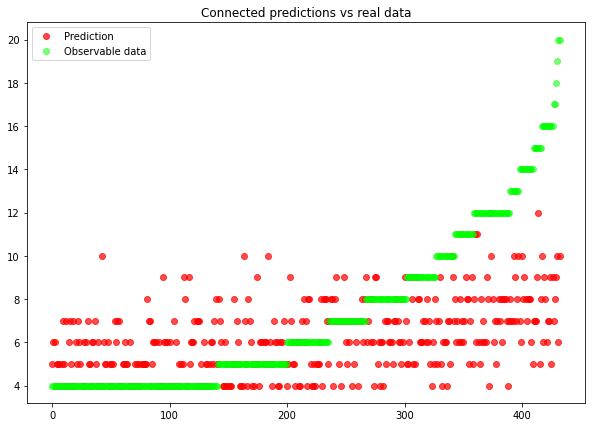

In [15]:
# K FOLD
present_results(SVR_predictions, y_main_true)

MAE: 3.2882121701235643
PearsonRResult(statistic=0.2666998173434987, pvalue=0.010605088031119281)


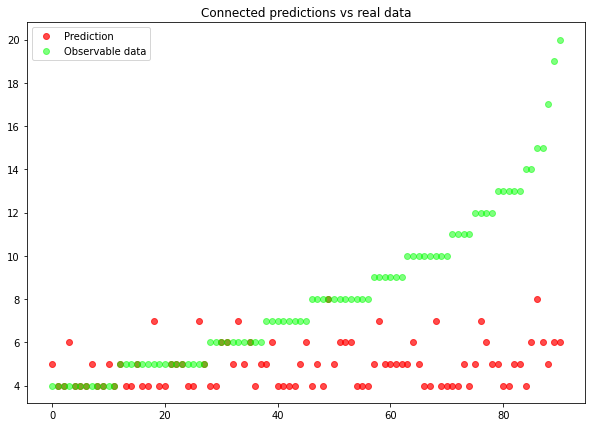

In [16]:
# EVAL DATASET
SVR_pilot_model = SVR_function
SVR_pilot_model.fit(X_main, y_main)
SVR_pilot_predictions = SVR_function.predict(X_pilot)
present_results(SVR_pilot_predictions, y_pilot)

NEURAL NETWORKS SECTION

In [17]:
import tensorflow as tf
import random as python_random

def create_model():
    np.random.seed(123)
    python_random.seed(123)
    tf.random.set_seed(1234)
    keras_model = tf.keras.Sequential([
                        tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(units=1)
                        ])

    keras_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='mean_absolute_error')
    return keras_model

In [18]:
keras_predictions = []

for train_index, test_index in kfold.split(X_main):
    X_train, X_test = X_main[train_index], X_main[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    model = create_model()
    model.fit(X_train, y_train, batch_size=64, epochs=200, verbose=0)
    keras_prediction = model.predict(X_test).flatten()

    keras_predictions = np.concatenate((keras_predictions, keras_prediction))
    print(stats.pearsonr(keras_prediction, y_test))
    
stats.pearsonr(y_main_true, keras_predictions)

2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.45649519458282123, pvalue=0.0018418264432598461)
2/2 [==============================] - 0s 0s/step
PearsonRResult(statistic=0.5566368763404254, pvalue=8.714339670524769e-05)
2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.571243099205797, pvalue=5.128258658018283e-05)
2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.3004607634973251, pvalue=0.05026602905636091)
2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.5351179762453737, pvalue=0.00021802022849224016)
2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.6089248720313127, pvalue=1.471928834788328e-05)
2/2 [==============================] - 0s 8ms/step
PearsonRResult(statistic=0.5709950510706364, pvalue=6.374242201890538e-05)
2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.49521191678296156, pvalue=0.00073492

PearsonRResult(statistic=0.4592104144691441, pvalue=5.6725272561290936e-24)

MAE: 2.4704474246529453
PearsonRResult(statistic=0.4592104144691441, pvalue=5.6725272561290936e-24)


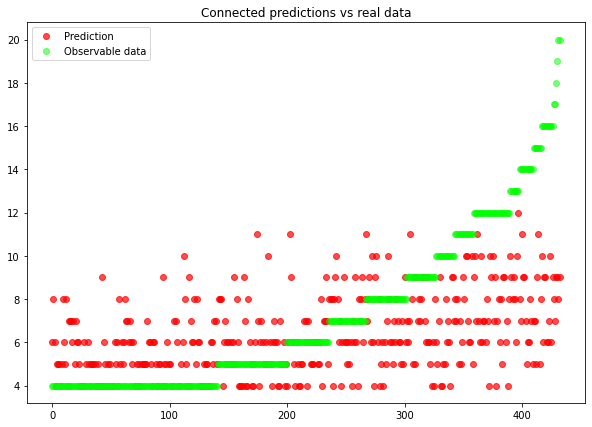

In [19]:
present_results(keras_predictions, y_main_true)

3/3 [==============================] - 0s 0s/step
MAE: 4.012464701474368
PearsonRResult(statistic=0.2869915983827975, pvalue=0.005812866397896812)


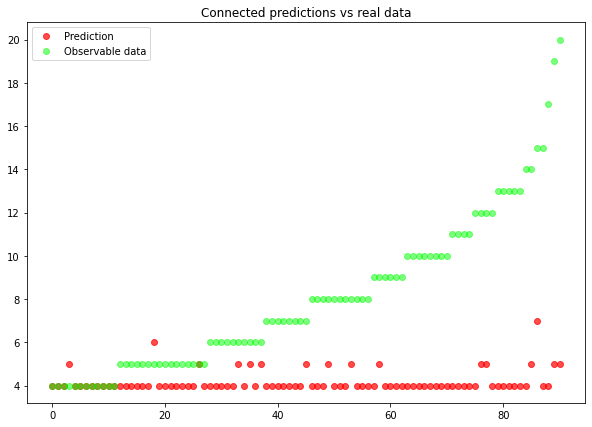

In [20]:
# EVAL DATASET

keras_eval_model = create_model()
keras_eval_model.fit(X_main, y_main, batch_size=64, epochs=200, verbose=0)
keras_pilot_predictions = keras_eval_model.predict(X_pilot).flatten()
present_results(keras_pilot_predictions, y_pilot)


CONNECTING RESULTS

MAE: 2.428875188389137
PearsonRResult(statistic=0.4875903298066905, pvalue=3.0614617422490212e-27)


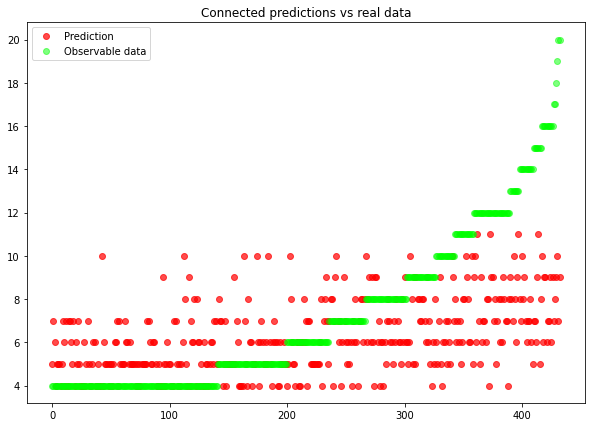

In [21]:
connected_main = [(k + s)/2 for k, s in zip(keras_predictions, SVR_predictions)]
present_results(connected_main, y_main_true)

MAE: 3.6025994323941752
PearsonRResult(statistic=0.28220881439783396, pvalue=0.006724102588255513)


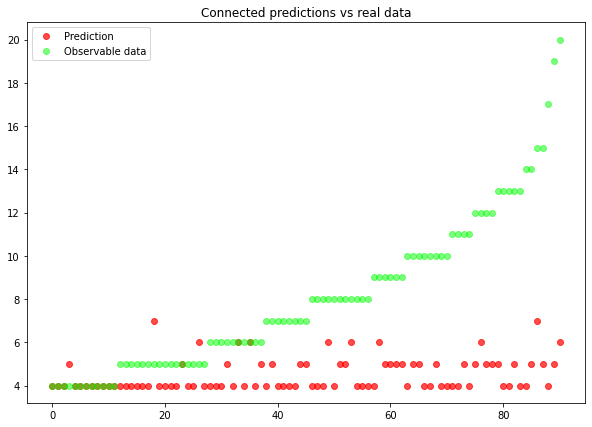

In [22]:
connected_eval = [(k + s)/2 for k, s in zip(keras_pilot_predictions, SVR_pilot_predictions)]
present_results(connected_eval, y_pilot)